# Introduction to Machine Learning via Nearest Neighbours


## Part 2 -Implement k-Nearest Neighbours (kNN)

### Note:
This exercise closely follows the post by Scott Fortmann-Roe about bias-variance tradeoff (see references below). It is recommended that you think about each of the questions before referring to that essay.

In this exercise you will get familiar with a **non-parapmetric** learning algorithm called k-Nearest Neighbours (kNN), and will implement it. You will then analyse the bias-variance tradeoff and try to come up with the optimal kNN classifier for the given data.

For this exercise we will use hypothetical and artificial generated data.
### Nearest Neighbours
The kNN algorithm is simple - given a labeled sample set data, and a new sample, predict the label of this sample by using majority vote (or averaging) over the labels of the k-nearest neighbour of the new data in the sample set.

For this task, assume each data point is an n-dimensional point in $\mathbb{R}^n$, and each label is either 0 or 1.

Implement a class called KNNClassifier and two methods:
- `fit`: should recieve the training data (an array of shape [n_samples, n_features]) and their labels (array of shape [n_samples]). 
- `predict`: should recieve a set of data (an array of shape [n_samples, n_features]) and **return** their predicted labels (array of shape [n_samples]).

Use simple Euclidean distance to measure the distance between two points. In case two points in the training have the same distance from a given point to predict, the nearest would be the one appearing first in the training set. 

Use majority vote between all kNN of a point to predict its label. In case the vote of all kNN is tied, you may predict whichever label you wish.

You may look up [sklearn.neighbors.KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) for reference.

* Bonus for nurdes: use kd-tree for efficiency, see [nearest neighbour search in wiki](https://en.wikipedia.org/wiki/Nearest_neighbor_search)

* Bonus for lazy nurdes: use [scipy's kd implementation](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.KDTree.html)

In [64]:
import numpy as np
from scipy.spatial import distance
import pandas as pd
from collections import Counter
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [63]:
class kNNClassifier:
  def __init__(self, n_neighbors):
    self.n_neighbors = n_neighbors
    
  @staticmethod
  def majority_element(a):
    return Counter(a).most_common()[0][0]

  def get_label(self, i):
    return self.y[i]

  def fit(self, X, y):
    self.X = X
    self.y = y

  def predict(self, X):
    distances = distance.cdist(self.X, X)
    nearest_n_idx = np.argsort(distances,axis=0)[:self.n_neighbors]
    near_labels = np.apply_along_axis(lambda x: [self.get_label(i) for i in x], 1, nearest_n_idx)
    return np.apply_along_axis(lambda x: Counter(x).most_common()[0][0], 0, near_labels)
  
  def get_params(self, deep = False):
    return {'n_neighbors':self.n_neighbors}


## Part 3 - Learn and evaluate kNN algorithm on artificial data
kNN is a **non-parametric** in the sense that no inner parameter of the model is learned by the sample training set (or maybe you could say that the number of parameters increases with the size of the sample set). However, the number of neighbours **k is considered a hyper-parameter**, and choosing the optimal value for it, is choosing the balance between bias and variance as discussed in class.




### An applied example: voter party registration

In this example, each voter is described by a vector of two features $(x_0, x_1)$, where $x_0$ describes how wealthy that voter is, and $x_1$ describes how religious the voter is. Label $y=1$ represents a Republican voter, and $y=-1$ represents a Democrat voter.

Use the given function `generate_data(m)` to create m samples with m labels. The labels are created using the following function:

$$
y = \text{sign}\left(x_1 - 0.1\times((x_0-5)^3-x_0^2+(x_0 − 6)^2+80)\right)
$$

and then a small fraction of the labels (chosen randomly, up to 10%) are flipped to represent unknown effect of features which are not measured. The sign of 0 is defined as 1 for this case.


Below is an example of generating 500 samples, and plotting them.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def true_boundary_voting_pred(wealth, religiousness):
  return religiousness-0.1*((wealth-5)**3-wealth**2+(wealth-6)**2+80)

def generate_data(m, seed=None):
  # if seed is not None, this function will always generate the same data
  np.random.seed(seed) 
  
  X = np.random.uniform(low=0.0, high=10.0, size=(m,2))
  y = np.sign(true_boundary_voting_pred(X[:,0], X[:,1]))
  y[y==0] = 1
  samples_to_flip = np.random.randint(0,m//10)
  flip_ind = np.random.choice(m, samples_to_flip, replace=False)
  y[flip_ind] = -y[flip_ind]
  return X, y

def plot_labeled_data(X, y, no_titles=False):
  republicans = (y==1)
  democrats = (y==-1)
  plt.scatter(X[republicans,0], X[republicans,1], c='r')
  plt.scatter(X[democrats,0], X[democrats,1], c='b')
  if not no_titles:
    plt.xlabel('Wealth')
    plt.ylabel('Religiousness')
    plt.title('Red circles represent Republicans, Blues Democrats')
    
  plt.xlim([0, 10]);
  plt.ylim([0, 10]);
  plt.plot(np.linspace(0,10,1000), -true_boundary_voting_pred(np.linspace(0,10,1000), np.zeros(1000)), linewidth=2, c='k');

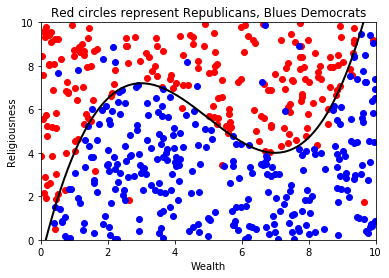

In [6]:
# Play this several times to see different sampling sets
X, y = generate_data(m=500)
plot_labeled_data(X, y)


### 1. Analyse the properties of kNN
Generate multiple sample data sets of size 500 (use the given function above), and plot the decision plane for increasing values of k (e.g.: 1, 3, 5, 11, 21, 51, 99).

The decision plane should cover the range [0,10] for both axes, coloring the patches that would be classified as Republicans or Democrats in two colors. It should look something like this:

![decision plane](https://drive.google.com/uc?export=view&id=1chmyojft_R6ftfBhoPZuGN9AykyUS-cw)

Answer the following questions:
- How is the decision plain affected from changes in the sample set, as a function of k?
    - <font color=green>**small k -> decision plain will fit perfect for the training data, high k -> more generalized**</font>
- Can you describe when do you underfit or overfit the data? 
    - <font color=green>**The higher the k the higher the bias (underfit), and small k result in high variance (overfit - we only check 1 nearset neighbor)**</font>
- How does the complexity of this model depends on k?
    - <font color=green>**O(k*m)**</font>
* Bonus for nurdes:
Use interactive slider for k to see the effect [see [interact](https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html)]

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
# Create color maps
cmap_rb = ListedColormap(['#ffb3b3', '#80aaff'])
cmap_bold = ListedColormap(['#b30000', '#0044cc'])

In [8]:
def select_k(k):
    knn = kNNClassifier(k)
    fig = plt.figure(figsize=(20, 5))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    fig.suptitle('k={}'.format(k), fontsize=16, fontweight='bold')
    for i in range(1, 4):
        ax = fig.add_subplot(1, 3, i)
        X, y = generate_data(m=500)
        knn.fit(X,y)
        xx, yy = np.meshgrid(np.arange(0.0, 10.0, 0.2), np.arange(0.0, 10.0, 0.2))
        Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        ax.pcolormesh(xx, yy, Z, cmap=cmap_rb)
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
        ax.plot(np.linspace(0,10,1000), -true_boundary_voting_pred(np.linspace(0,10,1000), np.zeros(1000)), linewidth=2, c='k');
        ax.set_xlim([0,10])
        ax.set_ylim([0,10])
interact(select_k, k=widgets.IntSlider(min=1,max=99,step=2,value=1))

interactive(children=(IntSlider(value=1, description='k', max=99, min=1, step=2), Output()), _dom_classes=('wi…

<function __main__.select_k(k)>

### 2. Finding the optimal k
Sample a single sample set of size 1000 and divide it randomly to train (0.6) / validation (0.2) / test (0.2) sets. Plot the train vs validation error for several k values, and choose the best k. Where do you underfit/overfit the data? Finally, estimate the generalization error of your chosen classifier using the test set. What would happen if you optimize directly on test? is the optimal k the same?


[mse]: Optimal k = 3
Optimal k = 3
Classifier generalization error for k=3: 0.48


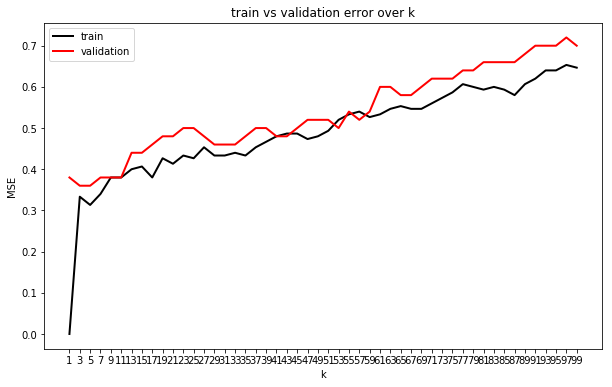

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

MAX_K = 99
X, y = generate_data(m=1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2)
X_cv, y_cv = X_train, y_train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    test_size=0.25)

train_err = []
val_err = []
knn = kNNClassifier(1)
knn.fit(X_train, y_train)
for k in range(1, MAX_K+1, 2):
    knn.n_neighbors = k
    train_err.append(mean_squared_error(y_train, knn.predict(X_train)))
    val_err.append(mean_squared_error(y_val, knn.predict(X_val)))

plt.figure(figsize=(10, 6))
plt.xlabel('k')
plt.ylabel('MSE')
plt.title('train vs validation error over k')
plt.xticks(range(1, MAX_K+1, 2))
plt.plot(np.arange(1, MAX_K+1, 2), train_err, linewidth=2, c='k', label="train");
plt.plot(np.arange(1, MAX_K+1, 2), val_err, linewidth=2, c='r', label="validation");
plt.legend(loc='upper left')

val_best_k = range(1, MAX_K+1, 2)[val_err.index(min(val_err))]
print('[mse]: Optimal k = {}'.format(val_best_k))
print('Optimal k = {}'.format(val_best_k))
knn.n_neighbors = val_best_k
knn.fit(X_train, y_train)
print('Classifier generalization error for k={}: {}'.format(val_best_k, mean_squared_error(y_test, knn.predict(X_test))))

### 3. Using cross validation
This time, put the test data aside (0.2 of the data), and apply 5-fold CV on the remaining data to evaluate the performance of each k value. 
What is the size of the validation and train set now, in each CV iteration?
Did your final model selection change? Explain why.

In [59]:
from sklearn.model_selection import cross_val_score
print('Validation size = {}, Train size = {}'.format(X_cv.shape[0]*0.2, X_cv.shape[0]*0.8))

Validation size = 160.0, Train size = 640.0


In [61]:
MAX_K = 99
cv_scores = []
knn = kNNClassifier(1)
for k in range(1, MAX_K+1, 2):
    knn.n_neighbors = k
    cv_scores.append([k, max(cross_val_score(knn, X_cv, y_cv, cv=5, scoring='accuracy'))])
optimal_k_cv = np.where(np.array(cv_scores)[:,1]==max(np.array(cv_scores)[:,1]))[0][0]

In [62]:
print('[cross-validation]: Optimal k = {} | Accuracy = {}'.format(optimal_k_cv, max(np.array(cv_scores)[:,1])))

[cross-validation]: Optimal k = 4 | Accuracy = 0.94375


**Final model selection changed:**
    for lower k we overfit - cv find the optimal k

# Curse of Dimensionality Linear Regression (Next Week) vs. KNN Regression

## Part 1 - Curse of Dimentionality Theory by Numerical Analysis
* Recall the plot which describes the size of inner cube to cover fraction of volume (data) in Kevin Murphy's book: "Machine Learning-A probabilistic Perspective". Recreate the plot in the book using python. 
* Recall the plot which describes the ratio between sphere and cube in hyper dimension. Recreate the figure in python. See [volume of n dimensional ball](https://en.wikipedia.org/wiki/Volume_of_an_n-ball)

The result should look like this:

https://i.stack.imgur.com/L3fF3.png
http://www.visiondummy.com/wp-content/uploads/2014/04/hypersphere.png
![](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAl8AAAFhCAYAAABOJ89dAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMS4yLCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcvNQv5yAAAIABJREFUeJzs3Xl8VPW9+P/X7Esmmez7CoGwJSRA%0A2CEsQhS0LqDQKtprb7X+pHVre+3i7a3tr7a3tla9XbTVarWtCLiAC+DCviRsgUBYk5B9XyaT2WfO%0A+f4RiKBAgEwyCfk8H495JJOZc877zCRn3vks749ClmUZQRAEQRAEoV8oAx2AIAiCIAjCUCKSL0EQ%0ABEEQhH4kki9BEARBEIR+JJIvQRAEQRCEfiSSL0EQBEEQhH4kki9BEARBEIR+JJIvQRACxul0cv/9%0A9zN+/Hg++OCDK9pm3rx5vPLKKwD89Kc/ZeXKlX0Z4hXbu3cvmZmZtLW19cvxMjIy2LBhAwD3338/%0Av/rVr/rluIIg9J460AEIgjB07dixg927d/P5558TFxd31dv/8pe/7IOortxrr73GsmXLMBgM5Obm%0AUlxcHJA4Xn311e7vJUnib3/7Gw888EBAYhEEoWei5UsQhICxWq3o9fprSrwCrbW1lV//+tc4HI5A%0Ah3KBkpIS/vznPwc6DEEQLkMkX4IwyNXW1vKd73yHCRMmMHPmTH71q1/h9XqBC7vooCthyMjIoKCg%0AAIAVK1bw61//mmXLlnHzzTcDsG3bNm6//XZycnKYMmUKTzzxBB0dHQDIsszLL79Mfn4+48ePJz8/%0An/fee++SsZ1rhcnPzycrK4v8/HxWr14NwJtvvslPf/pT7HY7mZmZF92P0+nkySefZPLkycyePZu3%0A3nrrgseffPJJHnzwQQDeeecdbrjhBtatW0deXh45OTn86le/oqysjLvuuovs7GyWL19OQ0ND9/af%0Af/45S5cuJScnh5kzZ/Lb3/4Wn8/Xvb/8/Hw2bdpEfn4+2dnZrFixgoaGBmpqapg9ezayLJOXl8fL%0AL79MQUEBGRkZtLa2AtDY2MgjjzzC9OnTycnJ4f7776e0tLT72Oe6De+//35ycnKYN28eGzdu7H78%0A+PHj3HfffUyePJnJkyezcuVKmpqaLvo6r1ixgqeffpq9e/eybNmy7tf0pZdeYtSoURw6dOiC569c%0AuZInn3zyku+bIAh9SyRfgjDIPfzww0RERLBt2zZWrVrFZ599dkHC1ZMPPviAxx57jPXr1+PxeHjk%0AkUf4+te/zv79+/n4449pbW3lL3/5CwD/+te/+Oc//8kLL7zAgQMH+PGPf8xPf/rTS3a3rVq1ilde%0AeYXf/va3HDhwgCeeeIKf/exn7N27l3vuuYdf/OIXGI1GiouLue22276y/UsvvURhYSFr167l448/%0ApqSkhObm5kueS3NzMyUlJWzcuJGnn36a119/nZ///Oc899xzfPrpp9TV1fHmm28CcOzYMR599FG+%0A/e1vs2/fPl577TU2btzI66+/3r2/xsZGNm/ezJo1a9i4cSM1NTW8+uqrJCQkdL/GW7duvWgX33e/%0A+128Xi8fffQR27dvJzw8nIceeghJkrqf8+c//5kf/OAHFBYWkpeXx3//939zbsW3Rx55hJEjR7Jz%0A504++eQTmpub+d///d/Lvpe5ubkXvKYPPvggkydPviCxtdlsbNu27aKvtyAI/UMkX4IwiJWUlFBS%0AUsLKlSsxmUwkJCTw3HPPMWnSpCvex4gRI5g6dSoKhQKXy4XT6SQoKAilUkl4eDivvPIKP/zhDwF4%0A6623uOeee8jIyEClUpGXl8fcuXN59913L7rvVatWcdddd5GVlYVarWbhwoVMmjSJDz/88Ipi27Bh%0AA0uXLiUpKYmgoCAef/xxPB7PJZ/vcDh48MEH0ev13HDDDQDMnTuXhIQEIiMjyc7OpqKiAoC1a9cy%0AZcoU8vPzUalUpKenc9999/HOO+90789ut/Poo48SHBxMTEwMU6ZMuaD16lKOHz9OUVERP/zhDwkN%0ADcVkMvH4449TUVHBkSNHup934403Mnr0aDQaDYsWLaK9vZ2Wlhagq+XtBz/4ARqNBrPZzJw5c65p%0ATNmSJUv46KOPcLvdAGzZsoXIyEimTJly1fsSBME/xIB7QRjEKisrUavVF4yZysrKuqp9JCYmdn9v%0AMpn43ve+x3/913/x17/+lenTp3PzzTczZswYAM6cOcPzzz/PCy+80L2NLMvMnDnzovuuqqoiPT39%0Agp+lpKRQVVV1RbHV19eTnJzcfT80NJTIyMhLPl+v1xMWFgaAwWAAIDo6uvtxg8HQPRuxvLyc3bt3%0Ak5mZecG56HS67vs6nY6YmJgLtne5XD3GXVVVhUajISUlpftn8fHxaDQaKisru9+j8x/X6/VAV1cr%0AdM2e/L//+z/KysrweDxIknRBLFcqPz+fp59+ms2bN5Ofn8+GDRv42te+hkKhuOp9CYLgH6LlSxAG%0AMaVSiSzL3V1VPTm/y+scjUZzwf2HHnqIzZs3841vfIOysjKWLl3Kv/71L6ArQfj5z39OcXFx9+3I%0AkSPd3ZJfdq615Vp5PJ7uMVjnXO5clcqvXtIu9jPoOpdbbrnlK+eyf//+7ueoVKprivty531+0nOp%0A2MrLy1m5ciXz5s1j27ZtFBcX88gjj1xTLHq9nsWLF/P+++9js9nYvn276HIUhAATyZcgDGLJycn4%0AfL7urjSAffv2dXfr6XS6C2bjVVZW9rjP1tZWoqKiuOuuu/jLX/7Cgw8+yL///W+gq6Xm2LFjFzy/%0Atrb2KwnS+fGdPHnygp+dOnWK1NTUKzq/6Oho6urquu+3tLRcdszX1bjYubS2tmK323u976SkJDwe%0AD2VlZd0/Ky8vx+PxXNDadSklJSVIksQDDzyAyWQC4OjRo9ccz5IlS9ixYwfvv/8+o0aNuuLXXxCE%0AviGSL0EYxEaNGsW4ceN47rnn6OjooL6+np/97GfdyVhaWhrbt2+ns7OT1tZWXnvttcvu7+DBg8yf%0AP5/CwkIkScJqtVJaWkpaWhoAd999N2vXrmXnzp14vV4OHjzIHXfcwebNmy+6vyVLlrB69WqOHj2K%0Ax+Nh3bp1HDp06IpbXubMmcOaNWuorq6ms7OT3/3udxd0C/bGsmXLKC0t5e9//ztOp7N71uhzzz13%0ARduf6yYsLy/HZrNd8FhmZiYjR47kd7/7HVarFYvFwu9+9ztGjRrF2LFje9x3YmIiPp+PoqIibDYb%0Ab7zxBjU1NVgslh5LW+j1epxOJzU1Nd2J5Pjx40lKSuL3v/+9aPUShAFAJF+CMMi99NJLOBwO8vLy%0AWLp0KbNmzeLb3/420DVjzu12M2PGDO69917uvffeS3Z1AeTk5PD973+fn/70p+Tk5LBw4UKUSiVP%0APfUUALfddhvf+c53+MlPfsKECRN48skneeSRR7oHt3/ZN7/5TZYvX86jjz7KlClTeP3113n55Zcv%0AGGd1OY8//jhZWVncdttt3HTTTWRmZl4wBqw3UlJSeOGFF3j33XfJzc1l+fLlZGVl8YMf/OCKth89%0AejSTJk3ivvvu449//OMFjykUCv785z/j8/lYsGABixYtQqPR8Le//e2KxlqNHz+e+++/n4ceeoj5%0A8+fT3NzMH/7wB8xmM3Pnzr3sttOmTSM9PZ38/PwLJg/ccccduFwuFi1adEXnJwhC31HIVzpYRBAE%0AQRi0nnnmGdra2nosVyEIQt8Tsx0FQRCuczt37mT16tW8/fbbgQ5FEARE8iUIgnBdu/HGG3E4HDz9%0A9NNfKfshCEJgiG5HQRAEQRCEfiQG3AuCIAiCIPQjkXwJgiAIgiD0I5F8CYIgCIIg9CORfAmCIAiC%0AIPQjkXwJgiAIgiD0I5F8CYIgCIIg9CORfAmCIAiCIPQjkXwJgiAIgiD0I5F8CYIgCIIg9CORfAmC%0AIAiCIPQjkXwJgiAIgiD0I5F8CYIgCIIg9CORfAmCIAiCIPQjkXwJgiAIgiD0I5F8CYIgCIIg9COR%0AfAmCIAiCIPQjkXwJgiAIgiD0I5F8CYIgCIIg9CORfAmCIAiCIPQjkXwJgiAIgiD0I5F8CYIgCIIg%0A9CN1oAO4Uk1N1kCH0KOwMCNtbfZAh9GnhsI5wtA4z8FwjlFRwYEOwW+u5ho2GN6bixFx96/BGjcM%0A3tivJu7LXb9Ey5cfqdWqQIfQ54bCOcLQOM+hcI6D1WB9b0Tc/Wuwxg2DN3Z/xS2SL0EQBEEQhH4k%0Aki9BEARBEIR+JJIvQRAEQRCEfiSSL0EQBEEQhH4kki9BEARBEIR+JJIvQRAEQRCEfiSSL0EQBEEQ%0AhH7Up8nXyZMnueGGG3jzzTe/8tiuXbtYunQpy5Yt449//GNfhiEIgnDVxPVLEIS+0mfJl91u5xe/%0A+AXTpk276OO//OUvefHFF/n3v//Nzp07OX36tN+O7XR7Ka214HR7/bZPQRCGjkBevwRBuP71WfKl%0A1Wr561//SnR09Fceq6qqwmw2ExcXh1KpJC8vj927d/vluA6Xhx+9tIf//x/7+cXr+0QCJgjCVQvU%0A9UsQhIFBlmV8Xjt2Sw21xws49Nm/2P7Oi+wv9M/fep+t7ahWq1GrL777pqYmwsPDu++Hh4dTVVV1%0A2f2FhRmvqKx/0ckmLDY3AHUtduxemaSE/lsf7npai+5ShsI5wtA4z6FwjtfC39cvuPJr2DmD9b0R%0AcfevwRo3BC52WZbxemx4nO24nRbcznY6Lc3YOlpx2dvweTpQKu0olXL3NmHhXbfyA1uZOPniLeJX%0AY9AsrH2lC1lGBKnRa1U43T5CTVqMakW/LcodFRU8KBYA742hcI4wNM5zMJzjYP5g+bKrWUR4MLw3%0AFyPi7l+DNW7o29glnxufx4LXbcHn7sDrOfvVbcHjbMfntaLAd9FtFYDXp8VpC8LtUOGzg8vlw+qR%0A6cTEvd956Irjvtz1KyDJV3R0NM3Nzd33GxoaLtq8fy30WjU/WjGRn79aiFqlQK0SEzoFQfCfvrx+%0ACYJwebIsI3nteN3t+NwWvO52vJ4OfO52vO4OfG4Lks9xye1dLg1OpwGHU4fDqcPl1CB1SmB1oe5w%0A4PbYsJg6aI6wo0pLwBWWTvEBA8nh4fzwGxMIMQXR5Oh90hiQ5CsxMZHOzk6qq6uJjY1l8+bNPPvs%0As37bf1KUiXkTEvl0fzVbi2qZPzHRb/sWBGFo6+vrlyAMZV3JVWdXUuWynE2y2vG6Ld0JlyxffCy3%0AJKlwuvXYOsO6kitHV4LldOpwOTQoOxwYHRaC3BaCPPWYVW680WpOmZ2Ux/poGKshxBTO5Ng85sVO%0AYP9hO2u2lBITbuTxZdkY9f5Lmfos+Tpy5Ai/+c1vqKmpQa1Ws3HjRubNm0diYiILFizgf/7nf3ji%0AiScAWLRoEWlpaX49/s0zUtlRXMe6neVMHxeLQTdoelgFQQiwQF+/BOF6Jcsyks+JzdKOva0Wr7vt%0AbKLV3vXV3Q7yxbsEZYUen8+M06nH2qmhvV2NzaY9m2Tp8XjUqFUKgpUujI5mDO21RLrbCXJb0Pts%0A6OIT0GSkURMRwV6DRAmNoPCgVwUxITqTO2MnMjw0FaVCyZaiGtZsKSU8RMf3l2UTEqT16+ugkGVZ%0A7vlpgXctfcPrdpbz3vZyvjYjldtmDeuDqC40mPvfr9RQOEcYGuc5GM7xehrzdTWv9WB4by5GxN2/%0ABmrcsuzraqlytXUlV66zN3c7Xncbss910e2UKgNKjRmfZMLpMtDZqaW1VUVTA3R0aPD5vpiwolYr%0AMQerCVY6Mdoa0TWUY2irRu+1oQAUOh2GYcPRp49AN2wYFWEye9qKKW4uwSv7UKBgdPhIpsRNJCty%0ALFqVpnvfhccaeOn9o5iMGp68ewJxEUHdj13Naz7gxnz1l/zcZD4/UMPGwirm5iRgNukCHZIgCIIg%0ADHqS5DmbVLV23dxd33tcbfjcFuCr7ToKpQa1Ngx1UCgmcxQdnVpsNi3tbRqaGqCp0Y3V4rxwGwWY%0Aw42kDDcQonYTZGtEW1eKqrwE2fHFJBaVORRD9hgM6SMwpI9El5REg7OZ7XX7KKxfR8fZhCk2KIap%0AsRPJjc0hVGf+SoyHS1v46/oS9DoVj9+VfUHi5U/XdfKl06q4dWYab2w8wbpdZ1ixMCPQIQmCIAjC%0AoCBLXjznkitXCx5XG15XC15XVzmGi1GqTeiCElFpw9DowlDrwkBlxtqhpaVZornSRktDJ63NNjxu%0AH+A4ewODUUNiahgR0UGEheowuVrR1pfhPr0H54FSZI+n+zjqmFgMEydhGDESw8iRaCKjUCgUOLwO%0A9jUcYvfBDzjTUQmAUW1gdsI0psZNIjk4EYVCcdHYT1a186d3i1EqFTyydDwpsX3X8n5dJ18As7Li%0A2FRYybaiWhZOSiIm3BjokARBEARhQJBlCZ/bgsfVgtfZcjbZasHjajnbgvVVKo0ZnSkVtS4cjS4c%0AtS4MtS4ctTYMt1tBc4OV2oZOms/eLK2tnD/ASalUEBltwhxhICLaRGS0iTCzBkV9JY4Tx7EXHsdZ%0AXobD5+tKyxQKdIlJZxOtDAwjRqA2h553DjKn28vYVbeXg43FeCQPChSMCc9gatwksiLHoDmvW/Fi%0AKuqtPL/mED5J5rtLMhmZFHrZ5/fWdZ98qVVKluQN50/vHeGdbWU8dNu4QIckCIIgCP1K8rm7kipn%0AMx5n8xffu1ouOsBdpQlGZ0pBrYs4m2CFdydbCmVX6mDvdNHU0EnTaSvN9U00N5Rh7bhwPJdGqyI2%0AwUxkjInIGBMR0SbCI4OICtdTXVCE/fhe7JuPU1teBr6zcSgU6FJSMY7MOJtsjUQV9NXuP4urgz11%0A+9hdt5cmRwsAkfpwpsXnMiV2ImH6K0ug6lps/P7tIpwuHw/eOpas4ZFX89Jek+s++QKYmBFFWlwI%0Ae483cmNdB2lxIYEOSRAEQRD8zue143E24T2bZHmcTXiczRftJlQoNWj10aj1EWh0EV981UWgVF04%0Au89uc1NXY6WxvpqmeivN9VZsne4LnmMwakgeFt6daEXGBBMSqkehUCB7vTjKSnEUFlB7/BhlZaXI%0A3rMlIxQK9KlpGDJGfZFsGQwXPz/JR0nrCXbWFnK05TiSLKFRapgcO4HpcbkMD01Dqbjy+p4tFie/%0AW1WE1e7h3vwMJo+OueJte2NIJF8KhYK75g7nN/86yOrNp/nB13Mu2ecrCIIgCAOdz+vA2taEtani%0AbILVdZO8tq88t6sVKw2NPvLsLQK1LhKVJviin4Uup4fGylYa66w01VtprLNis17YohUUrCUlPYKo%0A2GCiYkxExQZjNGm79ydLEq6qStoKSrAfK8Fx6iSy+2yyplAQNCwN7fCRGEaNwjAi45LJ1jnNjlZ2%0A1xayu24fFndXIpkcnMj0+FwmxWRjUF9++4vpsLl5dlURrR0uls4ZzpychKvex7UaEskXQEZyGFnD%0AIzhc2sKR8lYyh0UEOiRBEARBuCxJ8nQlVo5GPI6G7u993s6vPFelDUUfMuJsghXV/VWpuvRMf59X%0Aormxk4baDhrrOmistWJpu7BCvCFIQ8rwCKLigomKNREdG4zxItUD3E2N2EuOdt2OH0OyfZEIauPj%0AMY4ag3H0aAwjRxGbGttjyQaf5ONQ81F21hRwvO1UVyxqPbMTpjM9fjJJwfGX3f5y7E4vv3+7iIZW%0AOzdNTWbR1JRr3te1GDLJF8CSvOEUl7awenMpY9PCUYrWL0EQBGEAkGUZn9uC29GAx9nQ9dXRiNfV%0AypfLNqg0ZvQh6ZjDE/FIZrSGKNS6yK90FV7sGFaLk/qaDhprO2io7aC5oRNJ+mL/Wp2KhJRQouND%0AiI4NJjoumKBg3UVbyHw2G/bjJdiPdiVcnuam7sfU4eGYsidgHD0a4+gxFwyQ70mzo4WdtYXsrtuL%0A1d2VZA4zpzIjfjITorPQ9nCePXF5fLyw5hCVDZ3kZcezNG94r/Z3LYZU8pUUbWL6uFh2Hqlnz9F6%0Apo+LC3RIgiAIwhAjSz48zibcjnrcjno8jq5kS/Z9qcaVSo/OlIRGH4PGEI1WH43GEIVSpQd6Lvjp%0A8fhoqrNSX2OhoaYr2XLYvyjXoFQqiIwxER0X3JVsxQUTGm685LAc2efDWVaGreQI9qPFOMvLOTeN%0AUWkwYMqZiHHMGIxjxqKJjrmq4T0+yUdxyzF21OzhWOtJoKtExNykmcyIn0JckH/GYnl9En9+7wgn%0Aqy1MHh3NioUZARmGNKSSL4DbZg2j4Fgj724rI3dUNBq1queNBEEQBOEaSJKnK7my13UlW/Y6PM5G%0AkKULnqfWRaANHobGEIPWEIPGEHvJMVmX0tnR1apVX22hvqaDlsYLW7VMITqGj4oiJj6EmPgQImNN%0AqHv4DPS0tmA7Uoz96BHsJUeRHGe7JJVK9MPTCRo7DuOYsehT01Corv7ztM3Zzs7aQnbVFnaP5Rpu%0ATmVmwlRyojJ7LBFxNSRJ5m8flHC4tIXMYRH8581jUCoD0wM25JKvCLOe+RMT2FhYxeYDNSycnBzo%0AkARBEITrgCx5cZ9LtOy1XyRa53cbKlRoDbFoDbFojGe/6qN77DL8yrFkmca6DkqKa6mrtlBfZbmg%0AzINSpSAqLpjY+BBiEszEJIRgCu55lRfZ68Vx6iS24sPYjhTjrq3pfkwTGUXw5KkEjRuHIWM0KuO1%0A1c2UZIlD9SV8cPRzDjeXICOjV+nJS5zOzPipxJtir2m/lyPLMm9uOkHhsUZGJJr5/24fh1p15bMi%0A/W3IJV8Ai6elsu1QHet3nWFmVrxfVyoXBEEQrn+yLON1teCy1ZxNtGpwOxouqJmlUGrQBiWgNcaj%0ANcShNcai0UeiUFx9C5HPJ9Hc0EldVTu1VRbqqy24nN7ux/UGNanpEcQmmolNCCEqLrjHVq1zPK2t%0AXclW8SHsx44hu7q6PxVaLcZxWQRlZhI0LvOquxK/zO6xs7tuH9trdnfX5UoOTmBWwjQmxmSj6+VY%0ArstZu7WMLUW1JEebeGRpFjpNYHu9hmTWYTJoWDwthTVbSvm4oIIlARhsJwiCIAwekteBy16Dy1aN%0A21aDy15z4RgthbKrRcsY333rSrSurXXF55NorLNSW9lObWU79TUWvJ4vuiqDzXoyxsUSFmUkLsFM%0AaMSlx2p9mSxJOMvLsB0qwlZ8CFdVVfdjmphYgjKzCBqXiSEjA6Wm9wlRlbWGbdW72NtQhEfyoFGq%0AmZM6jdzIiaSG9H3v00d7KvhoTwUx4UYeX5aNUe+/rsxrNSSTL4AbJiby2f5qPtlbxbwJiYRdQXOs%0AIAiCcP3ratVqxWWr6r55nc0XPEetC0cbMgJdUAJaYwJaQ0x35fdrIUldyVZNxcWTrbAII3HJocQn%0AmYlLNGMK0fc44P6C/Tsd2I4cwXa4CFvxYXzWru0UajXGseMIyhxPUGYW2hg/DWyXvBQ1FrO1Zhdl%0Algqgq/r8rMSuNRbT4nsuNeEPW4pqWLOllLBgHd9flk1IUN+1rl2NIZt8aTVdi26/9vFx3t9Rzjdv%0AGhXokARBEIQAkCUfbnstzs5KXJ2VuGyVSF579+MKpQadKRVdUCK6oES0QYmo1L1bJ1iWZVqbbFSf%0AaaOmoo3aKsvZhaa7hEUaSUgOJT45lLikUIzXkDR4WluxHTpIZ9FBHCeOd1eUV5nNhMyajSlrPMbR%0AY1Hq9b06l/NZXB3sqNnDjtoCOtxWFCgYGzGK2QnTGBORcVXV53ur8FgDb2w4gcmg4fvLs4kw++88%0Ae2vIJl8AMzJj2VhYyfbDteRPTiIu4qtrRwmCIAjXF1mWcNtrcXVW4OysoPpwFZLvi8HqKk0wxtCx%0A6ExJ6IKS0Bhirrn78HxWi5PqM21dt4o2nOeVfTCHG0hIDiUhJYz45GtLtmRZxl1TTefBA3QWHcRV%0Acab7MV1SMkHZOZjGZ6NLTkGh9G8SdKajks1VOzjYWIxP9mFQ65mXNItZCdOINvb9Wolfdri0hb+u%0AL0GvU/HEsuwB9/k+pJMvlVLJ0jnDeXFtMWu2lPLdJVmBDkkQBEHwM1mW8TjqcVrP4Owsx9VZiSx9%0AsS6hzhiF2pCI3pSCLigZldbsl9pPHreP2sp2qspbqSpvpb31i8rxQSYtI8fFkJgSRkJKKKaQa2uV%0AkSUJZ2kpnQf303nwAJ6mxq4HVCqMY8aeTbhy0ET4f1UXn+TjYFMxm6t2cKajEoBYYzRzkmaQGzMB%0AvToww3lOVrXzp3eLUSoVfG9JFimxwQGJ43KGdPIFkJ0eSXqimYOnmjldbSE90RzokARBEIRe8rra%0AcVrLzt7KkXxfJD5qXQT64FR0plT0pmRi4+P9Mv5IlmVam21UlbVSWdZKXbUFyddVZkKtUZIyPJzE%0A1HAS08IIu4oB8l85jteL/eQJOkoO0bS7AJ/FAoBCp8c0aTKmnByCMrNQGfumtafTY2NnTQHbanbT%0A7rKgQEFm5GjmJM4kIyw9oGsnV9RbeX7NIXySzHeXZJKRHBawWC5nyCdfCoWCO+cM55k3D7B6y2me%0AvHuCWHRbEARhkJEkDy7rGRzWUpwdp88uy9NFpQkhyDwSfXAaOlMqam2I347rcXuprminsrSFyrJW%0AOs+rtRUZYyIpLZyktDBiE82oelFXSvZ6sR8rwbp/L50HD3Svm6gyBRMycxamCZMwjh6DUtN3M/nq%0AbY1srtpOQf0BPJIHvUrHnMQZ5CXOCEjX4lfia7Xz+7eLcLp8PPC1sWQND3xMlzLkky+AEYmh5IyI%0A5OCpZg6dbiF7xMB9wwRBEIQuHlcrTsspHB2ncXae6a6xpVBqMYSMRB8yDH3wMNS6CL/+U221OKk4%0A3cKZ083UVLZ3t27p9GrSR0eTPCycpGHh1zRu63yy14ut5Cid+/bSWXQAyd41CUBlDsU8dz5J82fj%0Aikq8psryVxyDLHOi7TSfV23naMtxACL04cxJmsG0uEkY1IY+O/bVaLE4efatg1jtHlbkZzBljH9m%0AbfYVkXydtSRvOEWnm1mztZSs4REBW3JAEARBuDhZlnDbqrFbTuKwnMTr+qL8g0YfgyFkOPqQdHRB%0ASSiU/ktIZFmmqd7KmVMtnDnVTEuTrfuxiKggUtIjSB4eQUx8MMpeDmSXfT7sx49h3VtA54EDSPau%0AY6nDwgmZPpPgiZPQD09HoVT6RraRAAAgAElEQVRivopSE1fLJ/nY33iIzyq3Ud1ZC3Qtbj0/aRZZ%0AUWP7ddZiTzpsbp5dVURrh4slecOYm5MQ6JB6JJKvs+Ijg5iVFce2Q3XsLK5j1vj4QIckCIIw5MmS%0AF6e1DLvlBA7Lie4SEAqFGkPISAzmEehDRvi1KxG6ipzWVbVTdrKZM6easVm7BugrVQqSh4WTkh5B%0AyvAIgv1QvkCWJBynT2EtLKBz/97uGlyq0FBCpy8kOHcy+rRhfp+heDEOr4MdNQVsqd5Ju8uCUqFk%0AYvR45iXP6peCqFfL7vTy+7eLaGi1c9OUZBZPSw10SFdEJF/nuXXmMHYfbeC9HeVMGRODNsDLDwiC%0AIAxFkuTB2VGKvb0Eh+Vk98xEpTqIoIgJGM0j0QWnoVT6d3yT1+ujuryNshNNnDnd0r18j06vZuS4%0AGNJGRJKUFoZG2/uPTlmWcVdX0bFnN9a9BXhbu8aoqYJDMM+dT3DuZAzpI/ol4YKuBa43V+1gZ20B%0ATp8LrUrL3KSZzE2cSYQhvF9iuFouj4/n1xyisqGT2ePjWTpn8KxWI5Kv84QF61gwKYmP9lTw2f5q%0AbpqaEuiQBEEQhgRZ8uGwnsbedvSChEulDcUYOgGjeTTaoES/T4jyen0cL67jYGElZ063dBc6DQrW%0AMmJMAmkjI4lPNve6O/EcT2sL1j276dizu3vRaqXBQMiMWQRPnoJx1Og+HcP1ZXW2Bj6p2MLehoNI%0AsoRZG0x+yjxmJkzBqOldIdm+5PVJ/Pm9I5yqtpA7Kpp78zMG1WS5K0q+tmzZQnV1Nffccw+VlZUk%0AJSUNqpO8GoumJrO1qIYPd1cwa3w8JkPg14ASBEG4HsmyjMtWib21GHt7CdLZtRJV2lCCQidhDBuL%0AxhDr988bn0+iuryN08caKT/V3J1wBZv1jMmOZ1hGJDHxIX47rs/hoHP/Pjp278Rx8gTIMgq1GlPO%0ARIKnTiUoa7xf1lC8GqXtZ/ikcjPFzceArvpc85PzyI3NQdOLZZL6gyTJ/O2DEg6XtjBuWDjfvmXM%0AoBun3eMr/Nvf/paKigpqa2u55557WL9+Pa2trTz11FP9EV+/M+o13Dw9lVWfn+aj3RXcNS890CEJ%0AgiBcV7yuNjpbD2FrPYzP3Q6ASm0iOGoKxrBxaI3xfk+4ZFmmrsrCyaMNlJ1o6u5SDDbryZ2RSlyy%0AmajYYL8dV5Yk7MeP0bFzB50H9yO7u1ryDCNGEjxtOsETc1EF9W/VdVmWOdpynE0Vmym1nAFgmDmF%0ABclzGBc5ekANor8UWZZ5c9MJCo81kp5o5uHbM1H3ooRHoPSYfO3du5e3336bFStWAPDwww+zfPny%0APg8skOZNSODTfVV8ur+a+RMTB9R6UIIgCIORJHlwtB+js+Ugrs6uhZYVSg1B4eMJCs9EZ0r1yxI+%0AX9baZOPk0XpOlTR21+AymrRkTUokfUw00XHBREeH+G3WoLuxkY5d2+nYtbN7HJcmOoaQadMJmTod%0ATVSUX45zNSRZ4kDjYTZVbKamsw6AcRGjWJAyl/TQtH6PpzfWbi1jS1EtydEmHl2ahW6Qjs3uMfnS%0A6bqWBzj334DP58Pn811uk0FPo1Zx26xhvPLhMd7bUca3Fo8JdEiCIAiDksfZhLV5P7bWw8hnuxV1%0AphSCwrMxho5GqfJ/d5vD7ubU0UZOHKmnuaETAK1OxaisWEaMiSE+OdSv3VSS203n/n1YdmzDcaKr%0AFpZSrydk1mzM02ehTw9M1Xev5KWw/gCbKjbT5GhBgYJJMdksTJlLgimu3+PprY/3VPDRngpiwgw8%0Atiwbo37wDgvqMfmaMGECP/rRj2hsbOTvf/87mzZtYvLkyf0RW0BNG9u16Pau4nryc5NJjDYFOiRB%0AEIRBQZYlHJYTWJv24uo8A3TNVAyOmUFQRA4anf9nz0mSRGVZK8cP11NxugVJklEoICU9goxxMaQM%0Aj0Dt51YSV1UV7du2YN2zC8nRtXyRIWMU5rMV55W6wKxt6PZ52F23l08qttDmaketUDEjfgoLkucQ%0AZfT/Go/9YUtRDau3lBIWrOOJ5dmYe1nANtB6TL4ee+wxNmzYgF6vp76+nv/4j/9g4cKF/RFbQCmV%0ACpbOSecPqw+xZmspj945PtAhCYIgDGg+j4OOht1YmwvxubvWG9SZUgmOnIQhNAOFwv9dRB3tDo4d%0AquN4cT32zq5xVRFRQWRkxjJibEyvq8x/meRyYd1bgGXbFpxlZUBXxfnwufMJmTELbUzgKqu7fG52%0A1Ozh08qtdLitaJQa5ibN5IbkPEJ1g3fd4sJjDbyx4QQmg4bvL88m0jwwqur3xhVNaUhPT0eWZRQK%0ABenpQ2cAeuawcEYlh3K4tIUTlW0DdoFOQRCEQPK6LVgbC6g+fBDJ50Kh1GCKnERwZC4ag//HOEmS%0AxJlTLZQU1VJV3gZ0dSuOnRDP6Kw4ImNMfu/mc9XWYtnyOR27d3a1cikUBGWNxzwrj6Cs8f1aHuLL%0AnF4X22p28VnlNjo9NvQqHQtT5jIvaRbB2sHda3O4tIW/ri9Br1PxxLJs4iL6d5JCX+kx+fr1r3/N%0AZ599RmZmJpIk8eyzz7Jo0SIef/zx/ogvoBSKrtavX/5jH6u3lPKTFROv2xIbgiAIV8vjaqWjfge2%0A1sOAhEYXQnD0DEyRE1H1wZp/tk4XJUV1HCuqxXa2lSs20cyY7DiGZ0T5vVtR9nrpLDpI++bPusdy%0AqcyhhM9fgHlWHpqIwHbhOTxONp3ZzKdVW7F57BjUem5KvYG5STMJGsA1uq7Uyap2/vRuMUqlgu8t%0AySIlNjjQIflNj8lXYWEhH330EZqzK6W73W6WLVs2JJIvgGHxIUzKiGLfiSYOnGxiYkZ0oEMSBEEI%0AKI+zBUv9NuxtRwAZtS6CkJgZpIycRkuLw6/HkmWZhtoOivfVUHaiCUmS0epUjJuQwNiceMKj/N8S%0A4u3owLJtC5atm/G2dbWsGUePwTxnLqbxOSjUga2D5fS62Fa9i8+rt2F12zCoDSxOW8CcxJkYNYO/%0ASw6got7K82sO4ZNkVt6Red31PPX4GxQdHY3qvOZUtVpNUlJSnwY10CzJG86Bk82s2VpG9ohIVP20%0A3IMgCMJA4nW3Y6nbhq31ECCj0UcTEjsLY+hoFAolSj8W5/T5JMpONHF4bzWNdV1lIMKjghg3IYGR%0AY6P9ssTPlzkrK2j/dBPWwgJkrxelXk/ovPmY58xHFx/49X5dPjfbqnfxaeVWOj02gjQGbk5byJyk%0AGRj6oKUxUOpb7fz+7SKcLh/f/toYxqdHBjokv7vkb+/zzz8PQFBQEEuXLiU3NxelUklhYSEjRozo%0AtwAHgphwI3nZ8Ww+WMP2Q3XMGQQrpguCIPiLz+ugo3471ua9IPvQ6KMwx+ZhCB3t96EYbpeXkqJa%0ADu+rwWbtqsuVOiKCrEmJxCeH+r/4qiTRUlBI1Zr3uqrPA5qYWELn34B5+gyU+sAnNR6fhx21BWw8%0A8zlWTycGtZ5FaQu4K/smbBZvoMPzq9YOJ8++dRCr3cOKhSOZOiY20CH1iUsmX+dau9LS0khL+6II%0A29y5c/s+qgHoazNS2Xmkjvd3lDNtbCw67eAs7CYIgnClZNlHZ9M+LPVbkXxOVFozoXFzMYaN83tB%0AVHuni8P7qjl6sBa3y4daoyRzYgKZkxIxh/k/AZJcLjp27aDtk014GhsAMI4dR+j8BQSNy+y3Ba0v%0Axyf52FW3lw1nPqPdZUGn0nJj6nzmJ83CqDFi1Bqw4Z/isANBh83Ns28V0drhYkneMOZOSAx0SH3m%0AksnXypUrga5ZJQKYTTryc5NZv+sMm/ZVccv01ECHJAiC0Gec1nJaqz/G62xGodIRGr+A4KhcFH5e%0A989qcXJwTyXHD9fh88kYgjRMnpLMuAnx6PqgiKbPaqXt809p3/wZUmcnCrWa6BvmY5g1F13CwPiw%0Al2SJfQ1FfFi2iWZnKxqlhgXJc7ghOQ+T9vqY7fdldqeX594+RH2rnRunJLNoakqgQ+pTPf4VjRkz%0A5oJmXoVCQXBwMAUFBX0a2EB045RkthTV8PGeCuZkxxNsHNxF3gRBEL7M5+mkrWbT2cH0YIqciDl2%0ADiqNfz/0O9od7N9VwckjDUiSTLBZT87UJDIyY1Gr/d+z4Gluom3TBiw7tiO73SiNQYTffAuhc28g%0ALj3Rb8sL9YYsyxxuLuGDso3U2upRKVTkJU4nP2UeZl1IoMPrM26PjxfWHKKiwcrs8XHcOWf4dV9Z%0AoMfk6/jx493fu91udu/ezYkTJ/o0qIHKoFNzy/RU/vXpKdbvOsM3bhgZ6JAEQRD8QpZlbK2Haa/Z%0AiORzojXGE560CK3RvwPNrRYn+3dVcKK4HkmSCQ03MGF6CiPGRKPsg64+d10trR99SEfBbpAk1OER%0AhC28EfOs2QGrQH8xp9rKeL/0Y8o7KlCgYGrsJBalLSDCcH3N8vsyr0/iT+8d4WS1hdxR0dybP+q6%0AT7zgCousnqPVasnLy+PVV1/lgQce6KuYBrQ5OQls2lvF5gM1LJiURFRo4AdjCoIg9IbPY6Wlcj3O%0AjtMolFrCEm/EFJnr1w9Bu83NgV0VHD1Y2510TZqZyvBR0X5dZ/EcV1UVLR+uo3P/PpBltHHxhN+0%0AmODJUwJeKuJ8NZ11vF/6MUdbuho6sqPGccuwfGKDAlcpv79IkswrHx7jcGkL49LC+fYtY/rkd2Eg%0A6vE3cM2aNRfcr6uro6Gh4Yp2/qtf/YpDhw6hUCj48Y9/TFZWVvdj//znP1m3bh1KpZJx48bxk5/8%0A5CpDDwy1SskdecN4eV0J724v44FbxgY6JEEQ+sD1eP26GHv7MVorP0DyOdAHDyM8+RbUWv8tReN2%0AeSkqrOJQYRVej0RIqJ7cmamkj4npkw9aZ2UFLevfx3bwAAC65BTCF9+CKWfCgBhEf06bs50PyjZR%0AUL8fGZkRocO4dfgi0szJgQ6tX8iyzJufnKSgpIH0RDMP356JWjVw3p++1mPytX///gvum0wm/vCH%0AP/S448LCQioqKli1ahWlpaX8+Mc/ZtWqVQB0dnbyyiuvsGnTJtRqNffffz9FRUVkZ2df42n0r8mj%0AY9hYUMWeow3k5yZfV1V3BUG4vq9f58iSl7aaTXQ270OhUBOWeBOmyEl+a+2SJIljh+rYu/0MDrsH%0AY5CWaXNTGD0+DlUffMi6qqpoWfcenQe7PrP0w4YRccttGMdlDqhuLIfXwcYzm9lSvQOP5CU+KJbb%0A0hczJnzkgIqzr73x8TG2HKwhOdrEo0uzhlwFgR6Tr2eeeYYzZ86QmpoKQElJCaNGjepxx7t37+aG%0AG24AYPjw4VgsFjo7OzGZTGg0GjQaDXa7HaPRiMPhwGwePIt+KhUKls4dzu/eKmLN1lKeWDa4LrqC%0AMJScPHmSt99+G6vViizL3T//3//930tucz1fvwC8rjaaylfjcdSj0UcTmbYEjd5/azBWlbey87PT%0AtDXb0WhV5M5KZXxuEpo++IB119fR/N67dO4rBEA/bDgRt96OcczYAZXM+CQf22p28/GZT7F57ITq%0AzNwyLJ/JsRNQ+rlsx0D3cUEFqzeXEhNm4LFl2Rj7YFbrQNdj8vXcc8/R2NjIM888A8DLL79MUlIS%0ATzzxxGW3a25uZuzYL7rkwsPDaWpqwmQyodPpePjhh7nhhhvQ6XQsXrz4glpig8HY1HDGpoZxtLyV%0Ao2daGZsaHuiQBEG4iMcff5zFixdfcD3qyfV8/XJ2lNF8Zi2Sz0FQxATCEvNRKv3z4dfWYmfD2iOU%0An2oGYPT4OCbPSsVo8v/Adk9rCy3r3qNj5w6QZXSpaUTeevuAa+k6N4PxvdIPabQ3o1fpuXXYTcxJ%0AmolWNfSSjq1FNazeXEqkWc8Ty7MxBw3NqgE9Jl8FBQW89dZb3ff/8Ic/8PWvf/2qD3T+f5ydnZ28%0A9NJLbNiwAZPJxH333cfx48cv26IWFmbsk+nHvfGft2fx2HNbeX9HObMndvXTR0Vd/12QQ+EcYWic%0A51A4x/DwcB566KFe7aO31y+4+mtYX7w3jZW7aCx9D4VCScqYpUQmTvHLfr1eH7u3lLL9k1N4vRJJ%0AaeHcdPs4YhP83yLo6bBSvfYd6j78GNnjwZCUSMo93yB8yuReJV198Xqfaavi9aI1HG08iVKhZGH6%0AbO4aezMhev8dazD9DW8vquEfG08QEqTl6QenkxQzeGI/nz9e8x6TL4/Hg9vtRqvtyk5tNhteb8/L%0AGURHR9Pc3Nx9v7Gxkaiormbt0tJSkpKSCA/vai2aNGkSR44cuezFq63N3uMx+5tZp2LqmBj2lDTw%0A8Y5SFs9OHxC1YvpSVFTwdX+OMDTOczCcY28ucucKRM+bN4+dO3eSm5uL+rxZbpcra+Dv6xdc3TXM%0A3++NLMtYaj+jo3EXSnUQUWl3IeuS/HKM2sp2tm44QXurA1OwjilzhjFiTDQKhcKv5yB53LR/+imt%0AH61HcjhQh0cQcevthEybjqRU0tzcec379vfr3eG2sr50A7vr9iEjMy5iFLenLyY2KAaXFZqs/jnW%0AYPgbPqe4rIUX1hxGp1Hx6J1ZJMUMntjPdzWv+eWuXz0mX8uXL2fRokWMGzcOSZIoLi7urn5/OTNm%0AzODFF19k+fLlHD16lOjoaEwmEwAJCQmUlpbidDrR6/UcOXKEvLy8KzqZgea22cPYe7yRNVtOk5oY%0ARohOib4PFnwVBOHqnCsQfX6r1bn7CoWCY8eOXXLb6+n6JcsSLRXrsLcdRq2LIHr4N1Drel87yuX0%0AsmdLKSVFdQCMm5DAojsysXY6e73v88myjHVvAc1rV+NtaUFpDCLqruWY585DqRlYXVZeycvmqh1s%0AOPMZTp+L+KBY7hhxM6PDh3ZNyFPV7fzxnWKUSgWPLM0iNfb6LRh7pXrMEu68805mzJhBcXExCoWC%0AH/3oR8TFxfW44wkTJjB27FiWL1+OQqHgZz/7Ge+88w7BwcEsWLCAb33rW9x7772oVCpycnKYNGmS%0AX06ov0WHGpiVFceWolqe/OMO4iKMPHXfJJGACUKAnSsQbbFYvjIgvqqq6rLbXi/XL1n20XLmXezt%0AJWiNCUQN/zoqtbHX+60sa2XLxyewWV2ERwUx56YMYuJD0Bs0fk2+HGVlNK36F87S0yjUasIW3kj4%0A4ltQBQ28JXaONB9j7an1NDqaCdIYWTb8dmbET0alHFjDZfpbZYOVP6w+jE+SWXlHJhnJ13fR2Cul%0AkM//t/AiHn300SsqLdHXBnLz5OHTzfxhzeHu+z+5dyLD4wfX7KcrNZiauXtjKJznYDjH3o6tkCSJ%0A++67j3/84x/dLV4ej4clS5awfv16P0V5Za7mtfbHeyPLPprL1+KwHEcXlEzU8K+jVPVu4LvH7WXX%0A512tXUqlggnTU5gwLbm7dIS/fqe8lnaa166hY9cOAEwTJxG55C600dG93vfF9CbuRnsTa06t52jL%0AcZQKJbMTprE4bQFGTe+T3J4M9L/hhlY7z7y5H6vdw7e/NoapY2K7HxvosV9Kv3U7JiYmsmbNGnJy%0AcrrHfQEkJSVd0cGHgpHJoRh0KhwuH2HBOhIiB95/ZYIw1HzwwQe8+OKLVFRUMHr06O6fKxQKZs2a%0AFcDI+p4sy7RUrO9KvEypRA1bjlLVuy66xroOPl13DEubg/CoIOYtHkWUn2scyl4v7Zs/o2Xde0gO%0AB7qkJKKW340xo+fyRv3N5XOz8cznfFa5Fa/sY2RYOneO+BrxptieNx4CWjucPPvWQTrsHlYsHHlB%0A4iVcQfL10UcffeVnCoWCzz77rE8CGoz0WjWP3jmeZ948QHSoQXQ5CsIAcPPNN3PzzTfz4osv8t3v%0AfjfQ4fQbWZZpr/kEe9vhrq7GXiZesixTVFhF4dZyJElm/OREpswehkrt39pUjlOnaHjzddw11SiN%0AQUTffS/mvDkDqio9dL0eh5qPsubkOtpc7YTpQrljxM3kRA2sEheB1GF38+xbRbR0uFiSN4y5ExID%0AHdKA02OW8Pnnn/dHHIPeiMRQstIjOXy6marGTpKiTYEOSRAEIDY29ivLpKnVatLS0hg/fnyAouo7%0A1qZCrE17UOsjz3Y1Xnvi5XR4+PyDY1SUtmI0aZl/8ygS/VzT0NfZSdPat+nYvg2AkJmziVpyJ6rg%0AgVeGoMnewtun3qOk5QQqhYr8lHnkp85D18tWxeuJ3enluVWHqG+1c+OUZBZNTQl0SANSj8lXTU0N%0Av/nNb2hra+ONN95g9erV5Obmdle8F75wW95wDp9uZtPeSr61eEygwxEEAdi1axc7d+5kwoQJqFQq%0A9u/fT25uLlVVVeTl5fHYY48FOkS/cVrLaK/ZhFJtInr43b0aXN9Ub2XDO0fo7HCRlBbGvJtHY/Rj%0AQUxZlrEWFtD01r/wWTvQJiQSs+I+DOkj/HYMf/FIXj6p2MzGis14JS+jwkZwV8ZtxBj9tyrA9cDt%0A8fHC2sNUNFiZPT6OO+cMF62Bl9Bj8vXUU09x99138/e//x2A1NRUnnrqKd54440+D26wmTgqhthw%0AIwUlDSzNG465D6o6C4JwdXw+Hx999BGRkZEAtLS08Mwzz/Duu++yfPnyAEfnP15XO83la0GhICrt%0Azl4tjn2iuJ6tG07g88nkzkpl4vQUv36IelpbaXzzdWyHD6HQaolcchdhCxaiUA+8IRsn20p568Q7%0ANNibMGuDWTLiFiZEjxdJxZd4fRJ/eu8IJ6vamTQqmnvzR4nX6DKuqMjq/Pnzee211wDIzc3t65gG%0ALaVSwYJJibyx6SSbD9Zw26xhgQ5JEIa8hoaG7sQLICIigurqahQKRXch1sFOlnw0l69G8jkIT1qM%0AznRtE6IkSWbPljIOFVah1anJv2M0KcMj/BenLGPZvpXm1auQHA6Mo8cQveKbfTaLsTc63TbeOf0B%0ABfX7UaAgL3EGtwzLx6DWBzq0AUeSZF758BiHS1sYlxbOA7eMQakUidflXNG/GR0dHd0Z7KlTp3C5%0AXH0a1GA2fVwc72wr4/MDNSyamoJWM7RrvAhCoMXHx/O9732PyZO7lp85ePAgQUFBbNiw4YpqFg4G%0AlvptuB11BIWPxxQ58Zr24XF7+XTdMc6cbiE03MCiOzMxh/mvXIKnrY2G117BfvQISoOBmPv+g5CZ%0Aswdc64gsy+xtOMjaU+vp9NhIMsXz9VFLSAkRM/wvRpZl/vnJSQpKGkhPNPPw7ZmoVQNrksRA1GPy%0AtXLlSu666y6ampq45ZZbaGtr47e//W1/xDYo6bQq5uQk8OHuCvaUNDB7fHygQxKEIe03v/kN77//%0APsePH0eSJMaPH8/tt9+OzWYb0JXpr5TLVk1Hww5UWjNhiTde0z7sNjcfrS6mqd5KQkoo+bePRaf3%0A36LPHQV7aPznP5DsdoxjxxFz3/1owv07cN8fWhytvHXiXUpaT6BVarg9fTFzE2cO+UKpl/POtjI2%0AH6whKdrEo0uz0GnFa3Uleky+pkyZwnvvvcfJkyfRarWkpaWh04mxTJczb0IiGwoq2bS3illZcQPu%0APztBGEq0Wi033ngjU6dO7f5ZW1vbdVGrUJI8tFS8B8hEJN96TUVUO9odfLDqMJY2BxmZseTdOLK7%0AaGpv+ew2Gv/5BtaCPSh0OqJX3Id59pwBd02UJInNVTtYV7YBt8/N6PCRLM+4g0jDwEsQB5INBZV8%0AuLuCmDADjy/LxujHhP1612Py1djYyN///ndOnz6NQqEgIyODb37zm0RE+G8cwPUmLFjH5NHR7D7a%0AwNHyVsYNE6+VIATKL3/5S9auXdu9EPa5SvfXQ61Ca+NuvK5WgqOmoA9Overt21psrP/3IWydbnKm%0AJTNldprfEiPH6VPU/fUveFta0A8bRuy3HkQbE+OXfftTg62RFw69w4mWMoLURpaPvp3JsRMGXII4%0A0Gw7VMvbm08TFqzjieXZmP04E3Yo6DH5evzxx8nNzeXee+9FlmX279/PY489xj/+8Y/+iG/QWpib%0AzO6jDWzaWyWSL0EIoIKCAvbs2XPdtdh73R10NOxEqQ7CHDfnqrdvaexk/VuHcNg9TJ83nPGT/dMS%0AKEsSrR99QMu690CWCb/lViJu/hoK1cDqjpJkic8qt/FB+Sa8kpec6CyWjbyNYK2o0diTwmMNvP7x%0AcUwGDU8syybSbAh0SINOj8mXLMs88sgj3fdnz57Nfffd16dBXQ9SYoMZmRTKkfJWapo6SYgSf9CC%0AEAgpKSnXXeIF0F77GbLkISzxxqvubmxp7GTdv4twOrzMWjiCcRMS/BKTx2Kh5vnfYz96BHVYGLH/%0A+eCAXBqo3tbIm8fepryjkmCNiQemfYNhuvRAhzUoFJe18Nf1Jei0Kh5fNp54sZzeNekx+Ro9ejTH%0Ajh3rXhvt+PHjZGRk9Hlg14P83CROVrXzyb4qvnnT6J43EATB72JjY7n77ruZOHEiqvNaX87/p3Kw%0AcdmqsbcVozHEERSefVXbtrfaWb/qEE6Hlzk3ZTB6vH9mfDpKT3Pm5T/hbmnFOC6LuG99e8BVqZdk%0AiS1nx3Z5JC+TYrK5c+StpMXHDspFnvvbyap2/vhOMUqlgkeWZpEaGxLokAatHpOvrVu38uabbxIW%0AFoYkSVgsFmJiYti4cSMKhYItW7b0Q5iD0/j0SKJDDew60sAdecMJMYo+cUHob6GhoUybNi3QYfiV%0ApX47AGEJC65qbJLV4uzqarR5mLVghF8SL1mWsWzZTONb/wRZJvKOpYTduGjArcnY4mjljWNvc6q9%0ADJMmiG+O+TrZ0ZmBDmvQqGyw8vyaw/gkmYfvyCQjOSzQIQ1qPSZfr776KsoB9kc0WCiVCm6YlMi/%0APj3FloM1fG1GWqBDEoQhZ+XKlbS1tVFdXU1mZiaSJA3qa5rb0Yiz4xS6oKSrGmTvcnr48O3DdHa4%0AmDpnGOMm9r6rUfJ4aPznG3Ts2IbKFMyoHz6OJ35gXedkWWZP3T5Wn3ofl8/N+KhxfD3jDjG26yrU%0At9r5/aoinC4v375lDBEswHEAACAASURBVNnpkT1vJFxWj8nXihUruPXWW1m6dOl1MTW7v83MiuPd%0A7eV8fqCGm6akoFEP3ou+IAxGH374Ic8//zxarZYPPviAX/ziF4wdO5alS5cGOrRrYm38f+zdeViU%0A5f7H8fczM+yLgA4KiIK4o4Ib5ZZWbpVlWgmpLaft2DmmlZ5jmqnl0qotetp+ZbapuC9p5pZr5q4g%0AigoCgrLv+zAzz+8PlDSFARx4ZuB+XVdXjDIzH5B5+M69fO9DALh49q32fQx6I7+uPUN2ZhFBvVvS%0A/e5Wd5xDn5vL1c8XUxIbg12r1nj/exJuHf0savquQFfI8vNrOZ1+Bnu1PU93ChU7GWsoK6+EhStP%0AkldUxvih7bk7sIXSkRoEk5XA6tWr0Wq1zJgxg3/84x9s3rwZnU5XH9kaBHtbDQODvckr1HH4bKrS%0AcQSh0Vm6dCkbN27E3b18mmTatGmEh4crnKp29Lo8CrMj0dg1xaFJ+2rdR5Zlfv81muTEXNp00NLn%0AvoA7zlF6JYnL89+hJDYGl5C78J02AxsLaz90NvM8848s4nT6Gdq5tWFGyGvc5dVTFF41kFek46OV%0Ap8jMK2X0PW24r0dLpSM1GCaLL61Wy/jx4/nxxx+ZM2cOK1asYMCAAXz88cfimKFqGtyzJSpJYvvR%0ARGRZVjqOIDQqLi4uODj8tRXe3t4eGxvrbAaZn34EZCOunn2qXUREHE3iYlQazX1cuf/hOz/suPBM%0AJInvzkOflUnTR0fT4sUJqCxoN2mZUc/ai5v53+lvKSwr4tGAB5nU/SWaOog1SjVRVKLn4/DTpGQV%0AMSzEl4f6tFY6UoNSrTmwo0ePMn36dF588UV69OjB8uXLcXV1terdQvXJw9WeXh21JKUXcC4hW+k4%0AgtCouLu7s379ekpLS4mKiuLDDz+saLhqTWTZSGHWKVQaR5w8ulXrPknx2Rz6PRZHZ1uGjQpEo7mz%0AXlu5B/Zz5bOPkfV6vF56ubx/lwWNJKUWprHw2BJ2J+6nuaOWqb3+zZDWg1BJYrlHTejKDHy2NoKE%0A1HwGdPNizL1tLerfuSEwueZryJAh+Pj4MGbMGN55552Kd4wBAQHs3LmzzgM2FEN7t+LIuTS2H02k%0As5/1XfgFwVq9/fbbfPLJJxQWFjJz5kx69uzJvHnzlI5VY6UF8Rj1RTg364WkMnnppiC/lB0bzyJJ%0AEsMeDcTJufajU7Isk7VlM5kb1qFycsLnlVdxaNuu1o9nbrIsczjlOOEXNqAz6Ojr1ZvH24/ETi12%0AmNeU3mDkiw1nuJCYQ68OWp4ZfuejpcKtTL6Cv/nmG1q3vv1w4/Lly80eqKFq4+1KW58mRMRmkpxZ%0AiFdT0ZhOEOqDq6srs2bNUjrGHSvKPguAo1tnk59rNMrs2nyOkuLylhItWjap9fPKRiPpq1aQs3MH%0AGo+mtHxtCrZe3rV+PHMr0Zey8vx6jqaewF5tz3OB4+jZPEjpWFbJKMss3XKO07GZBPp78OLDgahU%0AovCqCyaLr4iICF555RXy8/ORZbniXLQ9e/aIariGhvb2JeZKLjuOJfH0MNGoVhDq0sCBA6u8RllT%0Aj0JZNlKUcw6Vxgk7Z9M7FU8fSeTq5Rz82jYlsEftCyXZaCT1++/IO7gfW28fWr4+FY2b5aydulKQ%0AzLdnfiK1KJ3Wrr48FzhOHIZdS7Is8/P2C/x5NpW2Pk2YOKqr2J1fh0wWX0uWLGHBggW0aCG2l96p%0A7u2b0ayJPX9EJjP6njY4O1jnol9BsAYNaWS+JD8Oo6EY52a9kUysX0pPyefIvjgcnWwZ9GCHWr9J%0AlvV6kr/5moJjR7Dz86flq1NQO1tOb6xDyccIP7+OMqOe+3wHMDLgATTVmI4Vbm/dvkv8fvIKLbXO%0ATH6iG3a2lnUWZ0Nj8ifVz8+Pnj171keWBk+tUjG4Z0tW7o5h76krPNTHT+lIgtBg+fiY57xCS1CU%0Ac23K0b3qKUeDwcjvW6MxGmXuG9ERh1qeqiHr9ST/35cUHD+GQ7v2eE96DbWDZRyerDOUsfrCBv5I%0APoqDxp5/BI4jSBuodCyrtu3wZbYcSsDT3YEpoUE42YuBgbpWafF16FB5I78OHTqwaNEiQkJCbjoX%0AraEd11FfBgR5s+FAHDuPJzEspBUatRjWFQShcrJsoDgnGrXGGTunqqccI44mkZlWSMduLfD1r930%0A202FV/sO+Ex+3WJaSWQUZ/FN5A8kFlzF18WHF7qMp5mDZfUXszb7Tl9l1e8xuLvYMTUsmCZ3sDFD%0AqL5Ki6/PP//8ptsnT56s+FiSJFF81ZKDnYZ7grzZfjSRo+fS6NNFTOcKglA5XVHKtSnHqhuE5uUU%0Ac+xAPPaONvS5t3aNVGWjkZTvvrXIwisq8zzLopZTpC+mr1cIY9qPxEYtRmjuxNHoNL7/NRpnBxum%0AhAbTrIlljG42BpUWXz/++GN95mhUBvdsyY5jiWw/msjdgc3FxgVBqEM6nY7Vq1eTnJzM1KlTOX36%0ANB07dsTOQooKU3RFVwGwday6u/j+7RfR640MerAD9rVYTyrLMmk//0D+4UPYB7TFZ9JrFlF4ybLM%0A9oTf2XzpN9QqNeM6Pk5f7xClY1m9yEuZfL0pCjtbNa+NCcK7mdiBX5/EnJcCmrk50KO9loTUfC4k%0A5igdRxAatDlz5nD58mUOHz4MQFRUFG+88YbCqapPV3QFADvHynctJsZlcflSFj6t3WjbybNWz5Ox%0Abg25e/dg59sKn8mvobK3r9XjmFOJvpRvz/zEpkvbaGLnyus9XhaFlxnEJOXyv/WRSJLEpMe64e/l%0AqnSkRkcUXwoZ1rt87cb2o4kKJxGEhu3SpUtMnz4d+2vFxNixY0lLS1M4VfWVFl1FUtmisb/92iZZ%0AlvlzzyUA+twbUKuR9OzdO8n+dQs2zZvj89pU1I7Kj4JkFmex6MTnnEyPpK2bP2/0nkxrV1+lY1m9%0Ay6n5fLz6NHq9zL8e7ULH1pbTOqQxqVXx9dtvv5k7R6MT4OOKv5crpy5mkJpdpHQcQWiwNJry1RXX%0Ai5KioiJKSkqUjFRtRkMp+pIMbB29Km0xcfFsGhmpBbQPbI62hUuNnyP/+DHSV/yM2tUVn1enoHFV%0AfhQkJieOD44t5kpBMgN8+jAp+CVcbC2nzYW1Ss0qYtGq05SU6nl+RCeC2zVTOlKjZbLVxNWrV/np%0Ap5/Izi4/k1Cn03H48GGGDRtW5+EaMkmSGNrbl682RbHzaBLjhrZXOpIgNEjDhw/nmWeeISkpiXnz%0A5rFv3z7Gjh2rdKxq0RUlA2BbyZSjQW/kyN5LqNQSIff41/jxS+LjSPn2ayRbO3wmv46ttnZTluZ0%0A6OpRVpxfh4xMWIdRDPARm7vMISuvhI9WniSvUMf4oe3pEyg2eynJ5MjXf//7X9zc3Dh16hRdunQh%0AOzubDz74oD6yNXg9O2jxcLXjQGQyhSVlSscRhAZp/PjxTJkyhbFjx9KqVSsWLVrEs88+q3Ssarm+%0A2N7O8fY9yy5EpZKfV0qXHj64NKnZGq2y7GyuLPkUuawMr5cmYN/a707j3hGjbGR9zBZ+il6NndqW%0AV4JfEIWXmeQX6VgYforMvFJG3dOG+3pUvXlDqHsmiy+1Ws1LL71Es2bNGDduHF988QU///xzfWRr%0A8DRqFff3bElpmYF9p64qHUcQGiRZlitG7svKyio+tgal1xbb327kS5ZlTh2+jEolERRSs7VQRp2O%0Aq//7DENODs0eH4NzULBZ8taWzqDj2zM/sfPyXjwdm/GfXhNp795W0UwNRXGpnkWrTpOcWcSwEF9G%0A9Ln9Wc1C/TJZfJWWlpKSkoIkSSQmJqLRaLhy5Up9ZGsUBgZ5Y2ejZufxJPQGo9JxBKHBmTp1Kv/3%0Af/9HTk4OWVlZfPnll0yfPl3pWNWiK7qKSuOI2vbWg7HjL2aSk1VM+8DmOLvUrCVE2vIfKY2Pw7Vv%0Af9yHDjdX3FrJ1xXwycmvOJV+hnZubZjacyKejlpFMzUUujIDn66JICElnwHdvBhzb1vR2shCmFzz%0A9cILL3Do0CGef/55Ro4ciVqtZsSIEfWRrVFwtLehfzcvdh1P4vj5dO7q3FzpSILQoCQkJLBmzZqK%0A27IsM2bMGAUTVY+hrBCDLhd719v/wjx1+DIAQXfVbNQrd/9e8g7sx65VazyfelrRX8ZpRen879S3%0AZJRkEdKiB+M6Pi7OZzQTvcHIFxvOcCExh14dtDwzvKMovCyIyZ/ywYMHV3x85MgRCgsLadLk1ndh%0AQu0N6dWS3ceT2H70MiGdPMULRBDMyNvbm+LiYhyunU1YWlpKq1ZVH9NjCf5qrnrrlGNKUi4pV/Jo%0AHdAUjxo0xyxJiCft5x9ROTrh/fJEVDa1O/vRHOJyE/gi4jsKy4p4wG8wD/kPEdc+MzHKMku3nON0%0AbCaBfu68+HAgKpX43lqSGr3F0Gg0ovCqA57ujgS3a8bJixnEXMmlXUs3pSMJgtX7z3/+gyRJFBcX%0AM2TIEIKDg1GpVJw+fZouXbooHc+kspIMAGwdbh0NjzpZXpgFhVR/4bSxtJTkr79E1uvx+tcr2GiV%0Am9o7k3GOb878hEE2MLbjY/TzvkuxLA2NLMv8vOMCf55NJcDHlYmju2GjES09LY0Y37UQQ3v7cvJi%0ABtuPJoriSxDMoG/fvhUfP/jggxUf33vvvUrEqTFZNgAgqW4+KkhXqufShXRc3ezxblX9a0Xayp8p%0AS03BfcgwnLsFmTVrTRxOPs5P0atRS2pe6vo0XZt1VixLQ7R+/yV+P3GFllpnXn0iCDtbtdKRhNsQ%0AxZeFaO/rRuvmLpy4kE56TjFaN3HAqSDciVGjRgGQmGitp0iUb8CR/rYv6tL5dPRlRtp3aVHtabr8%0A48fI278PO99WNB39uNmTVtfuxP2svbgZR40DLwf9gzZN/BTL0hBtO3yZX/5IwNPdgSmhQTjZi4PH%0ALZXJ4uvixYusXr2a3NxcZFmu+HPR68u8rjdd/b9fzrLzWBJPDm6ndCRBaBCeeeYZJElCluWKVhNt%0A27Zlw4YNSkerkixf2/38t87258+kAtChS/U25+jz8kj9cRmSrS0tXpyAyqb+fyHLssyWuB38Gr+T%0AJrYuTAx+EW9n0eTTnPadvsqq32Nwd7FjalgwTZyVPxRdqJzJ4uvVV1/lgQceoFOnTvWRp1Hr3cmT%0AVXti2B9xlZH9/XG0FwOTgnCndu/efdPtixcv3rT7sTILFizg9OnTSJLEjBkz6NatW8XfJScn8/rr%0Ar1NWVkbnzp155513zJ6b2xRf+bklXL2cg5dvE1yrOTqevuInjAUFaEOfxM678sO564osy6yN2czv%0AiQdoZu/BK91fpJnD7c+pFGrnWHQa32+LxtnBhimhwTRrImZOLJ3J3+7NmjVj4sSJtXpwxS9eVkaj%0AVjG4Z0vW7r3E/oirDAux/B1ZgmBt2rVrR1RUVJWfc+TIERISEggPDyc2NpYZM2YQHh5e8ffvvfce%0Azz33HEOGDOHtt9/m6tWreJu7sLlWfN14puOFMykAdOhSvVGjgpPHyT96BPuAtrjdP8S8+arBKBsJ%0AP7+eA1cP08KpOa8Ev4Cbndi0ZU5n4jL5alMUdjZqXg8NwrsGu18F5Zgsvu655x4OHDhASEhIxQG1%0AACpV1bsnLOLiZYUGBvuw+WA8O48lMbhXS9Qmvs+CIFTt008/vel2cnIyeXl5Vd7n0KFDFW12AgIC%0AyM3NpaCgAGdnZ4xGI8ePH2fRokUAzJ49u05yy1xvuvzXuq6L59JQa1QEdDS9U9FQVEjqTz8gaTQ0%0Af+Y5pHq+lhhlIz+dW83hlOO0dPZmYvAL4nBsMzsXl8WSdZFIksTkx7vh10L5Q9GF6jFZfH3xxRcU%0AFBTc9GeSJHHu3Lkq72cJFy9r5OxgQ9+uXuw5eYWTFzLo1VH5g24FwZqp1Tfv9urYsSOvvfZalffJ%0AyMggMDCw4raHhwfp6ek4OzuTlZWFk5MT7777LlFRUfTq1YspU6aYP/i1NbbXR74K8krIziiiVRsP%0AbO1ML0nI3LQBQ24uTR8dXe/TjUbZyI/nVnEk5QStXX2ZGPQ8jjaO9ZqhoUtMK+CDFSfR62Umju5K%0Ah1buSkcSasDkK/jYsWO1emCLuHhZqSG9WrLn5BV+O3pZFF+CcIdefvllTp48Sa9evYDyNWDaGva4%0AunGzkSzLpKam8vTTT+Pj48NLL73Enj17GDRoUJWP4e7uiEZT/W3/9vZq8gEPDxccXFxIulR+JmXH%0Arl5otS5V3rcw4TI5u3dh79WC9uPH1Osi+6ZNnVhy5HuOpJygXVN/3rznFRxtLX8NkqnvqSW5ml7A%0Ax6tPU1RSxutP9mBQz5qdcmAprOl7fiNz5K60+Fq7di2PPfbYLUP2102ePLlGT3SnF6+aXriUYo5/%0AFK3WhV6dmnPsXCpZRWV0aO1hhmTmY60vmJpqDF9nY/gaZ8+ejbu7e0XxdeTIEXbs2MG7775b6X08%0APT3JyMiouJ2WllZRsLm7u+Pt7V3RJb9Pnz5cvHjRZPGVnV1U7cxarQvFxaXl98sppqAkn7MR5Y1V%0APbSOpKfnV3pfWZZJ+t9XYDTi8cSTZOaUACXVfu470bSZEx/vX8rhlOP4u7bmn4H/oDBXTyGV57UE%0AWq1Lld9TS5KVV8K7P50gJ7+UCaO6EtjKzWqy38iavuc3qknuqq6vlRZf19d0/X3IvrrMffGqyYVL%0AKeb8YRoU5MWxc6ms2nGeCSMtpxu3tb5gaqoxfJ3W8DWaoziMj49n3rx5FbffeOMNnnrqqSrv069f%0APxYvXkxYWBhRUVF4enri7Fy+Xkmj0eDr60t8fDx+fn5ERUXx0EMP3XHOv6toNYEKo1EmKT4bZ1c7%0A3JpWPX1XcPwoxeejceoWVK/NVI2yka+PLedwynFau/ry7+DncdDY19vzNwb5RToWhp8iM6+EUfe0%0A4aH+bSz+NSzcXqXF1/UGhbXd6WgJFy9r1qm1Oy21zhyLTidzUAlNm4iLmCDURklJCTk5Obi5lXeD%0AT01NpbS0tMr79OjRg8DAQMLCwpAkidmzZ7Nu3TpcXFwYMmQIM2bM4I033kCWZdq3b899991n/uA3%0A7HZMT8mntESPf/tmVTZWlfV6MtatBbUabehY82eq7HllmTUXN7M36SCtXHyYGPSCKLzMrLhUz6JV%0Ap0nOLGJYiC8j+rRWOpJwB+qskZRFXLys2PWmq0u3nmPX8STG3NdW6UiCYJX+/e9/M2LECLy8vDAY%0ADKSlpTF//nyT95s6depNtzt27FjxcevWrVmxYoXZs97oxiariXFZALRqU/UShNyDByhLS6XJoPuw%0AbV69JqzmsPnSb+xNOohvE2/+3e0FHG0sf42XNdGVGfhsTQQJKfn07+bFmHvbikPIrVyddvFU+uJl%0A7e7q3Jw1e2PZe/oqD/fzw6EaO5wEQbjZvffey86dO4mJiUGSJNq0aYODgxUUB38rviQJfFpXvqPN%0AqNORuXkDkq0tTUc8Uk8hYUfCHn5L2I3WoSlvDZxEWYFoj2NOeoORLzdGcT4xh14dtDw7vKMovBqA%0Aar1KsrOziYyMBMBoNJr4bMFcbDQq7uvhQ3GpngORyUrHEQSrZW9vT5cuXQgMDLSOwou/+nyV6Yyk%0AXslD6+WCvUPluxZzft+FIScHt/sGo3Gr/oHbd+KPq0fZELsVN7smvBL8Em4OooGqORllmaVbznEq%0AJoNAfw9efDgQlUoUXg2ByeLrl19+ITQ0lOnTpwMwd+5cVq9eXefBhHKDuvugUavYeSwRo1E2fQdB%0AEBqGazvEszKKkWXwall5QWXU6cjethWVgwMewx+sl3in06NYHr0GJ40jrwS/QFMH0WfKnGRZ5ucd%0AF/jzbCoBPq5MHNUVG40YVWwoTP5Lfvfdd2zcuBF39/IX1rRp01i1alWdBxPKuTra0rdLc9JzSjgV%0Ak2H6DoIgNAzXph2zM4sBaKqt/NiYvD8OYMjPx+3e+1E7130X+Uu58XwX9TM2Kg0vBz1HC6f6W1/W%0AWKzff4nfT1yhpdaZV58Iws7W8lstCdVnsvhycXG5aZje3t4em3ps2CfAkF7lDfS2H7mscBJBsD65%0Aubm8//77FWtQd+/eTVZWlsKpTLs+7ZidXl58eVRSfMlGI9m/bUPSaHC7f3Cd50otSufLiGUYZCPP%0AdxmPfxNxBq25bTt8mV/+SMDT3YEpoUE42YvfuQ2NyeLL3d2d9evXU1paSlRUFB9++CEeHpbV9LOh%0A89E608XfgwtJucSnVH0mnSAIN5s5cyZeXl4kJSUBoNPpmDZtmsKpquHayFdmRhGSBO7Nbt/fq+DE%0AccrS03Dt2x9Nk7pd65WvK+DzU99SWFZEWIdRdGnWqU6frzHad/oqq36Pwd3FjqmhwTRxtlM6klAH%0ATBZfb7/9NpGRkRQWFjJz5kxKS0tvalgo1I+hva+Nfh1NVDiJIFiXrKwsnn766YoR++HDh1NSUj8d%0A3+/E9VYTmWlFNHF3uO0JH7Isk7VtK0gS7kOH12meMkMZX0d+T0ZJFg/43U8/77vq9Pkao2PRaXy/%0ALRpnBxteDw2mmZt1bA4Ras5k7wJXV1dmzZpVH1mEKgT6e+DdzImj59J4YlBb3F3EuyFBqK6ysrKK%0A7fkZGRkUFVn+iRlcm3bUlRpo6Xf7dVwll2IpjY/DuXtPbFu0qLMksizzU/RqLuUm0Kt5MA/5D62z%0A52qszlzK5KtNUdjaqHltTBA+zSpf4ydYP5PF14YNG/j+++/Jz8+/6XzGXbt21Wkw4WbXm64u+zWa%0AXceTeHxQgNKRBMEqjBs3jscff5z09HQmTJhAZGQkb775ptKxTJJlIzIqQKp0sX3uvr0ANLm3bptU%0Ab4vfxbHUU/i7tmZ8xydEnykzi0nKZcn6SCRJYvJj3fD3clU6klDHTBZfn3/+OfPmzaNFHb6rEqrn%0A7s7NWbMnlr2nrvBwXz+x+0UQquHBBx+kR48enDx5EltbW9555x08PT2VjmWabAS5vMi53WJ7Q3Ex%0A+UcPY9NMi2PHult7dTo9il/ituNu58Y/uz2DjVos/janxLQCPll9Gr1e5t+ju9Cxika6QsNhsvhq%0A06YNISEh9ZFFMMHWRs293X3Y/Ec8B88kc1+PlkpHEgSLt2bNmoqPCwsL2bdvHxqNBn9/f4KC6u/g%0A6ZqSZfl6q6/bFl/5Rw4j63S49h+ApKqb/k9XC1L4/uwKbFQ2/LPbs7jY1n0bi8YkNbuIheGnKCrV%0A8+KIznRvp1U6klBPTBZfYWFhPPfccwQFBaFW/zXSUtsDt4U7c18PH349nMCOo4kM6u6DSgz/C0KV%0ADh48yMGDB+nRowdqtZrjx4/Tu3dvEhMTGThwIK+99prSEW9PNmI0Smg0Klxvs/A6d/9ekCRc+w2o%0Ak6cv1hfzdeT3lBp0PBc4Dl8X7zp5nsYqK6+Ej1acIq9Qx7gh7enTRcwuNSYmi6/333+f4OBgZFlG%0Ar9fXRyahCk2c7birc3MORqYQEZtJcNtmSkcSBItmMBjYunUrzZqVv1YyMzN59913Wb9+PWFhYQqn%0Aq5wsGzAay1tM/P1ImZLLCZTGx+EUFIyNu/mnqYyykR/OriK9OJMhrQbRs7nljhBao/wiHQvDT5GZ%0AV8KoAf7c31PMYjQ2JosvrVbLu+++Wx9ZhGoa0suXg5EpbNx/iY6t3LC3FQduC0JlUlNTKwovgKZN%0Am5KUlIQkSRZ9Vq3RYMAoS3hob53qy//zEABN+t9TJ8+9M2EvERlRtHcL4OE2w+rkORqr4lI9H686%0ATXJmEUN7+zKir5/SkQQFmPytPWDAANatW0f37t3RaP76dF9f3zoNJlTO090BW42KhNQC3vr2CHOf%0ADxEFmCBUwtvbm0mTJhESEoIkSZw8eRInJye2bduGl5eX0vEqZTAYkOVbdzrKskzBieOo7O1x7NLV%0A7M97MTuWTZe24WbXhOe6jEOtEht7zEVXZuCzNRHEp+TTv5sXofe1FTtHGymTv7FXrFhxy59JkiRa%0ATSjoSkYhOv21Boy5JVzJKCTAu4nCqQTBMr3//vts3LiR6OhojEYjQUFBjBo1isLCQgYOHKh0vEoZ%0AjeXFl6v7zeu9ShMvU5aRjkvI3ajMfNRbvq6A76KWI0kSz3cZJxbYm5HeYOTLjVGcT8yhZwctzw7v%0AKAqvRsxk8bV79+76yCHUgE8zJ7yaOpKcWd4oMq9Ap3AiQbA8V69erfi4X79+9OvXr+J2Xl4e3t6W%0AvoBcRpYl1OqbdzIWnDgOgHOPnmZ9tvJ1XuHk6vJ5NOBB2jTxM+vjN2ZGWWbplnOcismgs587Lz0c%0AeMs6PqFxMVl8/fe//73tn3/wwQdmDyNUj72three6cXx8+l8u+Ucmw7GE9Sumdj5KAg3ePLJJ5Ek%0ACVmWSUtLw8XFBb1eT3FxMb6+vmzfvl3piFWTjciydMsv6YITx5FsbHAy85Tj7sT9nM06T2ePDtzf%0Aqm7WkjVGsiyzfMcF/jybSoC3KxNHd8VGUzetQQTrYbL46tOnT8XHZWVlHD58mJYtxc4MpdnbaujX%0A1YszcVkcPpvK0XNp3NW5udKxBMFi7N1b3v19/vz5jBo1is6dOwNw+vRpNm/erGS0apKRZRUq9V/F%0Aly4lGd3VKzgFd0dlb2+2Z0rKv8qm2G242DrzdOdQVJIoDsxl/f44dp+4QkutE6+OCRLrcwWgGgdr%0Ajxo1quK/MWPGsHDhQqKjo+sjm1ANo+5pg1olsW5fLHqD5e7cEgSlnD17tqLwAggKCiImJkbBRNUj%0AXZt2vHHk6/qUo0uPXmZ7Hp2hjGVnV2CQDTzVKVSs8zKj345c5pc/4vF0c+D10GCc7MXpAEI5kyX4%0A37diJycnEx8fX1d5hBrydHNgUHcfdh1PYu+pq6JfjCD8jUqlYuHChfTs2bNit2NpaanSsUyTjMjG%0AvxVfp06CSoVTN/P13doU+yvJhakMbNmXwKYdzPa4jd3+01cJ3x2Dm7MtU8OCcXO2UzqSYEFMFl+d%0AO3euWDcB4OLiSMv2IwAAIABJREFUwosvvljnwYTqe7ivHwcik9l8MI6+XVrgYCeGtQXhuk8++YQf%0AfviBlStXAhAQEMAnn3yicKrqkJGRUF07OshYUkJJfBz2/m1QO5tndOpidiy/Jx2guaMnjwY8aJbH%0AFOBYdBrLtkXj7GDDlLDuNLvNCQVC42byt7SYYrR8rk62PBDSig0H4th+NJGR/f2VjiQIFqNp06Y8%0A++yzJCUl0bVrV4xGY0VBY8kkbh75Ko6NAaMRh3btzfL4pQYdP51bjYTEU53GYKu2NcvjNnZRcVl8%0AtSkKWxs1r40JwqfZredyCkKlxdenn35a5R0nT55s9jBC7Q0N8WX3iSS2HbnMoO4+NHESF1JBAPjl%0Al1/47LPPsLW15ZdffmHu3Ll07tyZJ554QuloVZIkGaNMxYL74gvnAXDs0NEsj78xdisZJVkMaTUI%0A/yatzPKYjV3MlVwWr4tAkiQmP9YNfy9XpSMJFqrSt39qtbrK/wTLYm+r4eF+/pTqDPxyMF7pOIJg%0AMb777js2btyI+7UzEKdNm8aqVasUTlU1WTZe+/8NI18XzoMkYR/Q9o4fPyYnjr1Jf9Dc0ZOH/Ifc%0A8eMJkJhWwCerTqPXy7z8aCAdW5v/zE2h4ah05GvixIkVHxcVFREXF4ckSfj7++PgIOavLdHAYG92%0AHE1kz6krDOndEk93R6UjCYLiXFxcbrpm2dvbY2PmzvDm9vfiy6jTURJ3CTvfVqgd7+x1rTfqWXF+%0AHQDjOz2OjdqyvxfWIDW7iIXhpygq1fPiiM50b6dVOpJg4UwufNi5cydDhw5l9uzZzJw5k2HDhlX0%0AzxEsi0atYvTANhiMMuv2XVI6jiBYBHd3d9avX09paSlRUVF8+OGHeHh4KB2ran8rvkriLiHr9TiY%0AYcpx5+V9pBSm0t/nbtHF3gyy80v5aMUp8gp1jBvSnj5dWigdSbACJouvb775hk2bNrFmzRrWrVvH%0A6tWr+eKLL+ojm1ALvTp60rqFC0fOpRGfkqd0HEFQ3Ntvv01kZCSFhYXMnDmT0tJS5s2bp3SsKt00%0A8qVW/bXeq/2dLbZPK8pgW/xOXG1dGNnmgTvO2djlF+n4aOVJMvNKeHSAv2j1I1Sbyd2ONjY2N71L%0AbN68ucUP2TdmKkniiUEBfLTyFGv3xDIlrLvSkQRBUa6ursyaNUvpGDVyY/ElSVJF8eXQ9s6KrzUX%0AN1Fm1PNUu4dxtBHLR+5Ecamej1edJjmziKG9fXm4r5/SkQQrYrL4cnJyYunSpfTt2xeAAwcO4OQk%0Ats5ass5+HgT6exAVl0VUXBaB/hY+xSIIwk1uKr5kA8WxMdj6tETt4lLrxzyTcY6ozGg6uLelh6f5%0AmrQ2RroyA4vXRhCfkk//rl6Mua8tkjhbV6gBk8XX/Pnz+fTTT9m0aROSJBEcHMyCBQvqI5twBx4f%0AGEBUXBZr9sTSyc9dHLotCNbkWvFllCUMaSnIOh0OAQG1frgyo541FzehklQ83u4RUSjcAb3ByJcb%0Ao4i+nEPP9lqeeaCDuL4KNWay+NqxYwdTp07F1VX0K7EmrVu4cHfn5vwpDt0WBKtz48iXLuUqALbe%0APrV+vN8v7ye9OJN7W/bH21ksCK8toyzz3dZznIrJINDPnZceCURtBQ17Bctjsvg6c+YM//vf/wgK%0ACmLkyJEMGjRIrPmyEo/e04aj0Wms2xdLzw5aNGpxkRAaj/vuu6/KEZ5du3bVY5qaka+fqStLlKWk%0AAGDr5V2rx8rXFbAtYRfONk48KHp61Zosy6zYcZFDUakE+LgycXQ3bDTimirUjsnia968eej1eg4e%0APMivv/7Khx9+SJ8+fXj77bfrI59wB8Sh20JjtmzZMgDCw8PRarXcfffdGAwGDh48SFFRkbLhTJBl%0AQ/n/kdAlJwNg28KrVo/1a/xOSg06RgY8KBbZ34EN++PYdSKJllonXn0iCDtb0WxcqL1qncCs0Wi4%0A6667KCoqQqfTceDAgbrOJZjJ9UO3N4lDt4VGplWr8iNzzp49y3fffVfx54GBgfzzn/9UKla1XJ92%0ABBW65KtIdnZoatGbLK0onf1X/kTr0JT+3neZN2Qjsv3IZTb/EY+nmwNTQoNxshezP8KdMTlmumXL%0AFl555RWGDRvGoUOHCAsLY+fOnfWRTTCD64du5xeV8duRy0rHEYR6l5mZyYEDBygqKqKkpIRDhw5x%0A9epVpWNVTZavfSBRlpqCbQuvWi2S33TpN4yykUcCHkCtEiM1tbE/4iord8fg5mzL1LBgmjjbKR1J%0AaABMDoNs376dkSNHsmjRIrHWy0pdP3T7tyOJ3NujpTh0W2hU5syZwwcffMCFCxeQZZl27drx1ltv%0AKR2rShXTjrKErNfXasrxcl4SJ9Mi8HNtRXdtV3NHbBSORaex7NdonOw1TAnrTjM3MW0rmIfJ4uvT%0ATz+tjxxCHbK31fBIf39+2n6BXw7GM27onTVqFARr0qNHD1auXKl0jBqpmHa8NgBm61Xz4mtr/A4A%0AHm4zTLSWqIWouCy+3hyFrY2a10OD8Wkm+lsK5iO2ajQS9wR54+nuwJ5TV0jLtuzFxoJgTrGxsTz9%0A9NP06NGDnj178vzzz5OQkKB0rCpVtJowlldfNd3pmJCXSGTGOQKa+NHBva3Z8zV0MVdyWbwuApCY%0A9Fg3/L1EqyXBvETx1Uho1CpG3yMO3RYan7lz5/Lcc89x4MAB9u3bR1hYGHPmzFE6VtWuj3xd+19N%0AR762xpWvy33Qf4gY9aqhxLQCPll1Gr1e5uVHA+nU2l3pSEIDZLL4SkpK4vjx4wCsWrWKGTNmEBsb%0AW+fBBPPr1dETP3HottDIyLLMoEGDcHR0xMnJiSFDhmAwGJSOVaWKkS+DEVQqbD2r3yQ5IS+RM5li%0A1Ks20rKLWBR+iqJSPc8/1Inu7bRKRxIaKJPF1/Tp07GxseHs2bOsXr2aYcOGMW/evPrIJpjZ9UO3%0AAdbsEQW00DiUlZURFRVVcTsiIqJaxdeCBQsIDQ0lLCyMiIiI237OwoULeeqpp8yW9bobiy8bT08k%0ATfVbxGxP2AOIUa+ays4v5aOVp8gt1DFuSHv6dBEnAQh1x2TxJUkS3bp1Y8eOHYwbN46BAwciV2yD%0ArpqSFy/h9jr5edDF34Oz8dlExWUpHUcQ6ty0adOYMmUKvXv3pnfv3kyfPp3p06dXeZ8jR46QkJBA%0AeHg48+fPZ/78+bd8TkxMDEePHq2TzBUL7g1yjXY6phVlcDr9DL4uPmLUqwbyCnUsDD9FRm4Jowb4%0Ai4bUQp0z+XaqqKiIiIgIfvvtN3766Sd0Oh15eaanrG68eMXGxjJjxgzCw8Nv+pzrFy/RwqJ+PTYw%0AgDNxWazeE0Mnv97iUFihQQsKCmLbtm3k5+cjSRLOzs4m73Po0CEGDx4MQEBAALm5uRQUFNx03/fe%0Ae4/XXnuNJUuWmD/0Dbsda7LY/vfE/cjIDG41UIx6VVNxqZ53fz7B1YxChvb2ZURfP6UjCY2AyZGv%0A5557jrfeeovQ0FA8PDxYvHgxI0aMMPnAlV28bnT94iXUr+uHbl9OLeDIuVSl4whCnUpLS2PGjBmM%0AHTuWsWPHMmvWLLKyqh71zcjIwN39r4XWHh4epKenV9xet24dISEh+PjU/rDrqlT0+TJWf+SrQFfI%0AoeRjeNi7i75e1aQrM7B4bQQXE3Po39WL0PvaiqJVqBcmR74efPBBhg0bVnGxeu2111BV4xT3jIwM%0AAgMDK25fv3hdf+dY1xcvoWrXD91ev+8SvTp4ikO3hQZr1qxZDBgwgH/84x/Isswff/zBjBkz+PLL%0AL6v9GDcutcjJyWHdunV89913pKZW/82Lu7sjGk31usxnJf818tW0VQvctS4m77M3ah9lxjIe6TSY%0AFs3dqp3L3LTVyGoJ9AYj7y47SvTlHPp09WLqU71QW+F10Fq+37djrdnNkdtk8XXo0CHefPNNbG1t%0A2bZtG++99x59+vTh3nvvrdET3enFqyYXLiVZyw+TVuvCg/382bz/EsdjMhnRv02N7tsYNIavszF8%0AjcXFxYwbN67idvv27dm9e3eV9/H09CQjI6PidlpaGlpt+c63P//8k6ysLMaNG4dOp+Py5cssWLCA%0AGTNmVPmY2TXorycZr20IMEJegQ59en6Vn6836vn1wh4cNA50delGuonPrytarYtiz10TRlnm21/O%0AcuRsKp393PnP+J5kZRUqHavGrOX7fTvWmr0muau6vposvj7++GNWrVpVMT04YcIEJkyYYLL4MvfF%0AqyYXLqVY2w/T/d292XE4geW/RdPNz71ah25b29dYW43h67SGr9EcxWFxcTFpaWl4enoCkJKSgk6n%0Aq/I+/fr1Y/HixYSFhREVFYWnp2fFqP3w4cMZPnw4UN6KZ/r06SYLr5oyXt+NaZSrtdMxIuMs+boC%0A7vXtj71GnD1YFVmWWb7jAoeiUgnwdmXi6K7YWMEbe6FhMfmqdnR0pFmzZhW3PTw8qrVAXumLl2Ca%0Aq6Mtw+9qxYb9cfx25DKPDqj+6JcgWIt//etfjB49Gq1WiyzLZGVl3Xb34o169OhBYGAgYWFhSJLE%0A7NmzWbduHS4uLgwZMqTOMxuvj3zJMqhNF1/7r/wJQH/vu+syVoOwYX8cu09cwUfrxOQngrC3rX4b%0AD0EwF5M/dfb29hw5cgSA3NxctmzZgp2d6XdWSl+8hOoZ2tuX3SeuiEO3hQZr0KBB7Ny5k/j4eAD8%0A/f2rdQ2bOnXqTbc7dux4y+e0bNmSH3/80Sw5b3TzyFfVozKphWlcyI6hvVsALZw8zZ6lIdl+5DKb%0A/4hH62bPlNBgnB3ETntBGSaLr9mzZzNnzhwiIyMZOnQoPXr04J133qnWgyt58RKqx95Ww8h+fvy4%0A/QKbD8YxfmgHpSMJglmlpaWxdetW8vLyblp7OnnyZAVTVc1gvL7bEZPTjgeuHgagv48Y9arK/oir%0ArNwdg5uzLVPDuuPmLKZnBeWYLL6ys7P56quv6iOLoJABQd78djSRvaeuMqS3L83dHZWOJAhmM2HC%0ABDp37kyLFtbTsVw2lu92lGQZqYppxzJDGYeTj+Ni60yQNrDSz2vsjkWnsezXaJzsNUwJDUbr5qB0%0AJKGRM1l8vffee/zwww/1kUVQiEat4rGBAXyx4Qzr911iwsguSkcSBLNxcHCwuiPRKtZ8mVhwH5l5%0AjkJ9EUNaDUKjEmuXbicqLouvN0dha6Pm9dBgfLSmm+wKQl0z+Wr19vbmqaeeIigo6KaF9pY8ZC/U%0AXK8O2opDt4fflYdfC1elIwmCWYSEhBAbG0tAQIDSUaqtumu+jqacBCCkRY/6iGV1Yq7ksmRdJCAx%0A6bFu+HuJ65pgGUwWXy1btqRlS3HOVUMnXTt0+8OVp1izJ5apYd2VjiQId2TgwPIjdmRZ5uuvv8bd%0A3R2NRoMsy0iSxJ49e5SOWCmj8a8mq5VNOxaWFRGVGY2PsxfeztYzpVpfEtMK+GTVacr0Rv49qgud%0AWrubvpMg1BOTxdfEiRPJzs4mKSmJrl27YjQaq9XhXrA+1w/dPhOXRVRcFoH+HkpHEoRaW758udIR%0Aak2uxrTjybQIDLKB3s3FG6W/S80uYmH4KYpK9bwwohPd22uVjiQINzFZRW3ZsoXQ0FCmT58OwNy5%0Ac1mzZk2dBxOU8fig8qmZ1XtiMN6wM0wQrI2Pjw8+Pj58+OGHFR/f+J8lq86ar6OpJ5GQ6NU8uB6T%0AWb7s/FI+WnGKvEIdYwe3o2+X6p2NKQj1yWTxtXTpUjZu3FhxyOy0adMIDw+v82CCMlo1d+HuQHHo%0AttBwtGzZkjVr1hAbG0tiYmLFf5bMeMNuR9S3rvnKKskmJieOtm7+uNsrd46jpckv0vHRypNk5pXw%0AaH9/BvfyVTqSINyWyWlHFxcXHBz+2pZrb29frQ73gvUaNaANR8+lsW6vOHRbsH5bt2695c8kSWLX%0Arl0KpKme660mMJZn/bsTaREAYsrxBsWlej5ZfZrkzCKG9PLl4X5+SkcShEqZLL7c3d1Zv349paWl%0AREVFsXXrVjw8xFqghkzr5sC9PXzYeSyJPSeviHePglUzdYi2JaqYdqxERHoUEhLdRG8vAMr0Bhav%0AjSAuOZ9+XVsQen/b2xatgmApTA5pvP3220RGRlJYWMjMmTMpLS21up45Qs2N6OuHva2aTQfjKS7V%0AKx1HEGrtypUrTJo0iaeeegqA1atXVxw1ZKlkubz4UnFrAVFQVsil3AT8m7TCxVb0rNIbjHyxIYro%0Ayzn0bK/l2Qc6ohKFl2DhTBZfrq6uzJo1iy1btrB+/XpmzpyJm5tYY9DQuTra8sBdrSgoLuO3I5eV%0AjiMItfbWW28xcuTIiqOF/Pz8eOuttxROVTVZvjbteJviKyojGhmZrk07128oC2SUZb7bGs2pmAw6%0A+7nz0iOBqMVufMEKmPwp3bx5M4888gj33nsvgwYNqvhPaPiG9m6Fq5Mtvx1JJLdQp3QcQaiVsrIy%0A7r///oppqN69eyucyLTrrSak2xRfkZnnAOjSrFO9ZrI0siyzYudFDkWlEODtysTRXbHRiMJLsA4m%0A13wtWbKEBQsWWNW5aIJ52NmqxaHbQoOQl5dXUXxdvHiR0tJShRNV7foo3d9LL71Rz7nMCzS198DL%0AqXn9B7MgGw/Eset4Ej5aJyY/EYS9rTheSbAeJn9a/fz86NmzZ31kESzQ3w/d1mpdlI4kCDUyceJE%0AxowZQ3p6Og8//DDZ2dl8+OGHSseqUsXI19+m0GJy4igxlHCXV89GvaB8+5HLbDoYj9bNnimhwTg7%0AiB34gnWptPg6dOgQAB06dGDRokWEhISgvqHfTJ8+feo+naC4vx+63aV94363LVifu+66iw0bNnDh%0AwgVsbW3x9/fHzs5O6VhVur7mS5JvLrDOZJRPOXZtxFOO+yOusnJ3DE2cbZka1h03Z8v+txSE26m0%0A+Pr8889vun3y5MmKjyVJEsVXI9KrgxZ/r/JDt3ceSaCDj6sY4hesRlpaGsuWLSMmJgZJkmjfvj3P%0APvssTZs2VTpapa4XXyrVzcXX2azz2KltaefWRolYijt+Po1lv0bjZK9hamgwWjcH03cSBAtU6W/Q%0AH3/8sT5zCBZMkiQe6efPp2si+DT8FF4ejrz1bC9RgAlW4dVXX+Wuu+5i/PjxyLLMiRMnmDRpEj//%0A/LPS0Soly0YkQJL+mnbM1xWQWpROJ4/2aFSN77UXFZ/FV5uisLVR89qYYHy0os2GYL1MvoKPHDnC%0Ae++9R2xsLJIk0aFDB6ZPn05wsDhPrDFxdvxrTUVyVhFXMgoJ8G6iYCJBqL7JkydXfDxw4ECeffZZ%0A5cJUg2w0lBdfNyy5j8mJA6Ctm79CqZQTeyWXJWsjAZg0uittvF0VTiQId8bkvtwFCxbwn//8h6NH%0Aj3L48GEmTZrEnDlz6iGaYEl8mjnh6f7XEH+eaD0hWImuXbsSFRVVcfvcuXN06GDZO3evHy9044L7%0A2GvFV0CTxlV8JaUV8PGq05TpjUwY2YVOfuKEFcH6mRz5cnNzu2l9V79+/fjhhx/qNJRgeextNcz5%0AR2/OJeby+drTLN1yjreedcZTrLkQLNTAgQORJAlZlvn+++9xdXVFkiRyc3Px9fVl+vTpSkeslCwb%0AQOKmhqExuXFoJDV+ro3nuK+07CIWhp+iqFTP8w91okd7rdKRBMEsTBZfQUFBLFu2jP79+2M0Gvnz%0Azz8JCAggMTERAF/fxnMhaOzsbTUMvduP/IJSlv0azZK1Ebz5VC/sbNWm7ywI9Wz58uVKR6g92QjS%0AX2u+ivUlJOVfpU2T1tioG0dbhez8Uj5aeYrcQh1P3t+Ofl29lI4kCGZjsvjavHkzwC2jXdu2bUOS%0AJHbt2lU3yQSLdU+QNwmp+fx+4grfbj3HyyMDG3XPIcEy+fj4AFBcXMyBAwfIy8uraF4K8PjjjysV%0AzaSKsx2vtfeJy01ARiagkaz3KiguY2H4KTJyS3i0vz9Deos3+ULDYrL42r17d33kEKzMk/e340pa%0AAcei09ja3JmH+vgpHUkQbuull15Co9HcckqHJRdfXG81cW3kK7YRLbYvLtXz8apTXM0oZEgvXx7u%0A56d0JEEwO5PF1969e8nJyWHkyJFMmTKFyMhIpk6dytChQ+sjn2ChNGoVL4/qyjvLjrJu7yV8PV3o%0AFmC5fZOExkun01ld65yKPl+a8pGvizlxSEi0adJayVh1rkxvYPHaCOKS8+nXtQWh97cVo+pCg2Ry%0At+Pnn3/OgAED2Lt3L0ajkfXr11vdhUyoG02cbJk4uitqtYqvNkWRmlWkdCRBuEXnzp3JyspSOkbN%0AyEaMRgm1WkWZUU9CfiItnb1w0DTcDS4Go5EvN0YRfTmHnu21PPtAR1Si8BIaKJMjX/b29nh4eLB3%0A715GjhyJk5MTKpU4OV4o5+/lyjPDO/DtlnN8tjaCmU/3wsGu8TWAFCzP2LFjkSQJg8HA8OHDadOm%0AzU1HpFlyk1UwIssSKrWa5MIU9EY9/g141MsoyyzdEs3Jixl0au3OS48E3rTTUxAaGpO/JUtLS/nm%0Am2/Yv38/06ZNIz4+nvz8/PrIJliJfl29uJxawI5jiXzzy1n+PbqreMcqKO7VV19VOsIdkJFlkDRq%0AkgtSAfByamHiPtZJlmVW7rzIoagU2ni78spjXbHRiMJLUM6lSzG88cYUQkPH8thjoXXyHCZ/wufO%0AnUtqairvvvsudnZ2HDhwgKlTp9ZJGMF6jbkvgE6t3Tl5MYPNB+OVjiMIhISEEBISgsFguOU/SZJI%0ATU1VOmLl5PKRL7VGTXLh9eKrYR5qv/FAHDuPJ+GjdeLVJ4LEsWWCooqLi/n44w/p2TOkTp/H5E95%0Au3btePPNNytujx8/vk4DCdZJrVIxYWQgc78/xsYDcbTydKa7aIgoWIAvv/ySEydO4Ofnh1qtJi4u%0AjsDAQJKSkvjnP//JuHHjlI54G3L5tKNG1aCLr+1HE9l0MB6tmz1TQoNxdmgcPcwEy2VjY8NHH33K%0ATz99X6fPI95iCGbj4li+AH/Bj8f5+pezzHy6Fz7NnJSOJTRy3t7ezJw5k3bt2gEQExPDjz/+yHff%0Afcf48eMttPgyYpQl1DY2JBem4mLjjLNtw3otHYxMZuWuizRxtmVqWHfcnO2UjiRYkFW7YzganWbW%0Ax+zd0ZMx97Wt8nM0Gg0aTd2XRmJiXTCrVs1deO6hTpTqDCxZG0FRSZnSkYRGLiEhoaLwAmjbti2x%0AsbHY2dndtADfspSPfMlqmcySrAY36nX8fDpLt57DyV7DlNBgtOKYMqGRqbS8mzhxIkuWLGHSpEl8%0A9tln9ZlJsHIhnZqTkJrPr39e5qtNZ5n8eDdUKrEAX1CGg4MD77//PiEhIahUKk6cOEFZWRn79+/H%0A0dFR6Xi3J8nIRolCYzEAXs4Np/g6G5/FV5vOYGuj5rUxwbTUOisdSbBAY+5ra3KUyppVWnwlJCQQ%0AGhrKpUuXbjssb9nbtAWlPXZPAImpBUReymT9/ks8NjBA6UhCI7Vw4UKWLVtGeHg4RqORNm3a8Nln%0An1FUVMQHH3ygdLzbkq6NfOUbCoGGs94r9moui9dGAhKTRneljber0pEEQRGVFl/Lly/n/PnzzJs3%0Aj8mTJ9dnJqEBUKkk/jkykLnLjrHlUAKtmrvQu6On0rGERkSWZSRJwtXVlUmTJt3y9xbdr1AyIssa%0A8gwFQMNoM5GUXsAnq05Tpjfy71Fd6OTnoXQkQbhFdPQ5liz5mJSUZDQaDb//vosFCz7E1bWJWZ+n%0A0uLLxcWFXr16sXz5cgDi4uKQJAl/f38cHMT8vGCak70NrzzWlXk/HOfbLWdp4eGIr6eYYhDqxzPP%0APMMPP/xA586dbzqi5npRdu7cOQXTVU0CZFki21DeU9HaR77ScopZGH6KwhI9zz/USeyEFixWx46d%0AWLLk6zp/HpNL+v/44w/mzJlDixYtMBqNZGRkMHfuXAYOHFjn4QTr56N15oURnfnf+kgWr41g1rO9%0AxXZyoV788MMPAERHRyucpBak8mnHrLIcXG1dcLKx0LVp1ZCdX8pHK06SW6DjycHt6NfVS+lIgqA4%0Ak+Pu33zzDZs2bWLNmjWsW7eO1atX88UXX9RHNqGB6NlByyP9/MjILeHLjWcwGI1KRxIakdzcXN5/%0A/33+85//ALB7926LP+tRkmRkI+QZCq161KuguIyF4afIyC1hZH9/hvTyVTqSIFgEk8WXjY0NHh5/%0Azc03b94cGxsxciHUzCP9/Qlu24yz8dms2ROrdByhEZk5cyZeXl4kJiYCoNPpmDZtmsKpqnZ9wb1B%0ALVlt8VVcqufjVae4mlHI4F4teaSfn9KRBMFimCy+nJycWLp0KdHR0URHR/PNN9/g5NSwmv0JdU8l%0ASbz4cGe8mjry25FEDkWlKB1JaCSysrJ4+umnK940Dh8+nJKSEoVTmSCVn+1oUFnneq8yvYHFayOI%0AS86nX5cWhN3f7qZ1d4LQ2JksvubPn098fDxvvPEG06dP58qVKyxYsKA+sgkNjIOdhomju+Jgp2bZ%0Ar9EkpIgD2oX6UVZWVvHLPyMjg6KiIpP3WbBgAaGhoYSFhREREXHT3/3555+MGTOGsLAwpk+fjtHM%0AU+nStTVfRpWEh727WR+7rhmMRr7cGEX05Ry6t2vGsw92RCUKL0G4ickF902bNuWdd96pjyxCI+DV%0A1ImXHg7kszURLF4XwaxneuPqZKt0LKEBGz9+PI8//jjp6elMmDCByMjIm86rvZ0jR46QkJBAeHg4%0AsbGxzJgxg/Dw8Iq/nzVrFj/88AMtWrRg0qRJ7N+/32ybkMp3YwLG8pEvW7X1vD6MRpmlW6I5eTGD%0ATq3dmTAyELUlt/QQBIXU6QFGCxYs4PTp00iSxIwZM+jWrVvF3/35558sWrQIlUqFv78/8+fPt+y+%0AO4LZBLVtxqP3tGH9vkt8seEMU8KC0ajFv71QNx544AG6d+/OyZMnsbW15Z133sHTs+qec4cOHWLw%0A4MEABATl6QEwAAAgAElEQVQEkJubS0FBAc7O5a1S1q1bV/Gxh4cH2dnZ5gssl4+iyTIYVRJ2aus4%0A81CWZb7ZdIZDUSn4e7kycXRXbDSWenyTINyqpKSE+fPnkJ2dRWlpKc8++wL9+g2ok+eqs994N75z%0AnD9/PvPnz7/p72fNmsVnn33GypUrKSwsZP/+/XUVRbBAI/q0pmcHLecTcwjfHaN0HKEBKy0t5cyZ%0AMxQVFZGdnc2+fftYs2ZNlffJyMjA3f2v6T4PDw/S09Mrbl8vvNLS0jh48KBZW+/IXC++JAwqsFNb%0AxwanjQfi2Lz/Ej5aJ14bE4SDXd0fTiwI5nTw4L6KPl9z577H4sUf19lzVfvVkZOTgyRJNGlSvS6v%0Air5zFCyeJEk8/1AnUrKK2HU8iVbNnRnQzVvpWEID9MILLyBJEj4+Pjf9+eOPP17tx5Bl+ZY/y8zM%0AZMKECcyePfumQq0y7u6OaKoxEmTQl5AE16YdJbw8PfBwcKl2ViVs2hfLpoPxtGjqyPyX+9G0ifU1%0A4tZqLft7XBlrzQ2Wlz0s7LGKjxMSzuPj43XbjObIbbL4On78ONOmTaOwsBCj0Yi7uzsffPDBTVOI%0At5ORkUFgYGDF7evvHK8XXH9/52jqCKPqXriUZmk/THXBnF/j7Bf68Pone/nxtwsEttXSobXlHDki%0A/i0bhrKyMlauXFmj+3h6epKRkVFxOy0tDa32r67sBQUFvPjii7z66qv079+/Wo+ZnW16kT+AQV9+%0AmHb5tCMU5OgwFFju5pSDkcl8u+UcTZxtmfvPvhh1etLTLTfv7Wi1LlaXGaw3N5jOvi7mF06mRZr1%0AObt7dmV02xEmP2/ChOdIS0vlgw8+uSVjTb7nVV1fTRZfixYt4vPPP6d9+/YAnD17lvnz59f4YO07%0AfedY3QuXkqz5hVBd5v4aNcBLj3Tm41Wnmbf0MLOe7Y2bs/JrXMS/pWUwR3HYtm1bsrOzqzU6dV2/%0Afv1YvHgxYWFhREVF4enpWfGGEeC9997jmWee4Z577rnjfLe4tuYLuXzky1ZluQvuj59PZ+nWczjZ%0Aa5gSGkyLpk4W/zMlCKZ8+eVSLl48z9y5b7Fs2Yo6aZNisvhSqVQVhRdA586dUatNj0DVxTtHoWHq%0A4t+UJwa1ZdXvMfxvfST/fbIHNhqxAF8wj5SUFIYOHUpAQMBN166q3kD26NGDwMBAwsLCkCSJ2bNn%0As27dOlxcXOjfvz8bNmwgISGhYu3YiBEjCA0NNVPia2u+jCDZqVGrLHPE/2x8Fl9tOoOtRs2rY4Jo%0AqRXntgrmM7rtiGqNUplTdPQ53N3dad68Be3adcBgMJCTk427u/lnZKpVfG3fvp2+ffsCsG/fvmoV%0AX4q+cxSszrAQXxJS8zl8NpXlOy/wzPCOSkcSGoiXXnqpVvebOnXqTbc7dvzrZ/LMmTN3lKkq8g27%0AHW1slB8Fvp3YK7ksXls+JfTKY10J8K7eWmBBsGSnT58gJSWFyZOnkJWVSVFREU2auNXJc5ksvt5+%0A+23mzp3Lm2++iSRJBAcH8/bbb5t8YGXfOQrWRpIknn2gI8kZhew9dZXWzV0Y1N3H9B0FwYSQkBCl%0AI9TMDdOOagssvpLSCvhk9Wl0egP/erQrnf0sZ52mINyJRx99jHffncu//vUCpaWlvP76tDprgWWy%0A+PLz8+Pbb7+t1YMr9c5RsE52NmomPtaVd5Yd4+cdF/Bu5kR737p51yEIlsooG659ALYayyq+0nKK%0AWRh+isISPc8/1ImeHbSm7yQIVsLOzp45c+ab/kQzqLT4mjdvHjNnzmTs2LG3XWxW0wX3glAdzZo4%0A8K9Hu/DRylN8vuEMs57phYervdKxBKHeGA1/TTtaUo+v7PxSPlpxktxCHU/e345+Xb2UjiQIVqvS%0A4ut6D5xXX3213sIIAkDH1u6E3d+W5TsvsnhtBE8Obker5v/f3p3HRVXv/wN/zcoOsg3D4gIIgahs%0AigukiaCmluUCGOhNra5ZZgpfNDUxNUN/al7xdtNr91pqogmllqW4cHMBKwVSXFhUBGRHlmGRGebz%0A+wOZQNmUWVjez8fDhzDncM6LGc5n3vM5n3M+BtAW0k0bSc8nlzf0fDHWdaYWktRIse1QMorLa/Gq%0A9wD4D++r6UiEdGutvps1niKMjY1FZGRks2ULFizofuMoSLcy3tMGdx6UI/FGISIPJEFsoos1bw6j%0AAoz0eE17vrpC8VXzSIbPD6cgt7gKfp42mOZjq+lIhHR7rb6THTt2DNHR0UhPT0dwcLDicZlM1mya%0ADUJUgcPh4CV3ayTeKAQA5JdWIymtGKMGizWcjBDVkstlABrG3Wt6XkeprB47Y6/hbl4FRg8WI8jP%0AQSX3PCKkt2m1+Hr11VcxYsQIhIWFYfHixYrHuVwuBg4cqJZwpHfrZ2EAsYku8ksbbrD7nxM3UVUr%0AxXhPG3oDID0Wq3884J4xaGnwBqv1cjm+PJqKm1kP4e5ghnmTncCl444QpWjzHI6FhQX27dvX7DGp%0AVIrQ0FDs2LFDpcEI0RbysebNYcgtrkJJRS32n0zDt6fTkXq3FPOmOMNQV/OnZAhRNrn88WlHaO60%0Ao5wx/PfELSSlF8O5vzEWTnMBT0WX3BPSG7U7gObo0aP47LPPUF5eDqCh52vkyJEqD0YI0FCA2VsZ%0Awd7KCI42fbDnxxtIySxBxH9+w1tTB8GF7jFEehgm/+sO91oaKL4YY4g+nY5L1/Nha2mI96cPgaAb%0AzKtLSGddvfoH1qxZgQED7AAA9vYDsXRpuEr21W7x9c033+D48eNYtmwZdu3ahePHj8PAoOdPxku6%0Anj76WlgW6IaTv91H7P/uYFt0MiaN6IfXx9iBz6NP5aRn+OtqRwahBm41cfTCXZy+kgNrMz0sDXCF%0AjhZd5EJ6Dzc3D2zYsFnl+2n3HcvAwADm5uaor6+Hrq4uAgMDERMTo/JghLSEy+Hg5RH9sXKOJ8yN%0AdfDz5fvYuO8KCrrBxOuEdETjaUe5Bq52jPs9G8cu3oOZkTaWBbpBX6fr3GeMkJ6k3Y80PB4P586d%0Ag6WlJaKiojBw4EDk5uaqIxshrbK1NETEm8PxbVwaLl7Px9r//o45ExwxejDd+JF0b3KZ7PFXTK1X%0AO168loeDZ9JhpCdEWJAbjA261t31Se9S9F00Kv/4XanbNBg2HOazgtpc5969u1i+fCkqKiowf/7b%0AGD5cNcOs2u352rx5M8RiMVauXInCwkIcO3YMH3/8sUrCEPIsdLT4WDB1EN55ZRA4APb8eBO7j6ei%0A5pGs3Z8lpKuS10sBNN7hXj09X1fTivDfE7egp81HaKAbRMa6atkvIV1J3779MG/e24iM3IbVqz/B%0AZ5+th1QqVcm+2u35io+Px4wZMwAA69evV0kIQjpjpIsYdtZG2H0sFYmpBcjIKcffX3WBvbWRpqMR%0A8szk9Q0fHuSMqeW04417pfjy6HUI+Fx8GOAKG5G+yvdJSHvMZwW120ul9H2aizB+/AQAgLW1DUxN%0ATVFUVAgrK2ul76vdnq+4uDhUVlYqfceEKJOojw5WBHtg6uj+KCmvxWf7r+LHS/cglzNNRyPkmbDH%0Apx0ZoPL7fGU+KEdUzDUAwOIZQ2BvRR9YSO916tTP+PbbhttrlZQUo7S0FObmIpXsq92er9raWvj6%0A+sLW1hYCwV+DL2libdLV8HlcTB9jD+f+Jtjz4w3E/noHN+6V4u1XXGj8Cuk25PUycKD66YVyiiTY%0AfjgFdbJ6LHptCAbRbVtIL+fjMwZr167GhQv/g1QqRVjYimZ1jzK1W3wtWrRIJTsmRFWc+xvjk/le%0A+O+Jm0hKL8aary5j/mRnuDuaazoaIe1ij4svOZjKxnwVltVg66FkVNXKsGCKMzxfoGODEF1dPWze%0A/Lla9tVu8UUTaJPuSF9HgPenD0F88gNEn0lHVOw1jHO3RqDvQAgFdMNI0nXJ6+vB5TXe50v5xVeZ%0A5BG2RiehXFKH2eMd4D2ErhAmRN3ozpSkx+JwOBjnbo01fxsGG3M9nEvKxfqv/0BOkUTT0QhpFXs8%0AsbYcyr/aUVIjxdZDySgqq8Wr3gPgP7yvUrdPCOkYKr5Ij2dtro/Vc4dhvIcNcoursG7vHzhzJQeM%0A0WB80vXI65ve4V55xVdtnQyfH05BblEV/DxtMM3HVmnbJoQ8Gyq+SK8gFPAQPMERH8wYCm0hDwfi%0A0hAVcw2V1XWajkZIM+zx9EL1ShzzJZXVIyrmGu7mVWD0YDGC/BzA4XCUsm1CyLOj4ov0Km4OZvhk%0Avhec+xsjOaMYEf/5DTfvlWo6FiEKjcUX4wBcTueb6Hq5HLuO3cDNrIdwdzDDvMlO4FLhRYhGUfFF%0Aeh1jAy2EBrlh5kv2qKyWYkt0Mo7EZ0JWL9d0NELA5I1/h50vkOSMYe+JW7iaVgTn/sZYOM0FPC41%0A+4RoGk1XT3olLoeDySP7w6mfMXYfS8WJxCzczHqIv786iKZWIRrFWEPPF7idK74YYzh0JgMXr+fD%0A1tIQ708fAgGfrvQlpDU//vgDfvnlhOL727dvIi7uvEr2RcUX6dXsrAwRMW849p9KQ0JqwwTdQb4O%0AGOxoDl0+B9pCOkSIejH2uOerk6cGj1+8h7g/smFtpoelAa7Q0aK/ZULaMnXqa5g69TUAQFLSFZw9%0Ae1pl+6L+Z9Lr6Wjx8fYrg/D2K4PAGMPeX24hbMd5rNydSAPyifopiq/nb57j/sjGDxfuwsxIG8sC%0A3aCvo5q7dBPSU+3duwdvvrlAZdunj0KEPDbKRQwBj4MvfkgFAJRJ6hD+rwSMHiyGz1BLDBAb0BVi%0AROXkitOOz1d8Xbqeh4On02GkL0TYbHeaWot0S5fOZuLOrUKlbtPOSYTRvvbtrnfzZipEIguYmpop%0Adf9NUfFFSBOD7UxhaaqLvJJq6GnzweNxcC4pF+eScmFtpgfvIZYYNVgMIz3VTnhMeq/GAfec5yi+%0AktKK8J+fbkFPm4/QADeI+ugoOx4hPd7x4z/g5ZenqnQfVHwR0oS2kI+P/zYM1TIGXT4HAj4XqXcf%0A4sK1PCSnF+HwuQwcic/EUHtTeA+xhOtAU/B5dPaeKE/jgHsu79kGx9+8V4p/Hb0OAZ+LDwNcYSPS%0AV0U8QtRitK99h3qpVCEp6QqWLg1X6T6o+CLkCdpCPvpaG6CoqBIAMNTeFEPtTSGpkeLyjQJc+DMP%0AyRnFSM4ohr6OACNdLOAzxBL9LAw0nJz0BI0D7jncjhdfdx5UYEfMNQDA4hlDYG9lpJJshPR0xcVF%0A0NHRhUCg2nGSVHwR0kH6OgKM97TBeE8bZBdKcPFaHhJS83H6jxyc/iMH/Sz04TPEEiNdxDTAmTw3%0ARfHVwZ6vnCIJPj+cjDpZPRa9NgSDBpioMh4hPVpxcTGMjVV/DFHxRchz6CvSR9B4B8x8yR5/Zpbg%0Awp95+DOzBN+eTsehsxlwczCDzxBLDLYzoZtakmfC0DDnKJfXfvNcWFaDrYeSUVUrw/zJzvB8wVzV%0A8Qjp0ZycnLF16w6V74eKL0I6gc/jwsPRHB6O5iivqkPC9XxcvJaHK7eLcOV2EYz0hRjtIob3EEtY%0AmelpOi7pFhp6vnj8tntPyySPsDU6CeWSOgSNd4DPUEt1hCOEKAEVX4QoiZGeEJNG9MNEr764l1+J%0AC9fycDm1AD9fvo+fL9+HnZUhfIZYwsvZArradOiR1jT0fLVVfElqpNh6KBlFZbV41XsAJgzvq65w%0AhBAloHcAQpSMw+HA1tIQtpaGCPIdiKT0Ylz4Mw+pd0tx50EFDp5Jh6ejObyHWMJ5gDFNckye8Ljn%0AS9Dy7Uxq62TY/l0KcouqMN7TBtN8bNUZjhCiBFR8EaJCAj4PXs4W8HK2QGlFLRJS83Hhzzwk3ihA%0A4o0CmBhqYfRgSwx3MkedTA5rMz2a0qjXa+j54rdQfEll9YiKuYY7DyowerAYs/0c6Ma/hHRD1MoT%0AoiYmhtqYMmoAJo/sj4zcclz4Mw+/3SrEj5fu4cdL9wAAWgIexnlYw87SEDYifYj66IDbyQmWSXfT%0AUHwJhM2Lr3q5HLuO3cDNrIdwdzDDvMlO1GtKSDdFxRchasbhcOBg0wcONn3whp8jTiRm4fjj4uuR%0AtB6/XL6vWFco4MLaTB99RX/9szHXg6423cqix3pcTwmEf92dXs4Y9p64hatpRXDq1wcLp7nQVbSE%0AdGNUfBGiQVpCHl4e2Q9/3C5EXkk1RMY6CBhnj8KHtcgurER2YRXuF1Tibl5Fs58zNdRuKMSaFGXU%0AS9YzcB73fAm1GuZkZIwh+kw6Ll7Ph62lIRbPGAoB/9nufk8I6bg7dzKwYkUoAgPfwIwZgSgoyMf6%0A9Wsgl8thZSVGePgaCIWdm2KOii9CNKxxSqPc4qoWx3zJ6uXIK6lGdmElcgqrHhdlEsVd9htRL1kP%0AwWkovrSEugCAYxfv4fQfObAy08PSAFfoaFGzTYiq1NTU4PPP/x88Pb0Uj3311S5Mnx4AX18/7Nv3%0Ab/z00zG8/vrMTu2HjmJCugBtIb/VKWH4PK6imGqqvKoOOYUSZDf519FeMkNdAW5nlUKXz6EB/l1M%0A4zAuobYe4n7PxtELd2FmpI3QQDeaOYEQFRMIBNiy5R/Yv/9rxWNJSVcQFvYRAGDcuHH41792UfFF%0ASG9lpCeEka0JXGz/mgqjsZdMUZQVSVrsJWukJeDBw9EMfQy0YKAjhIGu4PE/IQx0BNDXFUBLwOuV%0AV9Rt3LgRKSkp4HA4WLlyJYYOHapYdunSJWzbtg08Hg9jxozBe++9p8Q9N/R83cqpxsEzBTDSEyIs%0AyA3GBlpK3AchXdvD3DhUl91Q6jZ1+wyCsbV/m+vw+Xzw+c1Lo5qaGsVpRlNTU5SUlHQ6i0qLL801%0AXoT0Tk17yUY1ebxpL9mNe6W4frcUQMMA/4TUgja3KeBzGwqyJsWZ/pOFmq4A+joNX+tq81u8Cq+2%0ATtbqqdWu5rfffkNWVhYOHTqEzMxMrFy5EocOHVIs37BhA7766itYWFggJCQEEydOxMCBA5Wyb87j%0AcfSHzmZDV0sXoYFuEBnrKmXbhJDOYYwpZTsqawE12XgRQppr2kv2krsV1n/9B/JKqmFhrIN3XxuM%0AOqkcldV1qKyRNvxfLW34V9PwtaRairzSKmQVyNvdF5fDgX5jYaYjgL6uEDpaPCSlFUNSI4WliS4+%0AfnNYly7AEhIS4OfnBwCwt7dHeXk5JBIJ9PX1kZ2dDSMjI1haNkznM3bsWCQkJCiv+AKDXM4Bn6+N%0ApQGusHnidDMhvYGxtX+7vVTqoqOji0ePaqGlpY2CggKYmZl1epsqa/002XgRQlrXOMC/WsaeeczX%0AI2k9KqvrIKl5XJw1KdQkNU2Ktuo6lFU+Qm5R1VPbyCutRm5xVatj3LqC4uJiuLi4KL43MTFBUVER%0A9PX1UVRUBBMTk2bLsrOz292msbEu+B24SlEm40Aq5WH1/BFwcxQ93y+gQebmBpqO8Fwot/p15ex6%0AelrQ19eGubkBXnzRG1euXMK0adOwa9cp+Pn5djq7yoovVTRehBDl0Bby0dfaAEVFlc/0c1oCHrSM%0AdGBmpNP+ymgYg1ZVI0VxeS3+dfQ6SisewdJUF9bdbJJxZZxqePiwukPr6febAFmdBNbGOs/8+mia%0Aufmz/011BZRb/bpq9lu3bmLnzs+Rn58HPp+P48d/QkTEBnz66Vrs3/8t+vfvCx8fvw5lb6tAU1u/%0Af2cbr45+atS0rlzJK0tv+B2B3vF7qut3HAjA1VmM+/kV6Cc27PK3SxCJRCgu/usChcLCQpibm7e4%0ArKCgACKR8nqoHJyHdtk3JkJ6OicnZ+zcufupx7dv/wKA8opGlbWAym68OvqpUZN6Q4PZG35HoHf8%0Anpr4HU10BZBU1EDSwfU1VQB7e3sjKioKQUFBSE1NhUgkgr5+w9grGxsbSCQS5OTkQCwW49y5c9iy%0AZYtGchJCuieVzU/h7e2NkydPAkCbjZdMJsO5c+fg7e2tqiiEEPJMPDw84OLigqCgIGzYsAERERGI%0AjY1FXFwcAGDt2rUIDQ1FcHAwJk+eDFtbWw0nJoR0Jyrr+WraeHE4HEXjZWBgAH9/f0XjBYAaL0JI%0AlxMWFtbseycnJ8XXw4cPb3b1NiGEPAuVDrygxosQQgghpDmVnXYkhBBCCCFPo+KLEEIIIUSNqPgi%0AhBBCCFEjKr4IIYQQQtSIii9CCCGEEDWi4osQQgghRI04TBmTlhFCCCGEkA6hni9CCCGEEDWi4osQ%0AQgghRI2o+CKEEEIIUSMqvgghhBBC1IiKL0IIIYQQNaLiixBCCCFEjaj4UoLNmzcjMDAQM2bMwKlT%0ApzQdR6Vqa2vh5+eH2NhYTUdRmWPHjuHVV1/F9OnTER8fr+k4SldVVYX3338fc+bMQVBQEM6fP6/p%0ASL3Wxo0bERgYiKCgIPz555/Nll26dAkzZ85EYGAg/vnPf2ooYevayp6YmIiAgAAEBQXho48+glwu%0A11DKp7WVu9HWrVsxZ84cNSdrW1u58/LyMHv2bMycORNr1qzRUMKWtZX7wIEDCAwMxOzZs/Hpp59q%0AKGHL0tLS4Ofnh/379z+1TCnHJiOdkpCQwN566y3GGGOlpaVs7Nixmg2kYtu2bWPTp09nMTExmo6i%0AEqWlpWzChAmssrKSFRQUsNWrV2s6ktLt27ePbdmyhTHGWH5+Pps4caKGE/VOly9fZu+88w5jjLGM%0AjAwWEBDQbPnLL7/MHjx4wOrr69ns2bNZenq6JmK2qL3s/v7+LC8vjzHG2OLFi1l8fLzaM7akvdyM%0AMZaens4CAwNZSEiIuuO1qr3cH3zwATt16hRjjLG1a9ey3NxctWdsSVu5Kysr2bhx45hUKmWMMTZv%0A3jyWlJSkkZxPqqqqYiEhIWz16tVs3759Ty1XxrFJPV+dNHz4cPzjH/8AABgaGqKmpgb19fUaTqUa%0AmZmZyMjIwEsvvaTpKCqTkJCAUaNGQV9fHyKRCOvXr9d0JKUzNjZGWVkZAKCiogLGxsYaTtQ7JSQk%0AwM/PDwBgb2+P8vJySCQSAEB2djaMjIxgaWkJLpeLsWPHIiEhQZNxm2krOwDExsZCLBYDAExMTPDw%0A4UON5HxSe7kBIDIyEkuXLtVEvFa1lVsul+PKlSvw9fUFAERERMDKykpjWZtqK7dAIIBAIEB1dTVk%0AMhlqampgZGSkybgKQqEQ//73vyESiZ5apqxjk4qvTuLxeNDV1QUAHDlyBGPGjAGPx9NwKtXYtGkT%0AVqxYoekYKpWTk4Pa2losXLgQb7zxRpd6w1OWKVOm4MGDB/D390dISAiWL1+u6Ui9UnFxcbPC18TE%0ABEVFRQCAoqIimJiYtLisK2grOwDo6+sDAAoLC3Hx4kWMHTtW7Rlb0l7u2NhYeHl5wdraWhPxWtVW%0A7tLSUujp6eGzzz7D7NmzsXXrVk3FfEpbubW0tPDee+/Bz88P48aNg6urK2xtbTUVtRk+nw9tbe0W%0Alynr2KTiS0lOnz6NI0eOdLnz7cryww8/wM3NDX379tV0FJUrKyvDzp07ERkZiY8++gish83AdfTo%0AUVhZWSEuLg5ff/011q1bp+lIBOjWf2ctZS8pKcHChQsRERHRZXtXm+YuKytDbGws5s2bp8FEHdM0%0AN2MMBQUFmDt3Lvbv348bN2502bGqTXNLJBLs2rULv/zyC86cOYOUlBTcunVLg+nUi6/pAD3B+fPn%0A8eWXX2LPnj0wMDDQdByViI+PR3Z2NuLj45Gfnw+hUAixWIzRo0drOppSmZqawt3dHXw+H/369YOe%0Anh5KS0thamqq6WhKc/XqVfj4+AAAnJycUFhYiPr6+h7bY9tViUQiFBcXK74vLCyEubl5i8sKCgpa%0APAWiKW1lBxreWN9++218+OGHir+1rqCt3ImJiSgtLUVwcDDq6upw//59bNy4EStXrtRUXIW2chsb%0AG8PKygr9+vUDAIwaNQrp6eldYnhIW7kzMzPRt29fRS/SsGHDcP36dTg5OWkka0cp69iknq9Oqqys%0AxObNm7Fr1y706dNH03FUZvv27YiJicHhw4cxa9YsLFq0qMcVXgDg4+ODxMREyOVyPHz4ENXV1V32%0AU/vz6t+/P1JSUgAAubm50NPTo8JLA7y9vXHy5EkAQGpqKkQikeJ0nY2NDSQSCXJyciCTyXDu3Dl4%0Ae3trMm4zbWUHGsZN/e1vf8OYMWM0FbFFbeWeNGkSTpw4gcOHD2Pnzp1wcXHpEoUX0HZuPp+Pvn37%0A4t69e4rlXeX0XVu5ra2tkZmZidraWgDA9evXMWDAAE1F7TBlHZvU89VJJ06cwMOHD/Hhhx8qHtu0%0AaVOXGfBIno2FhQUmTpyIgIAAAMDq1avB5faszyiBgYFYuXIlQkJCIJPJsHbtWk1H6pU8PDzg4uKC%0AoKAgcDgcREREIDY2FgYGBvD398fatWsRGhoKAJg8eXKXeUMF2s7u4+ODH374AVlZWThy5AgAYOrU%0AqQgMDNRw6vaf866qvdwrV67EihUrwBiDo6OjYvC9prWXe8GCBZg7dy54PB7c3d0xbNgwTUcG0FAI%0Abtq0Cbm5ueDz+Th58iR8fX1hY2OjtGOTw7rzQANCCCGEkG6mZ32kJ4QQQgjp4qj4IoQQQghRIyq+%0ACCGEEELUiIovQgghhBA1ouKLEEIIIUSNqPgiShEWFobdu3fjgw8+UPu+d+/e3WXv6ExIT7NkyRK8%0A/vrryM/P79R2MjIykJqaCkD1x/DVq1cxfvx4fPHFF62uI5PJ8MILL7S7raNHj3Z4v0VFRSptE2/e%0AvNnu/LNRUVH4/PPPn3o8NjYWYWFhz73vzv58a7777rseP40dQPf5IkpkZmaGHTt2qH2/77zzjtr3%0ASUhvderUKSQlJbU6911HxcXFwczMDC4uLio/hhMSEjBp0iQsWrSoU9spKChAdHQ0pk2b1qH1zc3N%0AVdomOjs74+OPP1bZ9onqUPFFnotcLseqVatw+/ZtWFtbo7q6GgAwZswY/Prrr1ixYgWMjY2RmZmJ%0AjJlTpxYAAAphSURBVIwMhIaG4uzZs0hLS4OHhwc++eQTAMC2bdtw9epV1NbWYvjw4QgPD8dvv/2G%0A3bt3QywWIyMjA3w+H3v27IFcLkdoaCgqKiogk8kwbtw4vPvuu1ixYgU8PT0xa9YsHDlyBNHR0dDR%0A0YGpqSk2bNgAfX19eHp6YuHChTh//jyKioqwfft2vPDCC9iyZQsSExMhFAphYWGBTZs2QSgUavKp%0AJaTLWrVqFeRyOd566y0sWbIE69atg6OjIxwcHDB37lwsX74cZWVlqKqqwqRJkxRF1RdffIEzZ86A%0Ay+Vi2rRpcHFxwf79+6Gvrw9tbW1cvHjxuY/hplJSUhAZGQk+nw8Oh4M1a9agrKwMMTExYIxBR0cH%0A77//vmL9O3fu4P/+7/+go6ODESNGKB4vLi5GeHg4ZDIZJBIJ5s6di9deew2hoaFIS0tDeHg4IiMj%0AERERgTt37qCurg6urq5YvXp1szw5OTl44403FG2iSCRCWloa7t69i5kzZ+Ltt99utn5UVBTKysqQ%0An5+PrKwsjBgxQlFctdZWbt++HQcPHsT169exZs0a6OrqYsyYMYiKikJSUhKAhqLxgw8+wJ07d+Dl%0A5aWYg7isrAyLFy/GgwcPMGDAAGzevBk8Hg/79u3Dzz//jPr6etjZ2SEiIgLFxcV49913Fa+3SCSC%0ARCJBWFgYMjMzYWVlhZ07d4LD4eCLL75AfHw8+Hw+HBwcsHr1aggEglZf2wMHDuDgwYMQi8Vdahot%0AlWKEPIfz58+zgIAAJpfLWXV1NfP29mYxMTHsxRdfZIwxtnz5chYWFsYYYywmJoZ5eXmx8vJyVlNT%0Aw4YMGcLKy8vZiRMnWHh4uGKbixYtYmfOnGGJiYnMw8ODFRcXM8YYCwkJYadOnWKnTp1iCxYsYIwx%0AVl9fz/bu3cvq6+vZ8uXL2eHDh1lubi4bM2YMq6ysZIwxFhkZyaKiohhjjDk6OrL4+HjGGGNRUVFs%0A/fr1rKysjLm5uTGZTMYYY+ynn35iubm5anj2COm+HB0dmVQqZdnZ2czZ2ZllZmYyxhi7f/8++/77%0A7xljjD169Ih5eHiwyspK9vvvv7NZs2YxmUzG6urq2N///ndWXl6uOG4ZY899DD9pwoQJLCUlhTHG%0A2NmzZ1lISAhjjLEdO3awbdu2PbX+smXL2IEDBxhjjJ08eZI5OjoyxhhLTU1lp0+fZowxVlBQwLy8%0AvBhjjCUmJrKgoCDGGGOlpaVs3759im1NnDiR3b59u9n2s7Ozm7WJH374IWOMsZycHObh4fFUnh07%0AdrCgoCAmk8lYTU0Nc3NzY2VlZW22lY15goKCFJkPHjyoeJ0atymVSlltbS1zc3NjpaWlLCYmho0e%0APZpVVlYyuVzO3njjDXb27FmWkpLC5syZw+RyOWOMsU8//ZR98803T73eMTExbPz48ay6uprJ5XLm%0A7+/Prl27xq5evcqmTZvG6urqGGOMLV68mMXGxrb62lZUVDAvLy9WWlrKGGNs4cKFbPny5U89Nz0N%0A9XyR55KWlgZ3d3dwOBzo6Ohg6NChT63j4eEBABCLxbCzs4OhoSEAoE+fPqisrMTly5eRnJyMOXPm%0AAGiYJzMnJwcvvPAC7O3tFZNZW1tbo6ysDL6+vtixYweWLFmCsWPHYtasWc2m/rlx4wZcXFwUc4d5%0AeXkhOjpasXzkyJEAACsrK2RlZcHIyAgvvvgiQkJC4O/vj8mTJ0MsFqvg2SKkZzIyMoKdnR2Ahknp%0Ar1y5gujoaAgEAjx69AhlZWVISUmBp6cneDweeDwevvzyy1a396zHcFMVFRUoKSlRtEVeXl5YtmxZ%0Am/nT0tIUvXON2wYaJk/es2cP9uzZAx6Ph7Kysqd+1tDQEHl5eQgMDIRQKERRUREePnzY5v68vLwA%0ANLRpEomkxQntmz5XxsbGKC8vb7OtbHTr1i1F793EiRMRERHRbJt8Ph98Ph/GxsaorKwEALi6uiqe%0Aazc3N6SnpyMjIwP379/H3LlzAQDV1dXg8xtKhaavNwAMGTIEOjo6ABqmZqusrMTt27cxfPhwCAQC%0Axe987do1GBgYtPjaZmVlwdraWjGH7ogRI3Dr1q02n8eegIov8lwYY+BwOIrv5XL5U+s0HrBPft34%0A80KhEAEBAViwYEGzZZcvX25xomdTU1McPXoUSUlJOHPmDGbMmIHvv/++wxmbbpM9nlVrx44dyMzM%0AxP/+9z+EhIQgKioKzs7OrW6TEPKXxjdYAPj6669RV1eHgwcPgsPhKAoBDoejON6eVUeO4UZN12tp%0AeWvbb/wAV19fr3h8+/bt6N+/P7Zt24aqqirFB8mmfvrpJ1y7dg0HDhwAn8/H9OnT291fS+3gk55s%0A+9prKxvJ5XLFc/DkNlraJoBmH14bn2uhUAhfX1/FqclGOTk5zV7v1rbb0uvw5GNNH+/Ie0lPRFc7%0AkucycOBApKSkgDEGiUSClJSUZ96Gp6cn4uLiIJPJAAA7d+7EvXv3Wl3/woULiI+Ph6enJ8LDw6Gr%0Aq4uSkhLF8sGDByM1NRUSiQQAcOnSJbi6ura6vezsbOzduxf29vaYP38+/P39e8UnLkJUoaSkBPb2%0A9uBwODhz5gxqa2tRV1cHd3d3JCQkQCqVQiaTYc6cOSgsLASHw4FUKm22jWc9hpsyMDCAubm5oi1K%0ASEiAm5tbmz9jb2+P5ORkxfqNiouL4eDgAAD48ccfweVyUVdXBy6Xq2ivSkpKYGtrCz6fj+vXr+P+%0A/fuoq6vrUNZn1ZG20s7OTjHG69SpUx3abkpKCqqrq8EYQ3JyMhwdHeHh4YFff/0VVVVVAIADBw4o%0AttsRbm5uuHz5suK1TUhIgKura6uvbb9+/ZCTk4OKigowxpq9Dj0Z9XyR5+Lj44Njx45h1qxZsLKy%0AareRa8mECROQnJyMoKAg8Hg8DBo0CH379kVBQUGL69va2mLFihWKUwE+Pj6wtrZWLBeLxViyZAnm%0AzZsHoVAIsVjc5mkHCwsL3LhxAzNnzoSenh6MjIyaDcYlhHTcjBkzsGzZMly4cAHjx4/HK6+8grCw%0AMMTGxmLChAkIDg4GAEyZMgUikQgjR47E5s2bm/X+POsx/KRNmzYhMjISPB4PXC4Xa9eubXP99957%0AD8uXL8cvv/wCd3d3Rc9USEgI1q9fj++++w4zZszAqFGjEBoainXr1qGkpATz5s3Dxo0bsXDhQoSE%0AhMDDwwPz58/Hhg0bcPjwYRgZGT37E9iGjrSV4eHhWL9+PUQiEV566SVwOJxmPVstGTx4MFatWoXs%0A7GzY2dnhxRdfBJfLRXBwMObMmQMtLS2IRCJMnz692Qfdtri6umLKlCkIDg4Gl8uFi4sLpk6dCi6X%0A2+Jrq6uri4ULFyI4OBjW1tawtrZGbW1tp56v7oDDnrc/mBBCCCFdQmJiIvr06QMnJyekpqZi2bJl%0AOHnypKZjkVZQzxchhBDSzfH5fKxatQpaWlqQSqVYt26dpiORNlDPFyGEEEKIGtGAe0IIIYQQNaLi%0AixBCCCFEjaj4IoQQQghRIyq+CCGEEELUiIovQgghhBA1ouKLEEIIIUSN/j90ZcheonHgwwAAAABJ%0ARU5ErkJggg==)

* show that the ratio between the difference of furthest and nearest point (to, e.g. the origin) to the nearest point converges to zero as number of dimensions increase. This is the Bernard theorem from class.
The result should look something like this:

![](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAakAAAGOCAYAAAAthfzVAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAAN1wAADdcBQiibeAAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMS4yLCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcvNQv5yAAAIABJREFUeJzt3Xt8E3W+N/DPTO5NekkDtBVKgXKp%0AAosL9VIUQe6sh6usqBV11/VyQMXF1bM+e8AbuMcj6q4IvFx3H8+zi3vwiCCIZ6WyKLoIIggLXkoL%0AtNyhUFLaNPfMPH+kDY2UkjaTZNJ83vvqJp1Mk+93GvvhN5mZnyDLsgwiIiIVEhNdABER0aUwpIiI%0ASLUYUkREpFoMKSIiUi2GFBERqRZDioiIVIshRUREqsWQIiIi1dImuoD22LBhA9544w34fD6kpaXh%0AiSeeQElJSdg6o0ePhiRJMBqNoWVvvvkm8vPzI3qNM2caIq5HEATYbGbU1jYiFc+JTvX+AW4D9s/+%0Ao+2/a9f0Nh9PmpA6ePAgnn/+eaxevRr5+fkoKyvDo48+iq1bt0Kv14et++KLL+K6666LeU2CEPwl%0ACQKQgu/PlO8f4DZg/+w/1v0nze6+tLQ0vPrqq6ER0fDhw1FfX4/a2toEV0ZERLGSNCOpvLw85OXl%0AAQAkScI777yDgQMHIjc396J133rrLfz2t79FIBDArFmzcNddd0X8Os3/KoiEKApht6km1fsHuA3Y%0AP/tveRsLSRNSzVauXInXX38dVqsVS5cuhfCDRJkwYQKGDh2KcePGobKyEnfffTd69OiBUaNGRfT8%0ANpv5oue8HKvV3K71O5tU7x/gNmD/7D9WhGS8Crosy/j000/x61//GuvXr0dOTs4l1120aBECgQCe%0AfvrpiJ777FlHu0ZSVqsZdnsjJCnpNmPUUr1/gNuA/bP/aPu32SxtPp40I6ny8nLY7XaUlJRAEATc%0AfPPNsNls2L17NyZOnAgA8Hq9qK6uRv/+/UM/5/f7Lzqwoi2yLLf7A0BJklPyDdos1fsHuA3YP/uP%0AVf9Jc+DEqVOn8OSTT+L06dMAgP379+PkyZMoKioKreN0OjFr1izs2LEDAHD8+HGUlZVh9OjRCamZ%0AiIiikzQjqVGjRuG+++7DnXfeCa1WC41Gg6effhq9evXCxIkTQ+dCLV26FC+88AJcLhd0Oh0ee+wx%0AXH/99Ykun4iIOiApP5OKpfaczCuKAmw2C2prHSk51E/1/gFuA/bP/qPt/3In8ybN7j4iIko9DCki%0AIlIthhQREakWQ4qIiFSLIUVERKrFkCIiItViSCnkvKcBczc/ibmbn8R5T+SHsRMR0aUxpIiISLUY%0AUkREpFoMKSIiUi2GFBERqRZDioiIVIshRUREqsWQIiIi1WJIERGRajGkiIhItRhSRESkWgwpIiJS%0ALYYUERGpFkOKiIhUiyFFRESqxZAiIiLVYkgREZFqMaSIiEi1GFJERKRaDCkiIlIthhQREakWQ4qI%0AiFSLIUVERKrFkCIiItViSBERkWoxpIiISLUYUkREpFoMKSIiUi2GFBERqRZDioiIVIshRUREqpVU%0AIbVhwwZMnjwZEydOxIwZM7Bt27aL1jl9+jTuu+8+jBs3DhMmTMA777yTgEqJiEgJ2kQXEKmDBw/i%0A+eefx+rVq5Gfn4+ysjI8+uij2Lp1K/R6fWi9hQsXYvDgwfjTn/6EmpoaTJ8+HYMHD8ZVV12VwOqJ%0AiKgjkmYklZaWhldffRX5+fkAgOHDh6O+vh61tbWhderr6/HZZ5/h7rvvBgB069YNY8eOxYYNGxJS%0AMxERRSdpRlJ5eXnIy8sDAEiShHfeeQcDBw5Ebm5uaJ0jR44gLS0N2dnZoWUFBQX46quv4l4vERFF%0AL2lCqtnKlSvx+uuvw2q1YunSpRAEIfSY2+2GwWAIW99gMMDlckX8/IIgoMVTtkkUhdCtKLZcfuGx%0Azqxl/6kq1bcB+2f/LW9jIelC6q677kJpaSk+/fRTlJaWYv369cjJyQEAmEymiwLJ4/EgLS0t4ue3%0A2cxhwRcJq9UMwegPfZ9tNSPLZGnXcyQzq9Wc6BISLtW3Aftn/7GSNCFVXl4Ou92OkpISCIKAm2++%0AGTabDbt378bEiRMBBHfteTwe1NTUoFu3bgCAqqoq9O3bN+LXqa1tbNdIymo1w25vhN3VGFp+zt6I%0AgFMTeXNJqmX/kiQnupyESPVtwP7Zf7T922xt/4M+aULq1KlTWLBgAVavXo2cnBzs378fJ0+eRFFR%0AUWgdi8WCMWPG4E9/+hOeeuopHDlyBGVlZfjLX/4S8evIsgy5ndtakmRIUsvvkVJv2GD/qdNva1J9%0AG7B/9h+r/pMmpEaNGoX77rsPd955J7RaLTQaDZ5++mn06tULEydOxJtvvon8/Hw8++yzeOqppzBu%0A3DjodDo89dRT6N+/f6LLJyKiDkiakAKAe++9F/fee+9Fyz/66KPQ/ezsbLzxxhtxrIqIiGIlac6T%0AIiKi1MOQIiIi1WJIERGRajGkiIhItRhSRESkWgwpIiJSLYYUERGpFkOKiIhUiyFFRESqxZAiIiLV%0AYkgREZFqMaSIiEi1GFIKkWUZ/tM94T0wBJ/vOQ25vfN9EBHRRRhSCvnbjkOADEgeE9Z8cgSbvz6e%0A6JKIiJIeQ0ohX5/+FtrcI9BdcRAAUHmsLsEVERElP4aUQtKMTZtS4wcA9OuRlcBqiIg6B4aUQrpl%0AmYJ3xABm3NwTY4b1SGxBRESdAENKIVpNcJJjQRPAiKtzElwNEVHnwJBSiEbQNN3jUX1EREphSClE%0Aq2kKKYEhRUSkFIaUQrQiQ4qISGkMKYU0h5TAkCIiUgxDSiE6jqSIiBTHkFJI89F9EKTEFkJE1Ikw%0ApBTCz6SIiJTHkFKILjSSYkgRESmFIaWQC59JSZAk7vIjIlICQ0ohWm3z0X2An9N0EBEpgiGlEL2o%0ADd33BfwJrISIqPNgSCkkdMUJAF6fL4GVEBF1HgwphRg0F0ZSXn8ggZUQEXUeDCmF6LQtdvdJ3N1H%0ARKQEhpRCdC129/k4kiIiUgRDSiH6FiMpLw+cICJSBENKIS0/k/IFOJIiIlICQ0ohLY/u4yHoRETK%0AYEgpRBRFyJIAgCFFRKQUhpSS5ODm9Evc3UdEpATt5VdRjx07dmDJkiWor6+HIAh4+OGHccstt4St%0AM3v2bFRVVcFisYSWLVq0CMXFxbEvUG4eSTGkiIiUkDQh5XA4MHfuXLz22msoKSnBvn37UFpaiuuu%0Auw5dunQJW3f+/PmYMWNG/ItsDimeJ0VEpIik2d0XCASwePFilJSUAAAGDx4Mi8WC6urqxBbWUvPu%0AvgCvgk5EpISkGUllZmZi/Pjxoe93794Nt9uN/v37X7Tuhg0b8Pbbb8PpdGLSpEmYO3cuNC2OvmuL%0AIAgQhMhqEkUhdCuKgCwLEAAEZH/osc6sZf+pKtW3Aftn/y1vYyFpQqqlw4cPY/78+Vi4cCEyMjLC%0AHhsxYgSsVitmzJiBmpoa/OxnP4PNZkNpaWlEz22zmSFEmlJNrFYzBKM/tLtPqxNgs1ku81Odh9Vq%0ATnQJCZfq24D9s/9YSbqQ2rt3L+bOnYvHHnsM06ZNu+jxBx54IHQ/Ly8Ps2bNwpYtWyIOqdraxnaN%0ApKxWM+z2RthdjaGQcrg8qK11RPYkSaxl/5KUmnNopfo2YP/sP9r+L/cP+qQKqfLycsyZMweLFy/G%0AyJEjL3o8EAigoqICRUVFodGQ3++HTqeL+DVkWUZ75yyUJBnByXibXjMQSKk3bLD/1Om3Nam+Ddg/%0A+49V/0lz4ITf78f8+fOxYMGCVgOq2UMPPYR169YBAOx2O9auXYsxY8bEp8imkZRf5iHoRERKSJqQ%0A2rp1Kw4dOoRXX30VEydODH2tX78e99xzD3bu3AmNRoNly5Zh1apVmDBhAkpLSzF58mRMnz49TlUG%0AQyrAk3mJiBSRNLv7Ro4cifLy8lYfmzJlSuj+oEGDsGrVqniVFa5ptMsrThARKSNpRlLJQG7a3Rfg%0A7j4iIkUwpBTF3X1EREpiSCmpaXefJPOKE0RESmBIKYq7+4iIlMSQigGGFBGRMhhSSmo6cIK7+4iI%0AlMGQioEAOJIiIlICQyoGOJIiIlIGQyoGJH4mRUSkCIZUDEjgSIqISAkMqRjg7j4iImUwpGJA5oET%0ARESKYEjFAHf3EREpgyEVAzJDiohIEQypGGBIEREpgyGlKLnp/xlSRERKYEgpSWBIEREpiSEVA7LA%0AkCIiUgJDKgYYUkREymBIKalpdx+4u4+ISBEMKSU1hxRHUkREimBIxYAcGlEREVE0GFIKyTSk486i%0AGcFvOJIiIlIEQ0pBOo0meIcjKSIiRTCkFNQcUoIgwx/gRWaJiKLFkFKQXqML3fcGfAmshIioc2BI%0AKUiv1Ybue3wcSRERRYshpSCd5kJIeQP+BFZCRNQ5KB5S586dw0MPPQS/P/X+SBtahJTHz919RETR%0A0l5+lYs5nU4cP34cLpcrtMzj8eC7777Djh078O///u948MEHMWnSJPTu3Rs6XfCzGkEQkJaWhvz8%0AfOj1emU6UBG99sJnUr/98vf4j9FPItOQnsCKiIiSW7tC6ptvvsHLL7+Mw4cPhz+JVouuXbti1KhR%0AeOWVV2AwGPDSSy/hrbfewrvvvova2lpIUvi5Q0VFRXjyySfRq1evqJtQi5a7+wAhYXUQEXUWEYfU%0AwYMH8fbbb+P3v/89MjIyLrt+dnY2Hn/88Us+fvjwYbz88st45plnkJ2dHWkZqmbUXRhJQWZIERFF%0AK+LPpL7++mssXLgwooCKREFBAZ5++mns2bNHkedTA51Wc+EbhhQRUdQiHkn99Kc/VfzFbTYbRo8e%0ArfjzJopW1ECWBQiCzJAiIlJAzA5Bv/LKK2P11OrWFE4yP5MiIopazEJKllP0+nVy0yblSIqIKGox%0ACylBSM0/0oLM86OJiJTSofOkmi1evBgulwsGgwGFhYW48847laqrVTt27MCSJUtQX18PQRDw8MMP%0A45Zbbglbx+Fw4De/+Q2+/fZbiKKIKVOm4OGHH45pXWE4kiIiUkxUIZWXl4ef//zn8Hq9OHjwoFI1%0AtcrhcGDu3Ll47bXXUFJSgn379qG0tBTXXXcdunTpElqv+TytsrIyOJ1OzJo1C0VFRRg7dmxM67ug%0AKZwYUkREUYtq39T27dvxv//7v7Db7TE/UCIQCGDx4sUoKSkBAAwePBgWiwXV1dVh63344YeYPXs2%0ARFGExWLB1KlT8cEHH8S0tpa4u4+ISDlRjaQWLFiA/fv3491330VNTQ2ee+45peq6SGZmJsaPHx/6%0Afvfu3XC73ejfv39omd1uR11dHXr27BlaVlBQgA0bNkT8OoIgINKP00RRCLsFAAEi5OZ7YvhjnU1r%0A/aeaVN8G7J/9t7yNhQ6H1PLly6HVajFgwAD89Kc/RU5OjpJ1tenw4cOYP3/+RScXu91uAIDBYAgt%0AMxqNYdcYvBybzdzugz6sVnPovggNmi8AlW01I8tkaddzJaOW/aeqVN8G7J/9x0qHQ2rOnDmoqqrC%0AwYMHsXr1apw+fTqmI6lme/fuxdy5c/HYY49h2rRpYY+ZTCYAgMvlgtFoBBAMrrS0tIifv7a2sV0j%0AKavVDLu9EZLUdMi9fOEzqXP2RgScmks/QZJrtf8Uk+rbgP2z/2j7t9na/od8VLv7XnzxRfTp0wcN%0ADQ1xOeS8vLwcc+bMweLFizFy5MiLHs/KykJ2djaqq6thtVoBAFVVVejbt2/EryHLMtp7ipckyaFf%0AkNDiYz5JQkq8cVv2n6pSfRuwf/Yfq/6jCqlRo0bh9ttvV6qWNvn9fsyfPx8LFixoNaCaTZ06FW+9%0A9RaGDBmCuro6vPvuu1i4cGFcagTCQ4qIiKIT1V/U7777Do899hhef/11fPzxx0rV1KqtW7fi0KFD%0AePXVVzFx4sTQ1/r163HPPfdg586dAIB58+ZBr9djwoQJuOOOO3D77be3GWpKE9F5d+8REcVbVCOp%0A7t2747nnnkNNTQ3Ky8uVqqlVI0eOvORrTJkyJXTfZDJhyZIlMa2lLSJHUkREiokqpHbs2IGuXbvi%0AhhtuwE033aRUTUlNEBhSRERKieov6jPPPIOMjIy4f+6jZtzdR0SknIhHUg0NDUhPTw9blp+fj/z8%0A/Dheckj9RI6kiIgUE3FI3X333WhsbETv3r0xYMAA9O/fHwMGDECfPn2g0XD00IwhRUSknIhDau3a%0AtfD7/Vi+fDl27dqFhoYGrFy5Et9++y0KCwvx/vvvx7LOpKFp3t0npO45E0RESmnXgRNarRZ///vf%0AsW7dutCyTZs2xfzw82SiETiqJCJSSrv3Ten1+rArj48dOxaVlZVK1pTUuLuPiEg57T4EfdGiRXjk%0AkUcwfPhwFBUVdSig4j1ZYjxpxOaRFHf3ERFFq90hNWDAAKxevRplZWWoqKhAdnY2/vCHP7TrOeI5%0AWWK8aQRNMJ9S88r9RESK6tDJvAaDAZMnT+7wi27fvh25ubkYNmxYzCdLjDdREAEZEDiSIiKKWoc/%0AQPH7/R1+0QULFkCv13fKk4C1Ao/uIyJSSocvizR9+vQOTcueyMkS40EjaoAAuLuPiEgBcT8Ubc6c%0AORg3bhx8Ph9Wr17d+UZSPHCCiEgxUV1gtqPiPVliPIWO7uPuPiKiqCUkpOI5WWK8aVqcJ/X5ntO4%0A5VpLpwtiIqJ4SUhINU+W2LdvXwwYMADjxo1LRBkxUXPOCxgBQMaaT47ApDVizLAeiS6LiCgpJeTy%0ACN27d8fvfvc73HbbbTAYDIkoIWYcDil4RwzeVh6rS2A1RETJrcMh1ZEj+5rt2LEDa9asgSzLnW6y%0AxG6ZwelMBE3wEP1+PbISWQ4RUVKL2UhKlmU4HI5WH+vMkyX+qE9XAICg9WPayB7c1UdEFIWYfiZ1%0A9913w+FwtDoHVWedLNFqsoTuD+xvaWNNIiK6nJiFlCAIWLNmDXw+H1asWJEyc1BlmdJC9+ucjYAt%0AgcUQESW5qELqxRdfxBNPPAFRFHH48GEUFBRctI5Op0upOajS09Igy4AgAPUuZ6LLISJKalF9JnXr%0Arbdi4cKFePbZZ/Hee+9dcr1UmoNKK4pAIJj99R6GFBFRNKIaSf31r39FRkYGampqMGfOnEuup8Qc%0AVMlEDmghaP1oYEgREUUlqpB68MEHkZOTA4fDgf/4j//AokWLWl1PiTmokooUvDSS0+tOcCFERMkt%0AqpDasmULdu/ejZ49e2L06NFtrhvtHFRJRQruRW30uRJcCBFRcovqM6n9+/cjNzcX11xzDTZu3KhU%0ATUlPloOb1R3gSIqIKBpRhVR6evDqCoMHD0afPn0UKahTkIMXlHX7GVJERNGIanff3LlzUVtbixde%0AeKHVw89TVlNIeSVPggshIkpuUYXUI488gsLCQkiShMOHDytVU6fhlRlSRETRiCqkOvO8UErww5vo%0AEoiIklpUIdWZ54WKStOsvJLAkCIiikZUIdW9e3c899xzqKmpQXl5uVI1JT8hOJeUJPgSXAgRUXKL%0AKqR27NiBrl274oYbbuh080JFpSmkZI0XkiRBFBMytyQRUdKL+K9nQ0PDRcs687xQ0RA0geCtKMPp%0A5S4/IqKOingkdffdd6OxsfGiuaFuvvnmTjkvVDQE0R+6X9vYAIvRmMBqiIiSV8QhtXbtWvj9fixf%0Avjxl5obqMO2FkLK7GlGArgkshogoebXrMymtVpvwuaEkScKbb76J1157DStWrGj1s7DZs2ejqqoK%0AFsuFmXEXLVqE4uLiuNQoiDJkSYQgSqh3NcblNYmIOqN2HzjRPDdUr169AATnhlq+fLnSdV3SE088%0AAYvFguzs7DbXmz9/PmbMmBGnqloR0AKiF+fdjsTVQESU5NodUomeG6q0tBRDhw7F559/HtfXbS85%0AoIGgA+eUIiKKQruPjW6eG2rQoEE4dOjQJeeGkmVZkQJ/aOjQoRGtt2HDBtx6662YNGkSXnvtNQQC%0AgZjUc0lNc0o5vAwpIqKO6tB5UpHMDZXIk3tHjBgBq9WKGTNmoKamBj/72c9gs9lQWlp62Z8VBAGC%0AENnriKIQdhu8H7yVm+aUcvpdYY93Jq31n2pSfRuwf/bf8jYWojqZV60eeOCB0P28vDzMmjULW7Zs%0AiSikbDYzhEhTqonVag7d17iaRmxNc0p54YHNZmntxzqNlv2nqlTfBuyf/cdKxCF1+vRp5OTkKF6A%0A0s8bCARQUVGBoqKiUNj4/X7odLqIfr62trFdIymr1Qy7vRGSFNy9ed7TdDRf03QdjR4nams758ET%0ArfWfalJ9G7B/9h9t/5f7R3zEIbVv3z7s2bMHEyZM6FAhrfn6669x6tQp/OQnP1HsOQHgoYcewi9/%0A+UtMmzYNdrsda9euxS9+8YuIflaWZbT34zRJkkO/IEkKf8wTcHf6N2/L/lNVqm8D9s/+Y9V/xCE1%0AduxYLFy4ENu2bUNxcTH0en3oMVEUkZ2djUGDBoUtlyQJ33zzDc6cORN24EIgEEBlZSXsdnu7Lqfk%0AcDgwc+ZMAMER2IIFC2AymfD4449j5cqVeOSRR1BcXIxly5Zh0aJFWLFiBTQaDSZPnozp06dH/DpK%0A4pxSREQd167PpJ577jns2rULmzZtQnV1NZxOJ6SmoYPP50NtbS3uvfdelJaWYtOmTXjppZeQmZkJ%0Ag8EAIHhQgtFoRH5+Pm666SaMHDmyXcVaLBZ89NFHrT7WcpqQQYMGYdWqVe16bsU1TdcR4JxSREQd%0A1u4DJ4YNG4Zhw4a1+pgsy1izZg2WLl2KtLQ0fPjhh9BqO+WxGRFoCinOKUVE1GGKJoggCLj11lux%0AadMmXnRWvDBdBxERdUzUEx29+OKL8HjCP3dJ+YACIDSHlOiHX4rzicRERJ1E1CH1X//1X3A4Lhxi%0A/corr4R9n7KapusQBMDu5EVmiYg6IuqQ+uHlj1auXAm73R76/uzZs7juuuuifZmkkWlIx7LR/4nn%0ARjwRWrbw85dw3nPxpJFERNQ2xec1b+2afefPn1f6ZVTPmma+cL6VlKoHjxARRUfxkGpNey8z1Blo%0ARU0onJqv40dERO2jyF/PjRs34sCBA/G/0rjKiYGmE5sZUkREHRL1fqirr74aL730EtxuNwwGAzwe%0AD5YtW4Zhw4ahqKgIWVlZStSZlERZh2Bsp95IkohICVGH1KpVqyDLMg4dOoTvvvsO3333Hb799lts%0A3rwZ9fX1EMXUHUVooA+GlMyQIiLqCEU+0RcEAYWFhSgsLAybZ+ro0aP45ptv8P333yvxMklHJxh4%0AUSQioijE9LCz/Px85OfnY9KkSbF8GdXSCwbwDCkioo5L3X1xcWDQBC+s23yxWSIiah+GVAwZtcbg%0AHUFqe0UiImoVQyqG0ppCqvk6fkRE1D4MqRgy69KCd0SeP0ZE1BEMqRgy65tGUhqGFBFRRzCkYijD%0A2DSS0vgTWwgRUZJiSMVQelNICaIEp5dnTBERtRdDKoayTObQ/TrOKUVE1G4MqRjKMl8IqfMMKSKi%0AdmNIxZBZbwhN01Hvdia4GiKi5MOQirVA8MpT9R6GFBFRezGkYkiWZchNIVV5orbVWYuJiOjSGFIx%0A9I9/1gB+HQDg0Ck7Nn99PMEVERElF4ZUDFWdcEDymAAAotGJymN1Ca6IiCi5MKRiqPcVFsju4BF+%0AgrER/Xqk7izFREQdwZCKoRuHdAO0HgCAxuTEmGE9ElwREVFyYUjFkCAI0GScAwDIeiccbneCKyIi%0ASi4MqRgT9MFgEgRgfw0PnCAiag+GVIwJGgmyNzhD78GzDCkiovZgSMVBc0gdazid4EqIiJILQyoO%0AZEkDAKh1n01wJUREyYUhFUcOyZ7oEoiIkgpDKh6aJj30aRvglzhLLxFRpBhScSDqgudKCZoADtee%0ASXA1RETJgyEVDzpv6EKzFTXHElwMEVHySLqQkiQJb7zxBgYOHIjPPvus1XUcDgfmzZuHsWPHYvz4%0A8Xj99dfjXGU4QQB0/nQAwOG6UwmthYgomWgTXUB7PfHEE7BYLMjOzr7kOq+88goMBgPKysrgdDox%0Aa9YsFBUVYezYsXGsNJxZzMJ52FHjrElYDUREySbpRlKlpaV49tlnodPpLrnOhx9+iNmzZ0MURVgs%0AFkydOhUffPBBHKu8mM1gAwDU+c8ltA4iomSSdCE1dOjQNh+32+2oq6tDz549Q8sKCgpQVVUV69La%0AdEV6VwCARzyf0DqIiJJJ0u3uuxx300VcDQZDaJnRaITL5Yro5wVBgCBE9lqiKITdXvz4hft9uuTi%0AH+cB6DywOxths1giexEVu1z/qSDVtwH7Z/8tb2Oh04WUyRScZNDlcsFoNAIIBldaWlpEP2+zmSFE%0AmlJNrFZzq8s1rgvnRBX3643/d0CAIMg45qhB/4Lcdr2Gml2q/1SS6tuA/bP/WOl0IZWVlYXs7GxU%0AV1fDarUCAKqqqtC3b9+Ifr62trFdIymr1Qy7vRGSJF/0+HlPY+i+s9EHjS8Nkr4Re49UYUhun8he%0ARMUu138qSPVtwP7Zf7T922xt71XqdCEFAFOnTsVbb72FIUOGoK6uDu+++y4WLlwY0c/Ksgy5ndta%0AkuRWf0GSFH7fhCw0ohHHG053qjf0pfpPJam+Ddg/+49V/0kVUg6HAzNnzgQAnD59GgsWLIDJZMLj%0Ajz+OlStX4pFHHkFxcTHmzZuHBQsWYMKECRBFEbfffjtGjhwZ93ozDelYNvo/Q99b9TY04jjOeWrj%0AXgsRUTJKqpCyWCz46KOPWn1s3LhxofsmkwlLliyJV1kRu8Kcg2ONQCN4oVkiokgk3SHoyax39hUA%0AgIDWAa/fl+BqiIjUjyEVRwNyegAABFHGgTO8PBIR0eUwpOIoJyMT8OsBAJVnOJU8EdHlMKTizBDI%0ABAAcPX8ywZUQEakfQyrOMrTBc7dqXJxKnojochhScdbNFLyG3xnvSczd/CTOexoSXBERkXoxpOKs%0AZ1bwckiC3t3uk4aJiFINQyrO+nVtOsJP6wf8SXWaGhFR3DGk4qywSy5kKbjZJZ8xwdUQEakbQyrO%0AtBoNNL6mCypyJEVE1CaGVAKkCZlN91JzDhoiokgxpBLAqg9OJQ8x0PaKREQpjiGVALmWLgAAQedN%0AcCVEROrGkEqAgqwcAMHD0J38q6r1AAAbMUlEQVReBhUR0aUwpBKgb9emc6UE4IMd5ZB5whQRUasY%0AUgnwz4oGSJ7g4edfHarC5q95sVkiotYwpBKg6oQDUkM2AECbW42KY5wEkYioNQypBOh9hQX+E30g%0Ay4BorofLwJEUEVFrGFIJcOOQbtDmHIFk7wYAqMZO+CUejk5E9EMMqQQQBAHanCMQzPWQZQEBfT3e%0A2/OPRJdFRKQ6DKkEEg1uZAf6AAD+UfMZ/AGOpoiIWmJIJdjMgWMhSwIkfQNWff1posshIlIVhlSC%0A9e7SDbnyAADA9tp/wOPzJbgiIiL1YEipwD1DJ0OWRMj6Rvz3158kuhwiItVgSKlAga0rrhCuBADs%0ArNsKFy+VREQEgCGlGvf++BbIAQ1knQsrd21KdDlERKrAkFKJHtld0FMzCACwp347HG53gisiIko8%0AhlQCZBrSsWz0f2LZ6P9EpiE9tPzeYT+BHNAAOjf+sutjnPc0YO7mJzF385M472lIYMVERInBkFKR%0A3EwremuHAAC+afwSDW5XgisiIkoshpTK3HvNT4CAFtB68e6eLYkuh4gooRhSKtPVkoG++h8DAA54%0A9kAO8FdERKmLfwFV6N7iSYBfB2h9kBozE10OEVHCMKRUyGq2oMhUDAAQ0xog+zUJroiIKDEYUip1%0AT/FEwKeHoPUjUJuHz/ec5jTzRJRyGFIqlWEyoYt3IABA0+Uk1vyjgtPME1HKYUipWJa3L2SvAYIm%0AAMNVX2JXdVWiSyIiiiuGlIr162GFp/LHkP06iAYXqi0b8WVVRaLLIiKKG4aUit04pBu0XU7Ad7Qv%0A4DVC0Hnx/w78Fz7+/utEl0ZEFBfaRBfQHjt37sTixYvhcDiQnp6O3/zmNxg2bFjYOrNnz0ZVVRUs%0AFkto2aJFi1BcXBzvcqPWPM08ADxY9BDe3Ps2JH0D1h5/B+fdTsz88Y0JrpCIKLaSJqRcLhceffRR%0ALFmyBMOHD8e2bdswb948/P3vf4fBYAhbd/78+ZgxY0aCKo2NAltX/PvwR/HbrSvgM5zD5nPrcX67%0AA/ddPzHRpRERxUzS7O7btm0bsrOzMXz4cABASUkJ0tPTsX379gRXFj85GZl4dtQjMHnzIAjA187N%0A+N2W1ZAkKdGlERHFRNKMpKqrq5Gfnx+2rKCgAFVVVRg5cmTY8g0bNuDtt9+G0+nEpEmTMHfuXGg0%0AkZ0QKwgCBCGymkRRCLtVmiiG3xdFAVazBS+MexjPbvoj6nRVqAzswAufOPB/xtwNrRjfk35j3X8y%0ASPVtwP7Zf8vbWEiakHK5XBft1jMYDHA6nWHLRowYAavVihkzZqCmpgY/+9nPYLPZUFpaGtHr2Gxm%0ACJGmVBOr1dyu9SOlcQVC97OtZmSZLnzOtvyOx/HkmjdwTNqHk8J3eHrTH/DqrfNg0utjUktbYtV/%0AMkn1bcD+2X+sJE1IpaWlwf2DiQA9Hg/S0tLClj3wwAOh+3l5eZg1axa2bNkScUjV1ja2ayRltZph%0AtzdCkpS/GsR5T2Po/jl7IwLO8JHSU6Puwu8+ew+V/h04Jx7CQ+/8Fk/f/BAyTfH5DybW/SeDVN8G%0A7J/9R9u/zWZp8/GkCak+ffpg1apVYcuqqqpw1113hb4PBAKoqKhAUVFRaDTk9/uh0+kifh1ZltHe%0Aqw9JkhyTN2i6Ljg5YsvXCSfgsZtm4v9ut2Bn42a49KewYPNr+PXwB5GbaVW8nkuJVf/JJNW3Aftn%0A/7HqP2kOnCgpKYHT6cSmTZsAABs3boTH48G1114btt5DDz2EdevWAQDsdjvWrl2LMWPGxL3eePr5%0A9RMxOnsKZEmAz3AOi7ctxcEzpwCAs/sSUVJLmpDS6/VYtmwZVqxYgfHjx+OPf/wjli5dCr1ej3vu%0AuQc7d+6ERqPBsmXLsGrVKkyYMAGlpaWYPHkypk+fnujyY27mj2/E9B53QA5oIekdeOXr5dhzrDrR%0AZRERRUWQeWntMGfORD7aEEUBNpsFtbUO1Qz1v6yqwJ8r/wxovYBfh6k9b8W6E8HdpC/csACZhnTF%0AXkuN/cdbqm8D9s/+o+2/a9e2/yYlzUiKInNd7/6YO/hBCN40QOvD+0ffhe9UPrwHhnC6DyJKOgyp%0ATuiqvHw8cc1caLwZEDQBaLsdg6B3Y83nBzjdBxElFYZUJ1Vg64qnb3wUaMyGIMrQ9dwP49Wf4P1j%0A/4PVuz+H0+u+/JMQESVY0hyCTu1ns2RgTPZUfFT1KbRdTkDQeyCln8In9g/wyZa/oQv6YGTPa3BT%0Av0Fxv1oFEVEkGFKd3Ohh3bHxSADeIwMwsGdXnBWrYBcOQ9D4cRYVeO94BdZUpaHAMACT+g/HoO4F%0AiS6ZiCiEIdXJNU/3oc05gp/fsACZhgk472rEB99sx57af8KpOwXonaiWd2PF/t3Q7bXiyszBmHzV%0AcFyRlZ3o8okoxTGkUlCmyYy7rhmDuzAGh2vPYMP3W7G/4VsEDOfhM9ix1/0Z/rnrc5h9eSju9mPc%0ActV1sBiNiS6biFIQQyrFFdi6Yu6N0wBMw64jB1F2YBuO+Sog6Nxw6k/gs7oT+OzzjbDJvXFTz2sw%0Aqv9gfn5FRHHDk3l/INlP5lWCPxDApv3/xNZjX6FWqIaguXA1dsFnQk/9AIzvNxxDe/bulP23R2d9%0AD0SK/bP/WJ/My5EUXUSr0WDiVUMx8aqhqHe5sOHb7fj67B44dScBnQuH5T14s2IPtN9kYUiXH2Ni%0A3+twRVY2znsa8H+2Pg9A+atbEFFqYkhRmzJMJtxZfDPuxM04du4sPvjuC5Q3fAO/oQ5+fR121X+C%0Anbs+hdmXh0HZAyEHBAia1PsXJRHFBnf3/QB390Vmz9FD2HhgO45690PWuULL5YAG0nkbco35KOnT%0AF1fmFqBHVjZEsXOeN57K7wGA/bN/7u4jlbo6vw+GFhQiM8uEd7/4Ap8d+QpnhUMQNAFosmtwBjVY%0Af2oX1p8CENBC589EhiYbOWld0TMzD/279UBh11wehEFEbWJIUVS0Gg3GX/VjjC26Gq++9xW+q62A%0AmHUGoskBwdgYPOhC44dPU4ta1KLWW4nvzgAfnQFkSYTOlwGLaEVXY1f0yMhF3649UJRzBYw6faJb%0AIyIVYEiRYvr1sGJfZR4C5/IAAHeM6YveBTrsrzmGw3UncNp1BvX+c/BqzgNaHwRRgt9QhzrUoS5Q%0AhUo78IkdkMsFaPwWmJGFbEMX9EjPRaGtO67MzUeGyZTgLokonhhSpJgbh3TDB4c+gtRgxdQh12Hc%0ANT0BAH275YWtJ0kSTtTXofzUEVTbT+BkYw3qfLVwi+cBnRuCKEPSN6ABDWiQj+JwPbC1HkAVIHjT%0AYEIWrDob8iw5KMzujivz8tHVkpGAjoko1hhSpJgsYwbeuOPhy64niiJ6ZGWjR1Y2gKvDHqt1OPDd%0AqSM4dO44TjhO45z3LFyog6RzQhAAWe9E8H8ncLxxH3Y2AjgKwGeAQcpEls6G3LRuKLDm4cqcnp36%0AoA2iVMCQIlWxWSwY0fcqjMBVYcsdbjfKTx9F5dnjOF5/GrXeM3DIdgS0DgiiDOg88KAGp1GD0+7v%0A8c+TwPqTaPWgjQHd8tGna07YQRs8x4tInRhSlBQsRiOKC/qhuKBf2HKPz4fKmhOoOHscR8+fxBn3%0AGTQE7PBp69t10EZXsxW+kz0hOTPwifEEppb0hyAICeqWiJrxPKkf4HlSkVNz/34pgOqzNdhfcwxH%0A6k7ilKsm7KCNy5EDGoiSHqKsg1Y2QCcYoBeNMGmMMGlNMOvSYNGnIcNoRvcuNugkLbLS0tHFbEmp%0AIxPV/B6IB/bP86SIOkQratC3W16rB22cqq/Ddz84aMMl1EHQe0LrCZoAZI0LAbgQAOBp+SSBpi83%0AgHoANeGvLQc0ECQdNLK+RcAZYNSYmgLOFAw4gxmZRguyTGZkp1lgs2TApE+dgCOKBEOKUoooirgi%0AK7tprqwLB21s+PIA1mypAjQ+CFofiq/KQl43Heo9TjR6nWj0ueAKuOCW3PBKbvhkDwKCF5LghawJ%0AHk7fLLibMYAA3G0HXCtkSYQQ0EMjB790ggEG0QiDxog0rQlp2jRY9CakG8zIMJphNZlhTUuHzZzO%0A6VSoU2JIEQG45dpCmLRGVB6rQ78eWRgzrEdEPyeKAqzWNBw5WYuzDQ0452xAncuB8+5GNIQCzgmX%0A3w13wA2vHAw4v+BpPeBECRDdoYDzAmhsfrA54DwAWtkrHQw4HURZD62sh7Y54MSmgNNdCLhMoxlZ%0AJguy09KRbbbArDfwKEhSJYYUEYIzGI8Z1iPicGpJFEWkG00w640osHVt9887vW6cdThwzunAeVcD%0A6tyNaHA3wuF1wel3wul3wRNww9NiBBcQvJA13lYCzgMJHngRDDhn84MSguF2yYATIAT0EFuM4PSi%0AEUbRCJMmuIvSrE9DhiH4OZxOK+Iv27dAaszEHdePwNghvdrdN1EkGFJECZamN6JnthE9s7u0+2dd%0AXi9qHfU453SgztWI824H6j2NcDTvovS74A644JU8oRFcQPBCFn3h84SJcijgJAA+tAg4GQilnuPC%0Aa+uaPu5bc3Yf3vtYAGQRgqwJ3YrQhG5FIXirEbTQCFpooYFG1EInaqEVtNCJOug0zbc66DVaGDQ6%0A6LQ6GDR6GLQ6GLU6GHV6GHU6GLV6mHR6mPTBW71W16FtT+rHkCJKYia9Hj2yu6BHBwLO7fPibKMD%0A9sYG2F0O1LsdqHc7mwLO2RRwnqYRnBt+eCGJwa+WAQc0hVxof2Qw1wIXveIlhP9oh8iyAEgiBFkE%0AZM3FIdkUlO0JSb1GB71GB4O2+UsfCkqTTg+DTg+z3gBzhgGSJAHgKQuxwJAiSlFGnb7FlT/a5/0v%0A9mP9F1UQND5AlFAyuCsKe1jg8fvg8fvgC/jgCfjgDfjhC/jgk3zwBfzwST74ZT98kh8ByQ8/AgjI%0AfgRkPyQ5AAnBL1m4cAshAFmQADGAS526JggyoGlOOl8CQhKApGkRkiIEaCCGQlIbDElooWkKS21T%0AQGqbwlInaqHT6KATm0aSWv1lQ9Kk1SNNr4dOo+m0nykypIio3aaW9Ee6wYwDx8/j6gHdUHJlt7ic%0AJ+T1++DyeeHyeuHyeeH2e+H2+eD2eeFuCkhPwAufP94hiYtCUkbwo8DLahmSlz+Fr/WnkBHczSpd%0A2N3aHJICWuxqbbnLVdAEg1LUQivqmoIyGJA6jQ4GjQ56bfA2FJK6C0Fp1Oqwp8KOM/YAenYz4+Yf%0Ad4/JCfAMKSJqt+YDTcZdkx86mTMe9NrgH85Mkzkur/dDPwxJn+SH1iji7LkGuHweuP0+eJvC0hu4%0A8OWT/KGg9Mt++KXgbSD0FUAAF4IyPCSl0G1wt+rFBAGAIAFNB9J0OCQ7wHe6Hz7bUwhZRocOPLoc%0AhhQRUYR+GJKhKy5kxeeKE16/D26fPziK9HmDwRgaRXpjGJISIARaDUlB5wUAVB6rY0gREaWy5pBM%0A1Lxq/kAgNJLcsvcY/vblYcBnAAD065EVk9dkSBERUUS0Gg3SNSakG02YeUMGbGmZOFLTiJ7dzBg9%0AVPlRFMCQIiKiDhAEAWOL82N+gd3OecwiERF1CgwpIiJSLYYUERGpFkOKiIhUK6lCaufOnZg+fTrG%0AjRuHGTNmYNeuXRet43A4MG/ePIwdOxbjx4/H66+/noBKiYhICUlzdJ/L5cKjjz6KJUuWYPjw4di2%0AbRvmzZuHv//97zAYDKH1XnnlFRgMBpSVlcHpdGLWrFkoKirC2LFjE1g9ERF1RNKMpLZt24bs7GwM%0AHz4cAFBSUoL09HRs3749bL0PP/wQs2fPhiiKsFgsmDp1Kj744INElExERFFKmpFUdXU18vPzw5YV%0AFBSgqqoKI0eOBADY7XbU1dWhZ8+eYets2LAh4tcRBOGSF5H8IVEUwm5TTar3D3AbsH/23/I2FpIm%0ApFwuV9huPQAwGAxwOkNTs8HtdoeWNzMajXC5XBG/js1mbveVfK3WxFzsUi1SvX+A24D9s/9YSZqQ%0ASktLC4VQM4/Hg7S0tND3pqbrWblcLhiNRgDB4Gq5zuXU1ja2ayRltZphtzfG5eKSapPq/QPcBuyf%0A/Ufbv81mafPxpAmpPn36YNWqVWHLqqqqcNddd4W+z8rKQnZ2Nqqrq2G1WkPr9O3bN+LXkWU5ODdL%0AO0iSnJJv0Gap3j/AbcD+2X/KXxappKQETqcTmzZtAgBs3LgRHo8H1157bdh6U6dOxVtvvQVJknDu%0A3Dm8++67mDJlSiJKJiKiKCVNSOn1eixbtgwrVqzA+PHj8cc//hFLly6FXq/HPffcg507dwIA5s2b%0AB71ejwkTJuCOO+7A7bffHjqwgoiIkosgy+3duUVERBQfSTOSIiKi1MOQIiIi1WJIERGRajGkiIhI%0AtRhSRESkWgwpIiJSLYYUERGpFkOKiIhUiyHVQZHMEtwZ7NixA7fddhsmTpyISZMm4cMPPwTQdv+d%0AbducPHkSQ4cOxZo1awCkVu9nz57FAw88gFGjRmHChAlYt24dgNTZBps2bcKUKVMwceJE3HbbbaFe%0AysrKcMstt2DcuHG48847cfDgwdDPtPVYMpAkCW+88QYGDhyIzz77LLS8o7/zqN8PMrWb0+mUS0pK%0A5K1bt8qyLMtffPGFfMMNN8hutzvBlSmroaFBLi4ulr/44gtZlmV579698uDBg+Vjx45dsv/OuG3u%0Av/9++eabb5bfe++9NvvrjL3//Oc/l1955RVZlmX5wIED8h133CHX19enxDaoqamRr776avn777+X%0AZVmWP/30U/naa6+VT5w4IQ8bNkyuqKiQZVmW/+d//keeOnWqLMuyfPLkyUs+lizmz58vL1y4UL7x%0AxhvlLVu2yLLc9t+8WP83wZFUB0Q6S3CyCwQCWLx4MUpKSgAAgwcPhsViwfvvv3/J/jvbtlm3bh20%0AWm3oQsZt9dfZej958iR27dqFBx98EABQWFiIv/71r/jqq69SYhtUV1fDbDajqKgIQLCXuro6rFmz%0ABsOGDUO/fv0AADNmzMDhw4dx4MABfPzxx5d8LFmUlpbi2WefhU6nCy3r6PteifcDQ6oD2poluDPJ%0AzMzE+PHjQ9/v3r0bbrcbJpPpkv13pm1TW1uLpUuX4umnnw4ta6u/ztQ7AJSXlyM3NxdvvvkmJk2a%0AhJkzZ2LLli0psw2uvPJKSJIU+oNaVlaG/v3749y5c2E9ajQa9OjRo9X+Wz6WLIYOHXrRso7+zpV4%0APyTNfFJqEskswZ3N4cOHMX/+fCxcuBDHjx+/ZP+yLHeabfP888/jvvvuQ05OTmhZW7/7ztQ7ANTX%0A1+Po0aPo1asX/va3v2HLli147LHH8Itf/CIltoHFYsFzzz2HBx98EEajEZIkYcWKFVizZk1ovrpm%0AzT26XK5LPpbMOvq+V+L9wJFUB0QyS3BnsnfvXtx11114+OGHMW3atDb77yzbZtOmTTh79ixuv/32%0AsOWp0HuzzMxMmEwmTJ06FQAwcuRI9OjRA3q9PiW2QXl5OZ555hm8//77+PLLL/GnP/0Jc+fOhSzL%0ArfZoNpsv2b/ZnNzTy3f0fa/E+4Eh1QF9+vS5aLja3hmAk0V5eTnmzJmDRYsW4dZbbwXQdv+dZdt8%0A9NFHqK6uxpgxYzB69Ghs3LgRL774IjZs2NDpe2+Wn58Pt9sNn88XWqbRaJCbm5sS22Dr1q0YPHgw%0AevfuDQD40Y9+hJycHHTv3h3V1dWh9Xw+H44dO4bCwkL07t37ko8ls47+N6/E+4Eh1QGRzhKc7Px+%0AP+bPn48FCxaETRzZVv+dZdssWbIE//jHP7B582Zs3rwZEyZMwL/927/hv//7vzt9780KCwsxcOBA%0A/PnPfwYQ/Ezy6NGjKfH7B4C+ffti3759OH36NIDgH9ejR49i+PDh2Lt3L/bt2wcA+Mtf/oK+ffui%0Ad+/eGD9+/CUfS2Yd/Z0r8X7gpIcdtHfvXjz77LNoaGhAZmYmFi5ciMGDBye6LEVt2bIFDz74IHr1%0A6hW2fM6cOejVq9cl+++M2+bXv/41rr32WsyYMaPN/jpb79XV1Xjqqadw+vRpWCwW/OpXv8JNN92U%0AMtvgD3/4A9577z0AgFarxf33349p06bh008/xcsvvwyPx4Pc3FwsXrw4dIBAW4+pncPhwMyZMwEA%0AR48eRZcuXWAymfD4448jJyenQ7/zaN8PDCkiIlIt7u4jIiLVYkgREZFqMaSIiEi1GFJERKRaDCki%0AIlIthhQREakWQ4qIiFSLIUVERKrFkCJSiUOHDmHAgAHYsmULSktLMWTIEEyePBn79+9PdGlECcOQ%0AIlKJ8vJyaDQavPXWW/jlL3+JNWvWwGw2Y9myZYkujShhGFJEKrF//35kZGTg97//PYqLi1FYWIiR%0AI0fCbre3uv60adNw/vx5fP7551i5cmWcqyWKD056SKQS+/fvx7hx45CZmRladvToUfTs2fOidX0+%0AHxwOBzIzMzFixAiMGDEinqUSxQ1HUkQqsX//fgwZMiRsWXl5OYqKikKPz5w5E5MnT8by5ctD0z/c%0Af//9oTl77r//fvz2t7/FrbfeismTJ+Of//wnfvGLX2DkyJEoKysDALz99tuYPn06/uVf/gW/+c1v%0A4tghUftxJEWkAvX19Thx4gSuuuqq0DK/34/KykoUFRXB7XbjV7/6FX73u9+hT58+uOeee/CjH/0I%0AAHDkyBEUFBQAAA4cOIDJkyfjqaeewqOPPooVK1Zg+fLl2LlzJ95++20UFxdj7dq1eO+99yCKIurr%0A6xPSL1GkOJIiUoH9+/dDp9OFzVh68OBBeL1eFBUVoaysDNdffz0KCwshCAL69OmD/v37w+FwwGw2%0AQxRFOBwO6PV6TJkyBQCg0+lw7733Qq/XQ6/Xw2KxQKfToba2Fi+//DIOHTqEjIyMRLVMFBGGFJEK%0AlJeXo7CwEHq9PmxZ9+7dkZ6ejoqKitBuv+bHBgwYgIqKilCwVVRUhE0md+DAAQwaNAhAMAT79euH%0A9PR0rF+/HoWFhfjXf/1XbN++PU4dEnUMQ4pIBWbPno1169aFLZs6dSo2b94MAMjMzMSBAwcAAJs2%0AbcI333yDPn36oLKyEv369QMAVFZWon///gCCuwo9Hg8sFkvosX79+uHw4cNIT0/HjBkzcPXVV8Pn%0A88WrRaIOYUgRJYFp06Zh+/btmD59OjZu3IjevXtDp9OFBVNlZSUGDBgAIDjte69evUI/37zesmXL%0AMHHiREybNg02m41HBZLqcfp4IiJSLY6kiIhItRhSRESkWgwpIiJSLYYUERGpFkOKiIhUiyFFRESq%0AxZAiIiLVYkgREZFqMaSIiEi1GFJERKRaDCkiIlKt/w9dlrYjT7/JxgAAAABJRU5ErkJggg==)

## Part 2

* View the [youtube video](https://www.youtube.com/watch?v=AzYrfOvlRUw) about comparing linear regression (see next lesson) and nearest neighbours. Reconsutruct the graph in the video (3.20 in [ISLR Book](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf)) which shows that when one of the dimensions is non linear and the other are linear, at low dim KNN beats Linear Regression, yet when the number of dimensions (p) increases, KNN becomes worse than Linear Regression, aka CURSE OF DIMENSIONALITY . See help code below. The output should look like:

![](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA5IAAAEUCAYAAABZBwn+AAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMS4yLCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcvNQv5yAAAIABJREFUeJzs3Xl8E3X+P/DXJGnT+256X7RAaQuU%0AgkBBERVUPBB1VTzAXXVXd111V1GRryu7Ksgennu46vrTVVlkFyrigagIchWK5ShtuXrfR3qnV5pk%0Afn8goaFtkpZMjvb1fDx8mMl8JvNu+XRm3vlcgiiKIoiIiIiIiIisJHN0AERERERERORamEgSERER%0AERHRsDCRJCIiIiIiomFhIklERERERETDwkSSiIiIiIiIhoWJJBEREREREQ0LE0kXlpWVhfT0dOzf%0Av9/RoZCTOXXqFO655x7cc889uP3221FQUODokMjJHDhwAEuXLsWyZcuwdOlSHDp0yNEhkROqra3F%0A9OnTcfDgQUeHQk5gsOeO5uZmPPDAA7j77ruxdOlSHD161IERkiMN9exRXl6OZcuW4e6778Y999yD%0A8vJyB0dKtsJE0kVt2bIF+fn5SE5OdnQo5IRWrVqFhx9+GB999BEefPBBrFu3ztEhkZN588038ac/%0A/QkffvghHnvsMbz44ouODomcjCiKeO655zBu3DhHh0JOYKjnjtdffx2zZs3C+vXr8eyzz2LlypUO%0AipAcbahnjxdeeAF33nkn1q9fj+XLl+MPf/iDgyMlW1E4OoCx5ODBg3jttdcQGRmJ6upq+Pr64tVX%0AX4WPj4+xTHZ2Nv7xj38MOPbDDz802V6wYAGWLFmCZcuWSR432Yct68f7779vPC44OBitra3SBk92%0AYcs68u9//9v4uq6uDhEREdIFTnZhy/oBABs2bMDkyZNRU1MjadwkHXs8d+zZswcffPABACAtLQ16%0AvR7l5eWIi4uT4CciW5P62aOvrw8//PAD3nzzTQDAVVddhaeeegparRbu7u4S/mRkD0wk7aygoACv%0AvfYawsLC8OSTTyIrKwvLly837s/MzERmZqbFz+n/B06jh63qh6+vL4CzLQrvvPMObr31VsliJvuy%0AVR0BgJycHLz44osQRRFvv/22VCGTHdmqflRWVuKzzz7DBx98gN/97ndShkwSk/q5o6GhAaGhocbt%0AkJAQNDQ0MJF0IVI+ezQ3N8Pb2xtubm4AALlcDj8/P6jVakRGRkrzA5HdsGurnSUlJSEsLAwAkJGR%0AgaKiIgdHRM7ElvWjr68PK1asgJ+fH+69915bhUgOZss6MnPmTGzduhWPP/44HnzwQYiiaKswyUFs%0AUT8MBgN+97vf4bnnnjM+/JHrsvdzhyiKEARB0nOQbdn72YN1ZPRgi6Sd9X9QG+wPaTjdjmj0sVX9%0A0Ov1eOSRR5CUlIQnnniCF+xRxBZ1pLe3F99//z2uvvpqAMAVV1yBp556Ci0tLQgKCpIocrIHW9SP%0A0tJSVFVVYfXq1QCAiooK5OXl4Q9/+AMuueQSiSInqUj93BEeHo6GhgbExMQAONtCeS4pIdcg5bNH%0AcHAwurq6jF1Z+/r6oNFoEBwcLM0PQ3bFRNLOSkpK0NDQAJVKhdzcXEyfPt1k/3C6pdHoY6v68Y9/%0A/AMJCQlYsWKFVKGSg9iijri5ueGFF15AdHQ0UlJScObMGSiVSgQGBkoZOtmBLepHYmIivv32W+P2%0AypUrcfPNNzOJdFFSP3fMnz8fn3/+OX75y18iNzcX3t7exqSSXIOUzx4KhQKzZ8/GV199hcWLF2Pb%0Atm2YNWsWx0eOEkwk7SwpKQmvvPIKysvL4e/vjyVLlozoc/72t7/h4MGDOHHiBNatWwd/f3+8/vrr%0AbE1wcbaqH++++y4mTJhgMinC+++/D7lcbqtQyUFsUUdkMhlee+01PP/883Bzc0N3dzf+8pe/sOV6%0AFLDVNYRGD6mfOx555BE8/fTTuPPOOwEAf/zjH20ZPtmB1M8ezz77LJ555hls2LAB7u7uWLt2ra1C%0AJwcTRA6KsZtzM2Nt2LDB0aGQE2L9IEtYR8gc1g+6EOsEWcI6QheDk+0QERERERHRsEjaInn69Gn8%0A6le/wk9/+lPcc889Jvv279+PV155BXK5HPPmzcPDDz8sVRhERERERERkQ5K1SHZ1deGFF14YcnDu%0Aiy++iL/+9a/YsGED9u3bx2UwiIiIiIiIXIRkiaS7uzveeecdqFSqAfsqKyvh7++PiIgIyGQyXH75%0A5cjOzpYqFCIiIiIiIrIhyRJJhUIBDw+PQfc1NjaazC4aFBSExsZGqUIhIiIiIiIiG3KZyXZ0Or2j%0AQyAnxzpC5rB+kDmsH2QJ6wiZw/pBY5FD1pFUqVRQq9XG7fr6+kG7wPbX0tIldVjkBEJDfUd8LOvI%0A2DDSOsL6MTawfpA5vMeQJbyGkDkXcw0ZjRzSIhkdHQ2NRoOqqirodDrs3LkTc+fOdUQoRERERERE%0ANEyStUjm5+fjj3/8I6qrq6FQKLB9+3ZceeWViI6OxsKFC/H73/8eTzzxBADguuuuQ0JCglShEBER%0AERERkQ1Juo6kLTU2djg6BLKDi+kywDoyNoy0jrB+jA2sH2QO7zFkCa8hZA67tppymcl2iIiIiIiI%0AyDkwkSQiIiIiIqJhYSJJREREREREw8JEkoiIiIiIiIaFiSQRERERERENCxNJIiIiIiIiGhbJ1pEk%0AIiIiIhqLWjp68W1uJQ4U1KOjSwt/byUy08Jw1fQY+Hu7Ozo8IptgIklEREREZCMV9R34y8dHoenu%0AM77X1N6Dz/eXY09eLZ5cOg2RId4OjJDINti1lYiIiIjIBnR6A/66+bhJEtlfm0aLv2Udh8Eg2jky%0AIttjIklEREREZAOHTzeiqb3HbJm65i4cL2myU0RE0mEiSURERERkA4VlzVaVK7CyHJEzYyJJRERE%0ARGQDfTrruqzq9ezaSq6PiSQRERERkQ3EqHxsWo7ImTGRJCIiIiKygbmTw+GmMP947eEux6yUMDtF%0ARCQdJpJERERERDbg6+WOuxdOMFtm+TUT4ankCnzk+liLiYiIiIhsZN7USHh7uGHL3hJUN3aa7Lv1%0A8nGYnRruoMiIbIuJJBERERGRDU2fGIqMCSGobuzE258VoOrHhLK3z+DgyIhsh11biYiIiIhsTBAE%0ARKt8MGOiyvjeiXIu+0GjBxNJIiIiIiKJTIoPNL4urelAd6/OgdEQ2Q4TSSIiIiIiiSRE+EHpLgcA%0AGEQRpypbHRwRkW0wkSQiIiIikohCLsPEmADj9omyFgdGQ2Q7TCSJiIiIiCQ0Ke5891aOk6TRgokk%0AEREREZGE+ieSVY2daO/UOjAaIttgIklEREREJKFolQ98PN2M2yfK2b2VXB8TSSIiIiIiCckEgd1b%0AadRhIklEREREJLH+y4AUcsIdGgWYSBIRERERSSylX4ukuq0Hja3dDoyG6OIxkSQiIiIiklhogCeC%0A/TyM2xwnSa6OiSQRERERkcQEQbigeyvHSZJrYyJJRERERGQH/bu3nixvgSiKDoyG6OIwkSQiIiIi%0AsoP+M7e2d/WhurHTgdEQXRwmkkREREREduDvo0RUiLdxu5DjJMmFMZEkIiIiIrITk/UkOU6SXBgT%0ASSIiIiIiO+k/4c6pylboDQYHRkM0ckwkiYiIiIjsZGJMIATh7OserR6ltR2ODYhohBRSfvjatWtx%0A7NgxCIKAVatWYcqUKcZ969evx9atWyGTyZCWlob/+7//kzIUIiIiIiKH8/JQICHCDyU17QDOdm9N%0AivJ3cFREwydZi2ROTg7Ky8uxceNGrFmzBmvWrDHu02g0ePfdd7F+/Xps2LABxcXFOHr0qFShEBER%0AERE5DZNxkpxwh1yUZIlkdnY2FixYAABITExEW1sbNBoNAMDNzQ1ubm7o6uqCTqdDd3c3/P35TQwR%0AERERjX7915Msqm5Db5/egdEQjYxkXVvVajVSU1ON20FBQWhsbISPjw+USiUefvhhLFiwAEqlEtdf%0Afz0SEhLMfl5goBcUCrlU4dIowDpC5rB+kDmsH2QJ6wiZM9z64R/gBfdNedDqDNDpRTR2aDFtokrC%0ACIlsT9Ixkv2Jomh8rdFo8NZbb+Grr76Cj48P7r33Xpw8eRLJyclDHt/S0mWPMMnBQkN9R3ws68jY%0AMNI6wvoxNrB+kDm8x5Al9ryGJEb5G7u1ZudVIzrIc0TnJvu5mGvIaCRZ11aVSgW1Wm3cbmhoQGho%0AKACguLgYMTExCAoKgru7O2bMmIH8/HypQiEiIiIiciop8f3Xk+Q4SXI9kiWSc+fOxfbt2wEABQUF%0AUKlU8PHxAQBERUWhuLgYPT09AID8/HzEx8dLFQoRERERkVOZFBdkfF1e14HOnj4HRkM0fJJ1bc3I%0AyEBqaiqWLl0KQRCwevVqZGVlwdfXFwsXLsT999+P5cuXQy6XY9q0aZgxY4ZUoRAREREROZX4cF94%0AKhXo7tVBBHCyvBXTJ4Y6Oiwiqwli/8GLTqyxkYu1jgUX0/ecdWRsGGkdYf0YG1g/yBzeY8gSe19D%0A/ro5D0fOnB0KdmVGFO65euKIPofsg2MkTUnWtZWIiIiIiIbG9STJlTGRJCIiIiJygEnx58dJ1jZ1%0AoaWj14HREA0PE0kiIiIiIgeIDPaCv4+7cfskWyXJhTCRJCIiIiJyAEEQTLq3FpY3OzAaouFhIklE%0ARERE5CAXjpN0kXkwiZhIEhERERE5Skq/9SSb23vR0NLtwGiIrMdEkoiIiIjIQYL9PaAK9DRuF3Kc%0AJLkIJpJERERERA6U0r97axnHSZJrYCJJRERERORA/ZcBOVnRCgPHSZILYCJJRERERORAybEBxtea%0A7j5U1mscGA2RdZhIEhERERE5kK+XO2JVPsbtExwnSS6AiSQRERERkYNNiud6kuRamEgSERERETnY%0ApH7LgJyubIVOb3BgNESWMZEkIiIiInKwCTH+kMsEAIC2z4CSmnYHR0RkHhNJIiIiIiIH83BXYFyk%0An3G7kMuAkJNjIklERERE5AQm9V9PkhPukJNjIklERERE5ARS+q0nWVLTjh6tzoHREJnHRJKIiIiI%0AyAmMi/SDu9vZx3O9QcTpyjYHR0Q0NCaSREREREROQCGXYWJM/+6tHCdJzouJJBERERGRkzAZJ1nG%0AcZLkvJhIEhERERE5iZT484lkRYMGr2/KQ3Z+Hfp0egdGRTSQwtEBEBERERERYBBF7DlWY/LesSI1%0AjhWp8ckeD/zmtqmIDPF2UHREptgiSURERETkBD7fX4Ydh6sH3adu68HLG4+iq4czuZJzYCJJRERE%0ARORgvVo9tudUmC3T0tGLfcdr7RQRkXlMJImIiIiIHCy/tBndvZbHQeacrLdDNESWMZEkIiIiInKw%0Azp4+68p1s2srOQcmkkREREREDhbkq7SunJ915YikxllbiYiIiIgcbFJ8IAJ9lWjp6DVbbu7kCDtF%0ANHbUqDuRV9wErU6PyGBvpI8PgULO9jZLmEgSERERETmYXCbDT+Yn4p3PCocsEx3qg0uSVXaManTT%0AdPfhX58XIq+4yeR9P293LLt6IqZPDHVQZK6BqTYRERERkRPITA3Hz65LhqdSPuj+qFBvtpTZSJ9O%0Aj5c/PjogiQSA9k4t/rHlOI4VqR0QmetgiyQRERERkZO4bEokZiaH4YdTDahr7kJ1owZHi84mOzkn%0A6nHTpQkID/JycJSub39+HcrrO4bcL4rAf3cWYUpiMARBsGNkroNfaRARERERORGluxxzJ0fg1ssT%0A8cslkxHs5wHgbHKzZU+Jg6MbHfYdr7NYprapCyU17XaIxjUxkSQiIiIiclJuChkWz403buecaEBl%0Ag8ZxAY0STe09Ni03FjGRJCIiIiJyYnMmhyMs0NO4zVbJi+eltG6En7XlxiJJE8m1a9fijjvuwNKl%0AS5GXl2eyr7a2FnfeeSd+8pOf4LnnnpMyDCIiIiIilyWXyXDTZQnG7SNn1CitZZfLi5ExIcRiGR9P%0AN0yMDbBDNK5JskQyJycH5eXl2LhxI9asWYM1a9aY7F+3bh3uu+8+bNq0CXK5HDU1NVKFQkRERETk%0A0mZOCkNUqLdx+5PdbJW8GFqdwWKZRbNi4aYYfAZdkjCRzM7OxoIFCwAAiYmJaGtrg0Zztj+3wWBA%0Abm4urrzySgDA6tWrERkZKVUoREREREQuTSYIuPmyccbt/NJmnK5sdWBErmvnkWpsz6k0W2bhjBhc%0AOyvWThG5Jsk6/arVaqSmphq3g4KC0NjYCB8fHzQ3N8Pb2xsvvfQSCgoKMGPGDDzxxBNShUJERERE%0A5PKmjQ9BfLgvyurOLluRtbsET981jctTDEPuqQZ8tP2UcTvE3wPz0yNxpqoNWp0BEcFemDc1ErFh%0Avg6M0jXYbfSoKIomr+vr67F8+XJERUXhF7/4BXbt2oX58+cPeXxgoBcUbFomM1hHyBzWDzKH9YMs%0AYR0hc+xZP352YxpWv5MNADhd2Yrqlh5Mm6iyy7ld3fFiNd7+rBDnspIAHyXW/upSRIR4mz2OBidZ%0AIqlSqaBWq43bDQ0NCA0NBQAEBgYiMjISsbFnm4szMzNx5swZs4lkS0uXVKGSEwkNHfm3P6wjY8NI%0A6wjrx9jA+kHm8B5DlrjCNSQ6yAPjo/1xpqoNAPDeZwWICvRgq6QFVQ0avLT+MPp+HBvp4S7HYz+Z%0AAoVoQGNjh1WfcTHXkNFIsjGSc+fOxfbt2wEABQUFUKlU8PHxAQAoFArExMSgrKzMuD8hIWGojyIi%0AIiIiIgCCIOCWeefHSpbWtuNokdrMEaRu7cbL/z2K7l4dAEAuE/DILZMRF87E8GJI1iKZkZGB1NRU%0ALF26FIIgYPXq1cjKyoKvry8WLlyIVatWYeXKlRBFERMmTDBOvENEREREREObGBuI1PhAFJS1AAA+%0A2V2KqUkhkLFVcoCOLi1e/u8xtGm0AAABwM9vTMGk+CDHBjYKCGL/wYtOzNomZ3JtF9NlgHVkbBhp%0AHWH9GBtYP8gc3mPIEle6hhTXtGHNB7nG7YduSsXMSWF2j8OZ9Wr1+NOGIyZrbt61YDwWzIgZ0eex%0Aa6spybq2EhERERGRNBIj/ZGeFGLc3rKnFHqD5bURxwqd3oB/bMk3SSKvz4wbcRJJA9lt1lYiIiIi%0AIrKdJZclGMdH1jV34UBBPeZOjnBwVPbXq9Xj4Il6lNS0QxCAxEg/FJa14HhJk7HMpVMiTMaW0sVj%0AIklERERE5IJiw3xxSbIKh042AAA+3VuKWSlhUMjHTqfD/JImvLW1AJ09OuN73x+tMSkzNTEY9147%0AkTPb2tjYqWVERERERKPMkssScC4/Urf1YE9erWMDsqPS2na8sTnPJIm8UIzKBw8tSYNcxrTH1vgb%0AJSIiIiJyURHB3piTGm7c/mxfKbR9egdGZD+f7SuDTm9+3lBVoCeUbnI7RTS2MJEkIiIiInJhN16a%0AALnsbLNkq0aLXUeqHRyR9Lp6+nDMivUzjxWp0afjJERSYCJJREREROTCVAGeuGzK+Ul2Ps8ux5nK%0AVpTXdaBPNzpbJzu6+mDNGoY6vYiu3qG7vtLImZ1sp6WlBYGBgYPu++GHHzBjxgxJgiIiIiIiIuvd%0AMCcee4/XQqcXoenuw0vrDwMAvD0UmDc1EosvTRhVXTx7tNYlhwq5AC8l5xeVgtkWyccee8xk+/nn%0Anze+fuONN6SJiIiIiIiIhsXLQzFowtTZo8O2gxV4ZePRUTF2skerw6ZdxVjzYa5V5Wckq+CmYCdM%0AKZhNz0XRtMG4qKhoyH1EREREROQYX2SXo72rb8j9Z6ra8M0Plbg+M95+QdmQKIo4UFiP/+0sQqtG%0Aa9Ux7m4yXD87TuLIxi6zieSFa630Tx65DgsRERERkePp9IYBaycOZueRalw3O84pn+MbWrqw93gt%0A6pq74eEmR/r4EExNCoZcJkN5XQfWf3saRVVtJsf4e7sjMzUMu4/VoKvXtLXVz8sNv1yShqhQH3v+%0AGGPKsDoMO2OlIyIiIiIay1o6eqHpHro18pzm9l50dPfBz8vdDlFZRxRFZO0uwZfZ5SaT5+w9Xouw%0AQE/ER/ghp7DeZJ9cJmDhJTG4cU48PJUK3HTpOOScqEdxTTsEARgf7Y9LklVwU4yeMaHOyGwi2dDQ%0AgE2bNhm3GxsbsWnTJoiiiMbGRsmDIyIiIiIi884t/WHrsvbwVU4FvsguH3RffUs36lu6Td5LGxeE%0AO68aj4hgb+N7Snc5LpsaicumRkoaK5kym0hOmzYNubnnB7Kmp6cbt9PT06WNjIiIiIiILArwVUIV%0A4ImG1m6z5YL8lPD2cLNTVJb19unx5RBJ5IVCAzxw51UTMDUpmL0kL5CVlYW6ujr86le/GnT/woUL%0A8c0339j8vGYTyZdeesnmJyQiIiIiItuRCQIWzIjGf749Y7Zcc3svtuwpwU2XJjhFMlZQ2ozOHsvL%0AeAT7KfHiA7NGdVfVgwcP4oEHHsCOHTugUqkAADt37sTDDz+MwsJCB0c3OLNz4dbV1WHdunXG7Vdf%0AfRUzZszALbfcgrKyMqljIyIiIiIiK1yZEY3ZKWEWy23dV4a3thY4xVIgHV3Wzr4qH9VJ5DkZGRnY%0AsmWLcXv79u2YNGkSCgoK8NBDD2HVqlV44oknoNVqcfr0aSxfvhwvvvgidu7cCQDQ6/VYtWoVnnnm%0AGTz66KM4deqUpPGaTSR/97vfISYmBgBQWFiITZs2YfPmzfjtb3/L1koiIiIiIichkwl44MYUPHDD%0AJCRE+EEAIABIivLH7VckITTAw1g250QD/vifI2jT9DokVoMo4oeTDdh2oMKq8v7ezjM5kJSmT5+O%0Aw4cPAwBaWlrg5eUFLy8vvPrqq3j66aexdu1aREdHY/v27Xjvvffw6KOP4tlnn0VsbCwA4JtvvkFA%0AQABeeuklrFy5En/5y18kjdds19aOjg7cfffdAICvv/4a1113HeLi4hAXF4d//etfkgZGRERERETW%0AkwkC5qRFYE5aBAyGs/Ocyn6cXGfu5HD8Pes4Tv+4hEZpbTte+OAHPPaTqYhR2WaJjD6dASfKm9He%0A2YcAH3ckxwVCIT/fbqXTG3CwsB5fHihHbVOX1Z87Jy3CJvE5O0EQMHv2bBw6dAgnTpzAzTffjD/9%0A6U+orq42JovR0dGora1FQ0MDwsPDAQAxMTFobm5GRUUFjhw5gpUrVwIAZDKzbYYXzWwiqVQqja9z%0AcnJw//33G7f7rylJRERERETOQ3bB7Ky+Xu54Yuk0fLD9JPYdrwNwdszk2g9z8eDiVKSPDxnxuURR%0AxI7cKny2vwwdXeeXIfH3dsfN88YhMzUMe/Nqse1gBdRtPcP67BiVD2alqEYcm6u55ZZb8Nprr6G3%0AtxfLly8HcDZ5rKioQEJCAiorK5GcnIySkhLU1NQgOjoapaWl8Pf3R2xsLObOnYtf//rX0Gq1qK2t%0AlTRWs4mkIAg4efIkOjo6cPr0acyZMwfA2WVAtFrr+jQTEREREZHjuSlkuO+6SYgM9samXcUQcXbm%0A1L9uzsPtVybh6kti0NWrw8nyVmh1ekQGeyM2zMfixDyf7y/DJ3tKB7zf1qnF+9tO4uMdZ9CjHTgm%0AMz0pBNdnxqG0th3/21WMPp3BZP+EmAD8cknamBgfeY6fnx8UCgUmTpxofO/xxx/Hn//8ZwQGBkKv%0A1+PRRx9FfHw81qxZg3HjxqGjowP+/v5YuHAhdu/ejWeeeQZNTU247bbbEBcXJ1msgmimaTEvLw9P%0APvkk2trasGrVKixevBg9PT245pprsHLlSixatEiywC7U2Nhht3OR44SG+o74WNaRsWGkdYT1Y2xg%0A/SBzeI8hS8bSNST3VCPe+bwA2r7zyVtksDcaW7vQpz+fHsSF+eKeayYgMdJ/0M9pbu/BU29mw2Bl%0Ab0VBAGZOCsN1s+NMutRquvtwsLAe9c1dULrLkT4+BOMi/JxidtlzLuYaMhqZTSQPHTpk7MLa/x+x%0AuLgYiYmJuOSSS6SP8Eeu+AdKw8ebPFkylm7yNHysH2QO7zFkyVi7hpTXdeD1TcfQqjHf09BdIcOT%0Ad00bkEx29eiw+fsi7DxSY/FcMgG4dEoEFs2KQ1iQ10XF7ShMJE2Z7dq6bNkyjBs3DlOmTBnwbcCx%0AY8fsmkgSEREREZHtxIX74nf3XoJ1H+Wi0czYRa3OgH9+mo+Zk8Kgbu1BY2s3Glu7rVoD8pxZKWH4%0A6aJJtgibnITZRPKjjz5CVlYWcnNzMX/+fCxevBipqan2io2IiIiIiCQU6KtEsL+H2UQSAJraeq1e%0ArmMwfmNkCY+xxGwiOWPGDMyYMQM9PT3Yvn07/vznP0OtVuOGG27AjTfeiKioKHvFSUREREREEqhv%0A6R7xsTIBMFgxPDI9aeSzwpJzMptInuPh4YGbbroJN9xwAzZt2oRXXnkF7733Hg4ePCh1fERERERE%0AJCF3N+tmRZ0QE4AJMf4I9fdESIAnQgM8EOCtxB/+fQjVjZ1DHpcQ4YcJMQG2CpechFWJZHFxMTZt%0A2oSvvvoKKSkpeP7553HFFVdIHRsREREREUlsamIwvm7uMltG6S7HYz+ZAk/lwPTh0Vun4OWPj6Kh%0AdWDLZkSwF359y2Snmn2VbMNsIrlx40ZkZWVBEAQsXrwYn3zyCQIC+G0CEREREdFoceX0aOw8Uj1g%0AHcf+5qdHDppEAkBogCdW/+wS7M+vw4HCOnR09cHf2x2ZqeHITAuH0soWz7GguKoVn+4uRk5hPXp6%0AdYhS+eDqWXG4NjP+on5PVVVVePTRR5GVlQUA+Pbbb/Hee+/hxhtvxJtvvomvv/4aSqUSALBy5Ur8%0A+te/BgAsXLgQn3zyCZKTkwHAePwtt9xi8ZxmE8nVq1cjLi4OKpUK27Ztw1dffWWy/4MPPhjmj0hE%0ARERERM5EFeCJXy1Jw5tb8qEdJJmcNj4Et16eaPYzPJUKXDU9GldNj5YqTJf3/eEqvLLhMAz9BpVW%0A1HXgX5/mY9fhKrzw4Bz4eLpd9HlOnTqFN954A++//z527doFPz8//Pvf/8YvfvGLAWWTkpLw8ssv%0A45133hn2ecwmkjt27Bj2BxIRERERkWuZmhSCFx+Yhe8OVyOvpAnaPj0igr1xeXok0seHQMauqRel%0AplGD1z42TSL7K6psxT8352EAwnpYAAAgAElEQVTFPdMv6jzNzc14+umn8eqrryIoKAgAcNddd+E/%0A//kPbr/99gG9S1NTU9Hd3Y3s7GxkZmYO61xmE0nOykpERERENDaEBHji9iuTcPuVSY4OZdT5Yl8p%0AdHrz09vuOVaNn92YgmB/zxGdQ6fT4dFHH8WiRYuQmHi+BVmpVOJnP/sZ/vnPf2LlypUDjvvtb3+L%0Ap59+GrNnzx7W+WQjipKIiIiIiIiscuxMo8UyBoOIgpKmEZ+jtLQUixYtwubNm1FXV2eyb8mSJTh0%0A6BCqq6sHHBcfH4+UlBR8+eWXwzofE0kiIiIiIiIJWWqNPF9u6AmPLBk/fjzuvvtuPP7441ixYgX0%0Aer1xn0wmwyOPPILXX3990GMffvhhvP3229DpdFafj4kkEREREY1aZXXteH/bCfzhvUN48YMfsGlX%0AMdRtA5epIJJSQqSfleX8L/pc1157LWJiYvD3v//d5P358+ejrq4Op06dGnBMSEgIFixYgI8//tjq%0A80iaSK5duxZ33HEHli5diry8vEHLvPzyy1i2bJmUYRARERHRGCOKIjZ/X4zn3/8Bu4/Vory+AyU1%0A7fjyQDlWvX0AOSfqHR0ijSGL5sRbLDMxLtAmiSQAPPvss4N2VV2xYgUKCwsHPea+++4b0CXWHLOT%0A7VyMnJwclJeXY+PGjSguLsaqVauwceNGkzJFRUU4dOgQ3NwufppbIiIiInvp7tXhQGE9CsuaodeL%0AiFZ5Y96USIQEjGySDLK9PXm1+CK7fNB9Or2Idz4rRFigF+LCfe0cGY1FkxNDsCgzHtuyywbd7+2h%0AwK9vSx/x50dHRxvXgAQAb2/vAUs3AsCUKVNMWiTXrVtncsz+/futPqdkLZLZ2dlYsGABACAxMRFt%0AbW3QaDQmZdatW4ff/va3UoVAREREZHNFVW1Y+VY2Ptx+CrmnGnG0SI3P95fj6bey8dXBCkeHRwAM%0AoogvDwyeRJ6jN4jYnsN/L7IPQRDw0C1TcP/iNIT4e/R7H5gxKQx/euQyxEdY1/3VWUjWIqlWq5Ga%0AmmrcDgoKQmNjI3x8fAAAWVlZmDlzJpcYISIiIpehbu3Gq/87hu7egRNSiCLw351F8Pd2R2ZauAOi%0Ao3Nq1Z1oaLE8DvLwmUaIogiBaySSHchkApZcnogbL01ASU0benr1iAz1HvFyH44mWSJ5IVE8P1NR%0Aa2srsrKy8N5776G+3rr+6YGBXlAo5FKFR6MA6wiZw/pB5rB+kCXn6siW/WWDJpH9fXGgHDdcngSZ%0AjMmJozR19llVTttnQHCIL+QX+W/FawgNh1wuw/iYQEeHcdEkSyRVKhXUarVxu6GhAaGhoQCAAwcO%0AoLm5GXfffTe0Wi0qKiqwdu1arFq1asjPa2npkipUciKhoSMfp8A6MjaMtI6wfowNrB9kji3uMbsP%0AV1ksW6PuxOGCWo69cyCFaN0SCiH+HmhuOj/0itcQMudiriGjkWRjJOfOnYvt27cDAAoKCqBSqYzd%0AWq+99lp8+eWX+O9//4u//e1vSE1NNZtEEhERETkDTbd1a6x19ljXIkbS8PN2h8qKiY8umxJhh2iI%0ARifJWiQzMjKQmpqKpUuXQhAErF69GllZWfD19cXChQulOi0RERGRZIJ8lWhotTz2LtBXaYdoaDCi%0AKOKTPSUW/50igr1w1fQYO0VFNPpIOkZyxYoVJtvJyckDykRHR+PDDz+UMgwiIiIim5gzORxb9pSa%0ALZMQ4YuIYG87RUT9nU0iS/H5/vMztirkAnR60aTclMRg/Oy6SfDysNt0IUSjDv96iIiIiKx0ZUY0%0A9ubVQt3WM2SZ8CAmkY4giiK27CnF5/vLjO+FBXnhqTvT0dzRi/K6DshlApJjAxEW5OW4QIlGCcnG%0ASBIRERGNNj6ebnjqzmlIiBh60o3sgjrkFauH3E/S+HRvKT4bkEROQ6CvBxIj/XFlRjQuT49iEklk%0AI2yRJCIiIhqGkABPPLt8Boqq21BY1gKd3gBVgCc+219mbKl857NCrP7pJQixYsIXunhb9pRg674y%0A43ZYoOePSSTHqhJJhYkkERER0TAJgoDx0QEYHx1gfC82zBdrPsyFTm9AZ48O/9iSj2fumQ43BTuA%0ASenTvaUDk8i7MphEEkmMVzYiIiIiG4gL98U9V08wbpfVdWDDjjMOjGj027q3FJ/uPT/5kYpJJJHd%0AsEWSiIiIyEYumxKBM1Wt2He8DgCw60g1xkf5IzMt3MGRubbuXh1yTzVC3dYNLw83ZIwPwf6COmzp%0An0QGsDsrkT0xkSQiIiKyEUEQcM/VE1Fep0FVowYA8O+vTiImzAfRoT4Ojs417citwqbvi9Gr1Rvf%0A+/iCll5VgCeeumsagvw87B0e0ZjFrq1ERERENqR0k+PhW9LgqZQDALQ6A/7+ST66e3UOjsz17Mit%0AwvpvTpskkRcKDfBgEknkAEwkiYiIiGwsLNAL91+fYtyub+7Ce1+egCiKDozKtfRq9cjaXWyx3JLL%0AxjGJJHIAJpJEREREEsiYEIprZ8Uat3841YhvfqhyYESu5fCZRnT3Dt0Sec7x4iY7RENEF2IiSURE%0ARCSRWy8fhwkx55cI+d/OIpypanVgRK6jub3HpuWIyLaYSBIRERFJRC6T4aGbUuHn7Q4A0BtEvLkl%0AH+2dWgdH5vy8PNxsWo6IbIuzthIRERFJKMBHiV/elIo/bzgKgyiiVaPFmg9/gJtChq4eHYL9PDB3%0AcgTmpIXD3U3u6HCdgt5gQK2606qylySrJI6GiAbDRJKIiIhIYhNjA3Hr5ePwv11nJ49pbD3fHbNV%0Ao0VxTTu+O1yNFXemw8/L3VFhOoXm9h68tbUAZ6raLJYND/LCjORQO0RFRBdi11YiIiIiO7giIwoK%0AuTDk/qpGDd7ZWmDHiJxPXrEav3/vkEkSqXQb/HE1ItgLj98+FW4KtuISOQJbJImIiIjsIOdEA3R6%0A88t/FJS1oLJBgxiVj52icg46vQFZu0vw1cEKk/dnTAzFvYuSUdvUhb15NVC39cBLqcCMZBUyJoRC%0AIWebCJGjMJEkIiIisgNrl6nIK1aP2kRS092Hzp4++Hm5w1N59jFU3daNtz4tQHFNu7GcQi7DnVcl%0AYf60KAiCgKQofyRF+TsqbCIaBBNJIiIiIjvo1VleExE423I5LtIfE2MDIBMGdoXVGww4Ud5ibJ1L%0ASwhy+plLT5Q14/PscpwobwEAyGUCpk8Mxfhof3yyuxRdvTpj2bBAT/xySRpiw3wdFS4RWYGJJBGN%0ACdM/THN0CGQHFY+XOzoEoiFFBnsjv6TZYrnKBg3+vOEIAn2VmJ0ahszUcESHnm2h/OFkAz7+7gya%0A23uN5d3dZLhqejRumTcOcpnzdfXcn1+Ldz8/gf6devUGETknGpBzosGk7OyUMCy7ZqKxtZKInBf/%0ASomIiIjs4LKpkfj6UKXV5Vs6erHtQAW2HahAjMoHUaHeOFBQP6Ccts+AbQcq0K7R4r7rJ0EYpBXT%0AUVo6evH+tpMwPzIUcFPIcPfCCbhsSoRTxU9EQ2MiSURjQu6yfEeHQERjXFSINxbNisW2CyaU6W/+%0AtEjUN3fjZHmLSfJV2aBBZYPG7Ofvy6/D5elRSIp2nrGEe47VWJxgCADuvCoJ86ZG2iEiIrIVJpJE%0AREREdvKT+Ynw83bHlwfK0dHVZ3w/LMgLt1+RiGnjz66J2Nzeg4Mn6pGdX4+qRvMJZH+7j9U4VSJZ%0AUttuuRCAts4+y4WIyKkwkSQiIiKyE0EQcM3MWFyZEY3Tla3o7OlDkJ8HEiP9TLp0Bvl5YNGsOCya%0AFYfKBg3Wf30Kp/utrTiU+pYuKcMfltLadlTUd1hVlp1ZiVwPE0kiIiIiO3NTyJCaEGRV2RiVDy6Z%0AFGZVItmq6UVXT58ks7gaRBEFpc0oLGuGTi8iRuWDmZNU8HA//zip0xuQe6oR3+ZWorjautZIABjv%0ARK2oRGQdJpJERERETm5qYjD+8w0sTlrT2NqDp97MxqLZsVgwPQZKd7lNzl/b1Im/f5KPGnWnyfsb%0AvyvCvddORHJsIL4/Wo2dR6rRqtEO67MjQ7yRHBdokziJyH6YSBIR0ZjH5WHGBldeHiYkwBMzU8Jw%0AsHDgrK0X6urVYfP3JfjmhyrcOCce86ZGwk1xdlkQURRRVteB8voOyAUBE2MDoAr0Mvt57Z1a/OXj%0Ao2jp6B2wr7tXh39+WgC5TIDeMDDNjQv3RVKkH3YeqcYgu+Hj6YaHFqdyplYiF8REkoiIiMgFLL9m%0AIto0vThZ0Tpgn5+XG6YmhSDnRAN6+/QAziaA6785ja8OVuCmSxMQFeqND7efQlmd6bjF9KQQ/HRR%0AMvy83Qc977e5VYMmkf31TyJlgoAZyaFYMD0GiVFnx37OTg3HlwfKcbRIDVE8u/bl7JRw3JAZh5AA%0Az+H+KojICQiiKFqek9kJNDZaN1ibXFtoqO+Ij2UdGRtGWkdYP8YG1g8yZzTcY/QGA46cVmPv8Vqo%0A23rgqZRj+gQVLpsaAW8PN7R1avFFdhl2HakesOyGIABDPfVFhnjj/5ZNh6fybBuDQRTR2tGL+pZu%0AvLnlODTdOouxeXkocGVGFOanRyHIz2PQMr19evRo9fD2UEAhlw3rZ7cHXkPInIu5hoxGTCTJqYyG%0AmzxJizd5Mof1g8wZS/eYprYebN1Xir3Ha4dMHi+UFO0PX083NLR0o6G1G306w7DO+ZvbpmBKYsgI%0AonUevIaQOUwkTbFrKxEREdEoE+zvgZ9dNwnXzorF/3YW42iR2uIxRVbMCmtOoO/grZBENDoxkSQi%0AIiKywJUnZOrTGdDmY36M41AEQYCAs11dzZHLZFiyXTmiczgTV56QicjemEgSERERjWLDmRDVS6mA%0AXCaDTCZALhcgE87Oxtqq6YW50VBeHnykJBpr+FdPREREZEHusnxHhzBiBlHEqrcPoKGl22y5WSlh%0AeHBx6qD7yus68MbmvAGztyrkAu5aMAHzp0XZLF5X5Mot1mQ9tlibYiJJRERELq+7V4eOLi28Pd3g%0A7eHm6HCcikwQsGhWLP791SmzZa6+JGbI/XHhvlj3YCZ+ONWAwrJm6PUiolU+mDs5Av5DLBtCRKMb%0AE0kiIiJyWVWNGmzdV4YjpxuNaxmmjQvCjXPiMT46wMHROY95UyPR0NqNbQcqBuyTywTcf8MkJET4%0Amf0MN4UMmanhyEwNlypMl+XKLdZEIyVpIrl27VocO3YMgiBg1apVmDJlinHfgQMH8Morr0AmkyEh%0AIQFr1qyBTOZ86wmR62C3krGB3UqI6JwzVa14ZeMx9PbpTd7PL2nGibIWPLg4FTOSVQ6KzrkIgoDb%0A5idh+gQVdh2pRnl9B+QyAclxgZg/LQqqAE9Hh0hELkayRDInJwfl5eXYuHEjiouLsWrVKmzcuNG4%0A/7nnnsMHH3yA8PBwPProo9izZw8uv/zyIT+PScLYwCSBiIisodMb8NbWggFJ5Dl6g4h3vziB5LhA%0A+Hiyq+s54yL9MC7SfMsjEZE1JEsks7OzsWDBAgBAYmIi2traoNFo4OPjAwDIysoyvg4KCkJLS4tU%0AodAYwW4lRERjx7EiNZrbzS9p0dunx/7jtbh6ZqydoiIiGjskSyTVajVSU8/P/BUUFITGxkZj8nju%0A/w0NDdi3bx8ee+wxs59X8mgJFAq5VOHSKBAY6MU6QkMarH50dvchp7AOrR29CPTzwMyUMHhxko4x%0AidcP11N3cOBYv8FUNnUhNNT3os/HOkLmsH7QWGS3yXYGW3uoqakJDz30EFavXo3AwECzx7e0dEkV%0AGjmRi7nZs46MDSOtI/3rh0EU8fn+Mmw7UGHSLc7DXY7rM+Nw3ew4CMNZeI2chi3qB7mGri6tVeW0%0AvTo0NnYA4D2GLOM1hMyxxZdSo4lkiaRKpYJarTZuNzQ0IDQ01Lit0Wjw85//HL/5zW9w6aWXShUG%0AEdEAm3cVY9sgrRk9Wj02f1+CPp0BSy4b54DIaDB1zV3YkVuFY0VqaHUGRAZ7Yd7USFwySQU5J2kb%0As0IDPKwqlxTtL3EkRERjk2R34Llz52L79u0AgIKCAqhUKmN3VgBYt24d7r33XsybN0+qEIiIBlC3%0AduMrC13iPt9fPmDRbXKM3FONeO7dg9iRWwV1Ww/aO7U4WdGKtz8rxOv/y0OfbvCJVmh0O1akxqZd%0AJRbLebjLMTeNS1UQEUlBshbJjIwMpKamYunSpRAEAatXr0ZWVhZ8fX1x6aWXYsuWLSgvL8emTZsA%0AADfccAPuuOMOqcIhIgIA7Muvw8CO9qYMooj9+bW4PjPeHiHREBpauvDW1gLo9IP/i+WXNuO/O4tx%0A98IJdo6MHMVgEPHp3lJ8tr/MYlmFXMAvFqdy3DMRkUQkHSO5YsUKk+3k5GTj6/x8zrBJRPbX2Npt%0AZbkeiSMhS3bkVkOnN5gts+dYDZZclgBvJgujnqa7D29vLUB+abPxPTeFDDddmoDapk7knGhAn84A%0AmSBg2vgQXJcZh4QILnNBRCQVu022Q0TkDDzdrbvs1bd0oU9ngJuCY/Ac5XhJk8UyWp0BpytaMW1C%0AqMWy5LrK6trx96x8NLWf/4InNMADD988GbFhZye/WH5NMjp7+uCpVEDpxtkziYikxkSSiMaUjImh%0A2HG4ymK5UxWtWPX2ASy5LAGZqeGQyTiLq7319umsKqfVmW+1HAm9wYADBfX4/mgNqtUauMllSE0I%0AwsJLYhAfzlYuKRhEEVUNGvRo9QgN8ESgrxIAsPtYDT76+rRJ6/SUxGD8/MYUk5ZoN4UMAT5Ku8dN%0ARDRWMZEkojElOTYAiZF+KK5pt1i2qb0H735xAl/lVODWeYmYmhRssixIfXMX6pq74OEux7hIP7hx%0ADTGb6NMZ8N3hKrR39llVPjLE2+bn/2tWHvJLzneh7IYe2QX1OFBYj3uvTca8qZE2PedYJooidh+r%0AwZcHyo1dygUAKfFBULrLcfh0o7GsAGDJZQm4fk48ZFyih4jIoZhIEtGYIggCfn3LZLz632OoaNAM%0A2B8d6o0YlQ8OFjbA8OP6t9WNnXhjcx6Sov1x2/xEuCvk+HjHGZyqbDUe5+PphoUzonF9ZjxbL0fI%0AIIrIOVGPrO9LoG6zboxqYqQfYlQ+lgsOQ9buYpMksj9RBP791UnEhfkiLpzridlC1u4SfJFdbvKe%0ACKCgzPTfwNtDgQcXpyJtXLAdoyMioqEwkSSiMcffR4ln752B3FONOFBQh/auPvh7uyMzLRzTxodA%0AIZfhhjnxyNpdgtxT51tDiqra8NJHhyETAMMFE4lquvvwyZ5SNLR0477rJ5m0XNLZrqJ5RU3GluDx%0A0f6YPC7YmHSfKG/Bf3cWobyuw+S4wX7X5yjd5Lj7atvO2Nrdq8P3R2vMlhFF4NsfKnH/DSk2PfdY%0AVF7XMSCJHExcmA8evnkyQgI87RAVERFZg4kkEY1JCrkMs1LCMCslbND9EcHeePjmySipacemXUU4%0AWXG+9XGoxAY4u7zI7NRwpCYE2Tpkl1VU3Ya3Pi0wmSgFAFQBnrh53jhkF9Qhr9h0Yh1BAOZNjcT1%0AmXHYeaQau45Uo7v3/JqRSdH+uHvBBJu3CpbUtqNHa3ltyvyywVssaXh2Hqm2qtztVyYxiSQicjJM%0AJImIzBgX6Ycn75yGgrJm/OebM6hr7rJ4zK6j1Uwkf1St7sTLG4+id5DkrKG1G29tLRjwfnpSCG6d%0An4ioH8c+3jY/CTfOiceZqjZo+/QID/Y27rM1nZUT9/T1WU42ybKK+g7LhQDUqLswKY5/U0REzoSJ%0AJBGRBYIgIC0hGItm9eK9bSctlj9T1Yb2Ti38vN0H3d/V04d9+XUo+bGbZ1KUPzJTw+HlMfouyZ/t%0AKx00iRxMQoQvbr8iCRNjAwfs83BXYLIdxsZZm6D29BnwzaFKXJERBYWcS8SMRH1z14BW6qHI5ewq%0ATkTkbEbfUwsRkUTc3KxLGNo7tfjtX/diXJQf0pNCkD4+FJHBXhAEAYdPN+KdzwtNkquDhfXI2l2M%0ABxenYkpiiFTh24RBFNHVo4O7QgZ3C2v19Wh1JmNMzXnghhTMTg1z+EycIQGeSBsXNORkO+cYDCI2%0A7DiD7w5X4fYrk5CeFMJxsT/q7tVBFAFPpXzQ30l5XQe+PFCOH041QDTTTby/SYN8uUBERI7FRJKI%0AyEqT4oIglwnQmxsk+SMRQHF1O4qr27H5+xKoAjwRF+6L3FMNg46x7O7V429Zx7Fq2XSL6xQaDCJq%0Amzqh1RkQGuAJH083s+VtQdPdh20Hy7HnWC003X0/Ls8QiGtnxQ3oxiuKIqobO7G/oM6q3xV+/CxH%0AJ5Hn3LVgAtZ+mAtN9+DLj/SfAKi+pRt/3XwcybEBWHrVeMSGnR+z2arpRXF1Gwzi2cliVIFe9gjf%0AIURRxL7jdfg2txIV9WdnQw4L9MQVGdG4MiMKcpmAUxWt+PJAOfJLhze+dEpiMMKCRu/vjojIVQmi%0AaO33gY7V2GjdOApybaGhI584g3VkbBhpHbFV/Xj3i0LsO1435H5BALw93IZMQiyZPjEUD988edB9%0Aoijiu8PV2J5TYVweQy4TMH1iKH5yeaJVk5Fouvtw5HQj2ru08PdWImNCCLw8zCeirZperFt/GA0t%0A3YPuv3vhBFw6JQInyluQV9yE48VqNLX3WozlHJkg4O+Pz4PSQgunNWxVP+qbu7BhxxkcL27CuZuk%0Al1KBKzKicHl6JLbuLcO+47XofwMVAMydEoFrZsbi8/1lOHTi/BIyAJA2LgjLr5446iaNEUUR7207%0Aib15tYPuj1H5QCEXUFo78G8wxN8DKfGB2JtXO+gXLBHBXnj6rowhu4kPF+8xZImj7zHk3C7mGjIa%0AMZEkp8KbPFni6Jt8d68Or/7vGIqq2gbsU8gFPHRTGtLHh6C0th1Hz6hxtEiN6sZOqz9fAPDobVMQ%0AF+YLf293Y9dAURSx/pvT+O7w4LNc+nm54Zll0xE2RKuXQRSxZU8ptudUoK/fhDLubjJcNzsON86J%0AH7Jr5uv/O4ZjF8yqeiGFXIBOP7LbScaEUPz6lsGT5+Gydf1oautBbVMn3BQyxEf4mSS75XUd2Pjd%0AGZMZfYGz/4ZD/SYCfNzx7PIZCPLzGFGczmh/fi3+9fmJYR0THeqN62bH4ZJJKshlMlTUd+CbQ5U4%0AfKYRPb16hAZ44rKpEbgyIxqeStt1nuI9hixx9D2GnBsTSVNMJMmp8CZPljjDTV6nN2B/fh2+P1qD%0AuuYueLjLkZ4UggUzohERPHCylsbWbuw9XovP9pUN6zyeSgUig70QEewNmUzA7mPm1zdMiQ/EiqXT%0ABt338Y4z+PpQ5ZDHXp8Zh1svTxzwfl1zF1a9fWBYcZ8THeqDGJU3DhTUD5lYyWUCVi2bjoQI8915%0ArWXv+iGKIo6eUWPjzqIhW2wvNDct3OIalKIooq65C929eoT4e9isRU4Kz79/CGV11v3+xkf747rZ%0AcZiSGDzkFxeiKEo23pT3GLLEGe4x5LyYSJriGEkiomFSyGWYNzUS86ZGWlU+NMAT186MxRf7y026%0AOlrS3atDcU07in+c3dWSwrIWbNlTgtAAT3i4y+HhroDSXY6unj6zSSQAfJldDlEU0as1oEXTi5aO%0AXrRqzv5nLXeFDCnxQZiSGIwpicHGVrf08aF494tCaPtMl9ZQusvxixtTbJZEOoIgCJg2IRSTE4Px%0AXW4VNn5XNGTSfM6BwnrctXDCkC1t+47X4ssD5aht6vrxHMDURNMlUaRS1aDB90drUK3WwE0hR1pC%0AEOZODh+y+3N7p9bqJPKBG1IwJy3cYjlOWkRE5BrYIklOhd8WkyWu/G3xPz45jh8szGLq4+kGg0FE%0AV6/OTlHZRqCvEusenA03xeDjHDXdfdibV4vimrNdgsdHB2Du5HB4WxifOVyOrB89Wh1+9cpuq8om%0ARvlhUlwg4sP9kBDhh0BfJQBgy54SbB2i5dpTKcdTd2YgLnzon1HT3YedR6qxP78OrR298PFUYOak%0AMFw1Pdpsd1pRFLHp+2JsO1AxYJ+3hwKP3DoFE2ICIIoiatSdOF7SjOMlTThT1Wp1l+YX7p+JqFAf%0Aq8pKhfcYssSV7zEkPbZImmKLJBGRnSyem4C8kqYBLXPneCrleOaeDIQHeaG9U4uapi7UqDtR29SJ%0APXm1JmMbnU1KfOCQSSRwNkG+dlasHSOyP4VcBkGAVUtanJvR9xx/H3eEBXrhdGXrkMd09+rx/748%0Agd//7JJBW+3Urd3404YjxomYAKC3T49tByuw+1gNHr8jfcjW3x25VYMmkQDQ2aPDKxuPYtr4UJyp%0AbkXzMCZSOsfbQzGqZ60lIhqLmEgSEdlJtMoHj9+ejre2FqClw/RhPNhPiYeWpBnHWPr7KOHvo8Sk%0AuLPr5+n0Buw+NvismP2Nj/aHTm9Aj1aPHq0evVr92XX9rIgvNMADKfFBCPRRIsBXiUBfJQJ9lPjo%0A61M4PcjkQv1dmRFtxRlGN4VchtT4oGEvbwEAbRot2jRai+UqGzT47nA1kmMD4OvlDh9PN8hkAkRR%0AxN+35Jskkf119ujwxuY8/PHBzAHrf+r0BnyRXWb2vFqdAQdP1A+6z5qJluZNjYSbwrp1WImIyDUw%0AkSQisqMJMQH440OZOHpGjaLqNggCkBQVgPTxwZDLhn7Qvmp6DPYcqzWbEGamhuHnN6YOeP9EWTP+%0A/PFRi7H9YnEqEiP9B7x/3w0peOmj3CETncVz4116nKMtXTMr1mIiedX0KPh4uqOsth2ldR1o77Sc%0AQPa3/pvTxtcCAG9PNyjd5GhqHzyJPKdNo8W69Yfh7aFAj1aPbq0ePVodOnt06NXqhxVDVKg3Jo8L%0AxuSEIIyL8sNbnxbiaJF60LIJEX64cW78sD6fiIicH8dIklPh+BWyZCyPX9l5pBofbT81aDIZF+aL%0AJ+9MH3RSFFEU8dL6w4MuWXLOpLhArFiaPuREJ83tPdiytxQ5hfXQ/tjFNjbMB4tmxWFWStiIfh4p%0AOEP9+OZQJTbsODPovknOdIgAABqaSURBVIUzYrD0qiSTZV1aOnpRWtuB9d+cQqsVrZKOIpcJWHbN%0ARKQlBA0Yb6nTG/DNoUrsOFxl7Prq4+mGeVMjccOcOHi4O8f31rzHkCXOcA0h58UxkqaYSJJT4U2e%0ALBnrN/nTla3YnlOBvOIm6A0iVAGemJceiasyoqF0H3qMYnunFq/979igM2wmRvnhsZ9MhY+n5Ylv%0AerV6NHf0QOkmR6Cv0ulm2HSW+lFe14EduVU4XdkKgygiPtwXV2REG7sqD2bz98X4Irvc4md7eyjQ%0A1auzaiymLcWqfPD7+2aaLWMwiFC3dcMgAiH+HlDInas7K+8xZImzXEPIOTGRNOUcXxESEZFVJsQE%0AYEJMAAyiCINBtPpB3c/bHauWTcfRM2ocKKxHR5cWft7umJMajilJ5rvV9qd0lw+6ViaZigv3xX3X%0ATxrWMfPTo7A9pxI6/dCTKqUlBOHxO9JhMIjo7OlDe1cfNF1aHDrZgO8OV1s8R3JcIKaND4GHuxye%0A7gp4KOVQusnx/raTxuVGhnLplAiLny+TCZxUh4hojGAiSUTkgmSCAJl8eK2BCrkMM5JVmJGskigq%0AuhjB/h544IZJeOezQugNA5sbwwI9jcmpTCbA18sdvl7uALwRH+GHg4X16OwZetkYmSDggesnDboM%0AyD1XT8QrG48Oel7g7JjIy6ZYt24qERGNDc7V54SIiGgMmzkpDP+3fDpmp4QZZzkN8lNi8dx4PHvv%0ADAT4KAc9Tukmx73XJsNcT+Pbrkgcci3JSXGBeOTWKcb1LPtLSwjCk0unme06TUREYw/HSJJTseX4%0AFb3BgGNFTSgsa4ZOb0B0qA8y02y/ADrZF8evkDmjqX6Iogj9MLovA0B+SRM27SpGRYPG+J4q0BM3%0AzU1AZlq4xeN1egOOFzehWt0JN4UMqQlBiA71GVH8zohjJMmS0XQNIdvjGElT7NpKo1K1uhN/3ZyH%0AhpZuk/c3fV+MexZOtGqsD9lPaW07dh6uRnl9B2QyAZNiAzE/IwqqAE9Hh0bkMIIgQDHM7stp44KR%0AmhCEanXn/2/v3uOiLvM9gH/mwn0AERguKoioeBd1zevRLFPL1TbKRJdOnlPu6WJ5KrOwNivLwuXV%0AVtbL1HTX1S009aSb7aaWJgkWiqmgeAFFEIEB5DYww1ye88fkrDgzv5kxLkN93q96+WJmnvk9DB/4%0AzXee5/c8qG3QI8DPC7GRgZC7uCiSUiHHiP7hGNE//Fa6TEREvyIsJOkXp07bgvRPj6POzt5sLQYz%0ANn55BgG+SpfeKDU0taBJZ0RQgDf8fPjr0taEENh5qMhmpcri8gbsO1qCR2YOxNjBzkdRiOjfZDIZ%0AeoarflEjiURE5Hn4zpg6RFVtM7JPV1g/Ib9toLrd3uR8fazEbhF5o52ZRUjsF+Zw64Izl2rwRXYx%0AzhRfA2DZP21k/3DcOzEO0WGur1hpNJmhkMs8bosET5F58qrD7Q5MZoGPvziDiO7+3OyeiIiIyMOw%0AkKR2ZTYLZHx9Hl8fK221ifoXWZfwm4RwPDJzUJsv4HAkv8LpY65otMjKK8fwvmE2e+dl55Xj4z2n%0AW+3RZjIL5BRU4lRRNZ5LTkR8dLDD525sNmBvTgm+O1mG2sYWeCvlGJUQjum3xSAmwvnc+oamFhw+%0AVY7LP03zTIjphjEDI+Dt5drrVFOvw5nia5brQtUq9IkKcrmQFULgSpUW2mYDugf5ItzFqaVCCJwr%0AqUXmyauoqtPB30eJUQnhGD1A7bDfZiHwzyPSe+aZhcBXP1zGY/cOcakfRERERNQxunQhaTKbcbKw%0AGqUaLbwUcgyJ646eak7l8STbDlzA/mOldu87elYDoykfT90/tE1H7JyNRl63Yc8ZAJb99aJD/REV%0AFoAQlQ8+/+6iw42+dS0mrN99Giv/MBZyuW2fa+p1ePvvuaiq01lvazGakZ1fgZyCSjx27xCMlJhS%0Ae/jUVWz+6ixajP/eRy4rrxw7vi3Ck/cNQb+e3Ry21eoM2PzVWeQUVLbqf4xahYfvHuB0VO/70xX4%0AR9YllFVprbf179UND0yOR9+ejgtng9GMdf/Ix7Gzmla3/3ihCv84fAnPzB2OiJv2ldO3mHDsnAYV%0AN13Das/x81UQQnBUl4iIiMiDdNlVW08VVeOv/yzAtQZ9q9sH9w7Bo7MGIzjAW/L5zELg9MUanC2p%0Ahdks0DsqCCP6hbm1Op7RZEaLwQxfH4XLCxl0ZWYhUKbRornFiLBgP7vLxN+opl6HpWuyYXYSsWUp%0Ao6yFSlusqLd0TVarQq49zJkSj2HxltHMAF+lNTerPslFweVah+28lXK8/dg4u0v4nyqqxrvbTsDR%0Aq+Xno8DyBaPtbvbdYjDhrb/norjc/qpxPl4KpKaMdDgiuveHy8j45oLd+5QKGRY/MByD47rbvf9v%0A/yrAwR/LHPQaCAv2wX/fMxClGi2KyxtwqbwBZdVah8W6PeuX3g6F3PIac0U9ksJ8kBSu2krO8G8I%0ASeGqra11yRHJguJreH/7SbsbJ+dfuob0T4/jpf8cBV9v+99eqaYRaz7Pw9Xqpla3B6u8sfC3gzCo%0At/03zNddKK3DP78vxokL1TALAZWfFyYOi8KMMTEI8ndewOYVVePwqXJca9RD5Wu5XnBUgtq6Z5gU%0ATW0zMk+WobTSsjT7kLjuuG1QBHxcmPbY2GxA1qmrOFtSCyGA2MhATBoe7bQgFELgu5NXsedIsXUV%0AVBksqwM+cHs8ejkYBT6SX+G0iASArPxyyREvd40ZFOHwurvrvBRyyGRoNfLnjs8OFOKzA4XWr/18%0AFPDxUqK2US/RynK8LXvPYvSACCgVMigUcngp5FAqZNj6zXmHRSQANOtN+PJIMVKmJUAul7X68OLb%0AE2UOi0gA0BtM2PrNBTw/b4TNfVW1zdh2w/dyM6NJYMOe01j1+PhWH7SYzQKVtc04dMJxEQkAVXV6%0ArPr0R8nHSAkN8rUWkURERETkGbrkiOTrf83BJYk3zQCQfGc/TBvdy+b2mnodXvtrDhqaDHbbKRVy%0ApKaMdDgN0N71c9eFBvnixd+PRGiw/Q2fm/VGfLDzlHUBlxv1CAvAMw8Od7hZNADsyb6EnYeKbI4d%0ArPLG0/cPk5y6eKqoGms+z4OuxdTqdoVchpRp/TE5sYfDtjsPFeGLrEt27/PxVmDpvBGIiwpCnbYF%0ARVfqUFhWj8Irdbhwpc5usX+zEf3C8NT9wwC0zafFdY16LP9LDuolprguShqKxH5hqKnToaxai7Kq%0AJpRVa5F7ToMmnfGW+9CRZDLLz08ul8FgNLs0whcdFgAvpRxymQxyuWV1x5p6HWrqpQtgAAj094IM%0AgOGnkXhXfrZSlAo5vJVyNOmlX+/f/UccZk+Is37NT4tJCvNBUjgiSc7wbwhJ4Yhka11uRLJU0+i0%0AiASAXd9dRFmVFv6+Svj7KOHvq4SfjxI/nKlwWEQClumq/5dZhGcfTLS5r6q2GRu/POPwDXt1vQ4b%0A9pzG0vkj7d6/cc8Zu0UkYNn38L3tJ7F8wWi7195lnijDjm+L7Lata2zBO1t/xOuPjLE7ulhS2YjV%0AO07BaLIdfTOZBTb96yy6qXwwvG+Yzf2XKxocFpGA5Vq39IzjCPD1uuXppIFORnHdFazywfPJiVi9%0A4xQqa1tfg+etlOP30/pbr1MM6+aHsG5+GBZvuT8q1L/VSKMjvt4K6FtMkiOI7U0Iy2ghTK734sbr%0AH90l9Xvjit6RgegdFWT5NzIQ0WEB0NQ2482/HXNYTEaF+mPqKNsPhIiIiIioc3W5QrKm3rVipVlv%0AdDrlzpG8ohqkrs2Gr7cSXkq59f+Ka01OR2EKLtdix8FChAb7QiGXQaGQQSGXo07bgmPnNJJtSyob%0AsffoZQyICYEMlmJSJrMUDDsP2S8ir9PqjNj13UXrKOyNvdz5baHdIvJGGV+fR5PO+NNokwkGoxkt%0ARjOOO+kzYJly2aw3OX2cI2MHRdxyW0d6hKvw5h/G4Mfz1Th9qQYGkxm9wlUYNyTSZpXWG00cGoVd%0A311Ei8Hx6xUV6o8Vj44BBNCkN6Kx2YDGZgMKiq85/TkBQFCAF7oF+MBoFjCazDCZzNAbzGhs/nmF%0Amie7baDa7sqrUaEBeOH3I/GXL8/YfECU2DcMC+4eAH/fLvdnioiIiOgXr12ntq5cuRInTpyATCbD%0AsmXLMGzYMOt9WVlZeOedd6BQKDBp0iQ8+eSTks91fcrA+dJavLUlt726TD+Tys8L8dFB6NMjGH2j%0Ag3A4rxxZeeUOHz8wNgRLkhOtK3J6wrSjY2c1+GhXnt0PDVR+Xnh+3gi714UKIfDyx9/bXHt7IxmA%0ANxaOQVSo7V6UaX/PxdkSxwv1AMCk4VGYOa43zGYBk1lY/931XRF+vFAt2dbfR4H5d/WHTCaD2Sxg%0AFgJCAKcv1uCHgkrJtgDw4B3xiIsMgpdSAS+lZVoqAKzYlIMmJx8kLElOlLz2WAiBS+UNKK5ogEJm%0A2fLE3qJCAKcdkTTmg6R4wjmGPBv/hpAUTm1trd0+6v/hhx9QXFyMrVu3orCwEMuWLcPWrVut97/x%0AxhvYsGEDIiIikJKSgunTp6Nv375On7dPdBBCAn1sVmu9WXyPIMRHB6NJZ0ST3ogmnQFNeiMuVzT+%0A7O+NbE0YGonfju8NdTe/Vts09Otl2a7CXjE5qHcInvjdEI/b1mFUQjhSU0bhyyPF+PF8FcxCwNtL%0AjrGDIjFzXKzDvRVlMhkemTkIf8o4Dn2L/cIqaXIfu0UkANw3qQ/+9Olxh6Pegf5emD0hzu51tEmT%0A45F3scYy1dWBWRPiMH5IlM3tv0lQI/9SDbQS14bGRQVi+ugYuz+rOVP6YtO/zjpsm9g3DANjQxze%0AD1heu7ioIKdblBARERGRZ2i3QjI7OxtTp04FAMTHx6Ourg6NjY1QqVQoKSlBcHAwoqIsb2onT56M%0A7OxslwpJhVyOmeNisWXvOYeP8fNR4H9mD0ZYsO0b/g1fnMZhiREywDJ1MWlSPAwmyxTP6/8fLahE%0AYVm90z72jgyEj5cCJrOAyWyGySRQp21xaX9DhVwGpUIOAYGf/rOOOrnixvf516fHurJyKgD0Uqvg%0A662At1JuHXW6Wq1Fqcb5dXX3jI212SsQsCyo8uhvB2HGbTHIyi9HbYMeAb5euG2QGn17BHtcEXld%0An+ggLEoaihaDCboWE/xv2OLDWbtlKaOw89tCnCystk4x7hEWgJnjYzF2UKTDtv17dcOTSUOxcc8Z%0Am2mu6hA/LLpvqMPFmHqGq/A/s4dg7e58u9OYp4zsYXfxKQDw91XiyfuG4r3tJ6E32BbAoUG+eOxe%0AxwX/9YWaPjtQ2OpaR7lMhvFDI5Hy0ygoEREREf1ytFshWVVVhcGDB1u/7t69OzQaDVQqFTQaDbp3%0A797qvpKSEpefe8qIHrjWoLe7xUOArxJP3T/MbhEJADPGxiKnoNLhtg8yWFZ8Hdon1Oa+IX1C8crH%0A30susBITocIfH/6NzRvnxmYDnvvwMAxOtpt4ZcFom2mTQggs35iDUo30aOqc2+Nx99hYm9s/3X8e%0A+45Kv77D4kPxv3OG29xeU69D6rojkv0e0qe7w1G263qqVXhQ7fyDAk/j7aWAtwtbq9yol1qFxXOG%0Ao65Rj+p6Pfx9lYgI8XOpmErsG4b0J8Yjp6ASxeUNUChkGBATgqF9Qu0uwnSjUQnhWPmHMTh4vAz5%0Al2pg/Om60NtH9ED/n0aGHRkQG4JX/2s09h4tQc6ZSmibDege5IMJQ6Nw56ieThdEmpzYA2MHR+L4%0AeQ2qanXw81FiRL8wyVWIiYiIiKjrardrJP/4xz9i8uTJ1lHJefPmYeXKlYiLi0Nubi42bNiADz/8%0AEADw2WefoaSkBM8++2x7dIWIiIiIiIjaULvt8q1Wq1FVVWX9urKyEuHh4Xbvq6iogFqtbq+uEBER%0AERERURtqt0JywoQJ+OqrrwAA+fn5UKvVUKksUzZ79uyJxsZGlJaWwmg04sCBA5gwYUJ7dYWIiIiI%0AiIjaULtu/5Geno6jR49CJpNh+fLlOH36NAIDA3HXXXchJycH6enpAIBp06bhkUceaa9uEBERERER%0AURtq10KSiIiIiIiIfnnabWorERERERER/TKxkCQiIiIiIiK3/CIKyXPnzmHq1KnYsmWL221XrVqF%0AuXPn4v7778fevXvdbq/T6TB16lTs3LnT5TZarRaLFi3CQw89hOTkZGRmZrrU7ubv02Aw4LnnnsMD%0ADzyAhx9+GHV1dXbbNTc3Y/HixUhJScGcOXNw4MABXL16FQsWLEBKSgoWLFgAjUbj8Li7d+/G7Nmz%0AkZSUhIMHD1pvz8zMREJCgkt9dXS8P//5z0hOTsbcuXOxfv16l14Hd3W1fAC3lpHOygfgfkaYD4uO%0AzAdwaxnpjHzY6yszwnOMVF+ZD55jpPrKfPAc46yvnZmRLk10cVqtVqSkpIiXX35ZbN682a222dnZ%0A4tFHHxVCCFFTUyMmT57s9vHfeecdkZSUJHbs2OFym82bN4v09HQhhBDl5eVi+vTpTtvY+z63bNki%0AVqxYIYQQIiMjQ+zfv99u2z179oh169YJIYQoLS0V06ZNE0uXLhV79uyxPk9aWprdtjU1NWLatGmi%0AoaFBVFRUiJdfflkIIYROpxMpKSliwoQJLvXV3vHOnj0r5s6dK4QQwmQyiRkzZojKykqnr4U7umI+%0AhHA/I52VDyHczwjz8W8dlQ8hbj0jHZ0PR31lRniOkeor88FzjFRfmQ+eY5z1tbMy0tV1+RFJb29v%0ArF+//pb2oRw9ejTee+89AEBQUBCam5thMplcbl9YWIgLFy7g9ttvd+u4ISEhqK2tBQDU19cjJCTE%0AaRt73+eBAwcwe/ZsAMDcuXNx55132m17zz33YOHChQAsn7hERERg+fLlmD59uk1/bpadnY1x48ZB%0ApVJBrVZjxYoVAICPPvoI8+fPh7e3t0t9tXe8wMBA6PV6tLS0QK/XQy6Xw8/Pz+lr4Y6umA/A/Yx0%0AVj4A9zPCfFh0ZD6AW89IR+fDUV+ZEdfxHMN8OMNzDPMhheeYjstIV9flC0mlUglfX99baqtQKODv%0A7w8A2L59OyZNmgSFQuFy+7S0NLz44otuH3fmzJkoKyvDXXfdhZSUFLzwwgtO29j7Pq9cuYJDhw7h%0AoYcewjPPPCP5iwYAycnJWLJkCZYtWwZ/f38oFAqYTCZ88sknmDVrlt02paWl0Ol0eOyxxzB//nxk%0AZ2fj4sWLKCgowN133+1yX+0dLyoqCjNmzMCUKVMwZcoUJCcnW/cabStdMR+A+xnprHwA7meE+bDo%0AyHwAPz8jHZUPR31lRlzHcwzz4QzPMcyHFJ5jOi4jXV2XLyTbwv79+7F9+3a88sorLrf5/PPPkZiY%0AiF69erl9vF27diE6Ohr79u3Dpk2b8Prrr7v9HAAghEBcXBw2b96Mfv36Ye3atZKPz8jIwJo1a/D8%0A889DCAGTyYSlS5di7NixGDdunMN2tbW1+OCDD/D2228jNTUVb731FlJTU93u783HKykpwb59+7B/%0A/37s27cPGRkZqK6udvt521tH5wNom4x0VD6AtskI8+G6zvgb0tn5AJgRV/Ecw3w4w3MM8yGF55iu%0AlZHOpOzsDnS2zMxMfPTRR/j4448RGBjocruDBw+ipKQEBw8eRHl5Oby9vREZGYnx48c7bZubm4uJ%0AEycCAAYMGIDKykqYTCa3PmkCgLCwMIwePRoAMHHiRKxevdru4/Ly8hAaGoqoqCgMHDgQJpMJNTU1%0ASEtLQ2xsLBYtWuTwGKGhoRgxYgSUSiViYmIgl8tx4cIFLFmyBABQWVmJlJQUly4iT01NbXW8U6dO%0AYfjw4dZpAgkJCTh37pzTPxgdqTPyAbRNRjoiH0DbZYT56Nh8AK5lxFPyATAjPMdIYz54jpHCfPAc%0A40xXzEhn+1WPSDY0NGDVqlVYu3YtunXr5lbbd999Fzt27MC2bdswZ84cPPHEEy7/gsbGxuLEiRMA%0ALMP+AQEBbv9yAsCkSZOsK2nl5+cjLi7O7uOOHj2KjRs3AgCqqqrQ1NSEw4cPw8vLC08//bTkMSZO%0AnIgjR47AbDbj2rVrEEJg//792LZtG7Zt2wa1Wu3SL+fu3bttjhcTE4O8vDyYzWYYDAacO3fulj89%0Aaw+dlQ+gbTLSEfkA2iYjzEfH5wNwLSOekA+AGeE5RhrzwXOMFOaD5xhnumJGPIFMCCE6uxM/R15e%0AHtLS0nDlyhUolUpERERg9erVLv3Sbd26FatXr24V7LS0NERHR7vVh9WrV6NHjx5ISkpy6fFarRbL%0Ali1DdXU1jEYjFi9e7PTTDXvfZ3p6Ot58801oNBr4+/sjLS0NYWFhNm11Oh1eeuklXL16FTqdDosW%0ALcK6deug1+utc73j4+Px6quv2j12RkYGtm/fDgB4/PHHW10sfccdd+Cbb75x2tfq6mr4+PjYHO/9%0A999HVlYWAGDGjBlYsGCBS6+hq7piPgD3M9KZ+QDcywjz0VpH5AO49Yx0dD4c9ZUZ4TlGqq/MB88x%0AUn1lPniOcdbXzspIV9flC0kiIiIiIiLqWL/qqa1ERERERETkPhaSRERERERE5BYWkkREREREROQW%0AFpJERERERETkFhaSRERERERE5BYWkh7o+++/x7x58zq7G+TBmBGSwnyQFOaDnGFGSArzQdexkCQi%0AIiIiIiK3sJD0cAUFBZg1axbKy8s7uyvkoZgRksJ8kBTmg5xhRkgK8/HrxkLSg5WXl+OFF17Au+++%0Ai8jIyM7uDnkgZoSkMB8khfkgZ5gRksJ8EAtJD6XVarFw4UI89dRTiI+P7+zukAdiRkgK80FSmA9y%0AhhkhKcwHASwkPdaVK1cwfvx4bNq0CWazubO7Qx6IGSEpzAdJYT7IGWaEpDAfBLCQ9Fj9+/dHamoq%0A1Go11qxZ09ndIQ/EjJAU5oOkMB/kDDNCUpgPAlhIerzXXnsNu3fvRm5ubmd3hTwUM0JSmA+SwnyQ%0AM8wISWE+ft1kQgjR2Z0gIiIiIiKiroMjkkREREREROQWFpJERERERETkFhaSRERERERE5BYWkkRE%0AREREROQWFpJERERERETkFhaSRERERERE5BYWkkREREREROQWFpJERERERETklv8HJtMNt12NFycA%0AAAAASUVORK5CYII=)



In [1]:
from sklearn.neighbors import KNeighborsRegressor # KNN model
from sklearn.linear_model import LinearRegression # Linear Regression
import numpy as np # Numpy
import matplotlib.pyplot as plt # Pyplot
from sklearn.model_selection import cross_val_score # a method to evaluate a model performance using k-folds
import pandas as pd # pandas
import seaborn as sns # seaborn for easy plotting

np.random.seed(42) # seed for reproducability
n_samples = 1000 # number of samples
n_dimensions = [1,2,3,4,10,20] # dimensions
n_neighbours = np.power(2, np.arange(8))
coefficients = np.random.rand(20)
max_dim = max(n_dimensions)
features = np.random.rand(n_samples, max_dim)
noise = np.random.randn(n_samples)/10
non_linear = np.sin((features[:,-1]-0.5)*2*np.pi) # this is the non linear part
lin = LinearRegression() # the linear model
mse_summary = {} # dicitionary to keep results
for p in n_dimensions: # loop over dimensiosn
  print('p=%d'%p)
  y_linear = np.array(0) if p==1 else #your code here, dot product of first p-1 coeffienct and features
  y = #your code here. The label is sum of noise, linear and non linear parts
  x = # first p-1 features and the last one
  for k in n_neighbours: # loop over k
    knn = # create relevant KNN model
    mse = # use cross_val_score using the correct scoring (you should average the folds)
    mse_summary[(p,'KNN',k)] = mse
  mse = # use cross_val_score using the correct scoring 
  mse_summary[(p,'Linear',0)] = mse
# convert to pandas DataFrame
mse_series = pd.Series(mse_summary)
mse_series.index.names = ['p','Model','k']
mse_series.name = 'MSE'
mse_df = mse_series.reset_index()
# Plot
ax=sns.factorplot(data=mse_df[mse_df.Model=='KNN'], x='k',y='MSE',hue='Model',col='p',aspect=.5,logx=True)
plt.ylim(0,1)
# Add Linear Regression Performance Horizontal Line
for a, p in zip(ax.axes.ravel(), ax.col_names):
  mse = #your code here
  a.hlines(mse, a.get_xlim()[0], a.get_xlim()[1],'g')

SyntaxError: invalid syntax (<ipython-input-1-98f233946aaa>, line 22)

## References
- http://scott.fortmann-roe.com/docs/BiasVariance.html
- http://scott.fortmann-roe.com/docs/MeasuringError.html
- http://scikit-learn.org/stable/modules/cross_validation.html